In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


D0502 05:10:51.656667843      13 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0502 05:10:51.656713906      13 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0502 05:10:51.656718389      13 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0502 05:10:51.656722098      13 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0502 05:10:51.656725500      13 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0502 05:10:51.656729287      13 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0502 05:10:51.656733141      13 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0502 05:10:51.

In [2]:
# NEW on TPU in TensorFlow 24: shorter cross-compatible TPU/GPU/multi-GPU/cluster-GPU detection code

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)
batch_size = 32 * strategy.num_replicas_in_sync


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Number of accelerators:  8


In [3]:
from itertools import chain

In [4]:
aug_gen =  tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.2,zoom_range=0.2,rotation_range=20,horizontal_flip=True,fill_mode='constant',width_shift_range=0.2,  
            height_shift_range=0.2)
aug_dataset = aug_gen.flow_from_directory(
    '/kaggle/input/rice-final-dataset/tmp/train',
    target_size=(512,512),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=1,
    interpolation='nearest',
    keep_aspect_ratio=False
)
train_gen =  tf.keras.preprocessing.image.ImageDataGenerator()
train_dataset=train_gen.flow_from_directory(
    '/kaggle/input/rice-final-dataset/tmp/train',
    target_size=(512,512),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=10,
    interpolation='nearest',
    keep_aspect_ratio=False
)

val_gen = tf.keras.preprocessing.image.ImageDataGenerator()
val_dataset = val_gen.flow_from_directory(
    '/kaggle/input/rice-final-dataset/tmp/val',
    target_size=(512,512),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=1,
    interpolation='nearest',
    keep_aspect_ratio=False
)



Found 12672 images belonging to 4 classes.


Found 12672 images belonging to 4 classes.


Found 1227 images belonging to 4 classes.


In [5]:
dataset = chain(train_dataset,aug_dataset)

In [6]:
steps_per_epoch =(2*12672)//batch_size
validation_steps = 1227//batch_size

In [7]:
with strategy.scope():
    def f1_metric(y_true,y_pred):
        tp = tf.reduce_sum(y_true * tf.round(y_pred), axis=0)
        fp = tf.reduce_sum(tf.round(y_pred) - y_true, axis=0)
        fn = tf.reduce_sum(y_true - tf.round(y_pred), axis=0)

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())

        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        macro_f1 = tf.reduce_mean(f1)
        return macro_f1
    def model():
        pre = tf.keras.applications.mobilenet.MobileNet(include_top=False,weights='imagenet',input_shape=(512,512,3))
        pre.trainable=True
        
        inputs = tf.keras.Input(shape=(512,512,3),name='input')
        X = tf.keras.applications.mobilenet.preprocess_input(inputs)
        X = pre(X)
       
        X = tf.keras.layers.GlobalMaxPooling2D()(X)
        outputs = tf.keras.layers.Dense(units=4,activation='softmax')(X)
        model = tf.keras.Model(inputs, outputs)
        model.summary()
        return model

    conv_model = model()
    conv_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy',f1_metric])

    8192/17225924 [..............................] - ETA: 0s

 4423680/17225924 [======>.......................] - ETA: 0s

13099008/17225924 [=====================>........] - ETA: 0s

17225924/17225924 [==============================] - 0s 0us/step


Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input (InputLayer)          [(None, 512, 512, 3)]     0         


 tf.math.truediv (TFOpLambda  (None, 512, 512, 3)      0         


 )                                                               


 tf.math.subtract (TFOpLambd  (None, 512, 512, 3)      0         


 a)                                                              


 mobilenet_1.00_224 (Functio  (None, 16, 16, 1024)     3228864   


 nal)                                                            


 global_max_pooling2d (Globa  (None, 1024)             0         


 lMaxPooling2D)                                                  


 dense (Dense)               (None, 4)                 4100      


Total params: 3,232,964


Trainable params: 3,211,076


Non-trainable params: 21,888


_________________________________________________________________


In [8]:

history = conv_model.fit(dataset, validation_data =val_dataset, steps_per_epoch=steps_per_epoch,validation_steps=validation_steps,epochs=100, verbose=1,callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=3, verbose=1,min_delta=0.0001,min_lr=0.000001),tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,verbose=1, mode="auto",restore_best_weights=True)])

Epoch 1/100


2023-05-02 05:12:05.216364: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


2023-05-02 05:12:05.638616: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


 1/99 [..............................] - ETA: 1:08:37 - loss: 8.0035 - accuracy: 0.2852 - f1_metric: 0.2500

 2/99 [..............................] - ETA: 52s - loss: 7.4733 - accuracy: 0.3242 - f1_metric: 0.3750    

 3/99 [..............................] - ETA: 51s - loss: 6.6009 - accuracy: 0.3385 - f1_metric: 0.4792

 4/99 [>.............................] - ETA: 3:24 - loss: 5.5806 - accuracy: 0.3672 - f1_metric: 0.5391

 5/99 [>.............................] - ETA: 6:26 - loss: 4.8404 - accuracy: 0.3961 - f1_metric: 0.6000

 6/99 [>.............................] - ETA: 8:23 - loss: 4.2726 - accuracy: 0.4212 - f1_metric: 0.6667

 7/99 [=>............................] - ETA: 9:30 - loss: 3.8975 - accuracy: 0.4325 - f1_metric: 0.7098

 8/99 [=>............................] - ETA: 10:27 - loss: 3.6496 - accuracy: 0.4468 - f1_metric: 0.7383

 9/99 [=>............................] - ETA: 11:10 - loss: 3.4669 - accuracy: 0.4657 - f1_metric: 0.7674

10/99 [==>...........................] - ETA: 11:25 - loss: 3.2695 - accuracy: 0.4816 - f1_metric: 0.7906

11/99 [==>...........................] - ETA: 11:27 - loss: 3.0646 - accuracy: 0.4993 - f1_metric: 0.8011

12/99 [==>...........................] - ETA: 11:35 - loss: 2.9141 - accuracy: 0.5117 - f1_metric: 0.8177

13/99 [==>...........................] - ETA: 11:43 - loss: 2.7665 - accuracy: 0.5204 - f1_metric: 0.8317

14/99 [===>..........................] - ETA: 11:49 - loss: 2.6376 - accuracy: 0.5290 - f1_metric: 0.8438

15/99 [===>..........................] - ETA: 11:49 - loss: 2.5181 - accuracy: 0.5411 - f1_metric: 0.8521

16/99 [===>..........................] - ETA: 11:50 - loss: 2.4213 - accuracy: 0.5508 - f1_metric: 0.8613

17/99 [====>.........................] - ETA: 11:49 - loss: 2.3231 - accuracy: 0.5595 - f1_metric: 0.8695

18/99 [====>.........................] - ETA: 11:49 - loss: 2.2316 - accuracy: 0.5686 - f1_metric: 0.8767

19/99 [====>.........................] - ETA: 11:42 - loss: 2.1620 - accuracy: 0.5742 - f1_metric: 0.8816

20/99 [=====>........................] - ETA: 11:37 - loss: 2.0936 - accuracy: 0.5805 - f1_metric: 0.8859

21/99 [=====>........................] - ETA: 11:34 - loss: 2.0203 - accuracy: 0.5906 - f1_metric: 0.8914

22/99 [=====>........................] - ETA: 11:30 - loss: 1.9696 - accuracy: 0.5957 - f1_metric: 0.8949

23/99 [=====>........................] - ETA: 11:25 - loss: 1.9128 - accuracy: 0.6021 - f1_metric: 0.8981

24/99 [======>.......................] - ETA: 11:21 - loss: 1.8557 - accuracy: 0.6104 - f1_metric: 0.9023

25/99 [======>.......................] - ETA: 11:17 - loss: 1.8074 - accuracy: 0.6166 - f1_metric: 0.9063

26/99 [======>.......................] - ETA: 11:10 - loss: 1.7577 - accuracy: 0.6229 - f1_metric: 0.9099

27/99 [=======>......................] - ETA: 11:03 - loss: 1.7178 - accuracy: 0.6285 - f1_metric: 0.9132

28/99 [=======>......................] - ETA: 10:59 - loss: 1.6804 - accuracy: 0.6314 - f1_metric: 0.9163

29/99 [=======>......................] - ETA: 10:56 - loss: 1.6473 - accuracy: 0.6336 - f1_metric: 0.9192

30/99 [========>.....................] - ETA: 10:48 - loss: 1.6074 - accuracy: 0.6396 - f1_metric: 0.9219

31/99 [========>.....................] - ETA: 10:45 - loss: 1.5719 - accuracy: 0.6447 - f1_metric: 0.9244

32/99 [========>.....................] - ETA: 10:37 - loss: 1.5371 - accuracy: 0.6503 - f1_metric: 0.9268

33/99 [=========>....................] - ETA: 10:31 - loss: 1.5082 - accuracy: 0.6542 - f1_metric: 0.9271

34/99 [=========>....................] - ETA: 10:21 - loss: 1.4808 - accuracy: 0.6576 - f1_metric: 0.9283

35/99 [=========>....................] - ETA: 10:12 - loss: 1.4540 - accuracy: 0.6607 - f1_metric: 0.9304

36/99 [=========>....................] - ETA: 10:03 - loss: 1.4322 - accuracy: 0.6643 - f1_metric: 0.9323

37/99 [==========>...................] - ETA: 9:53 - loss: 1.4086 - accuracy: 0.6674 - f1_metric: 0.9341 

38/99 [==========>...................] - ETA: 9:45 - loss: 1.3901 - accuracy: 0.6700 - f1_metric: 0.9350

39/99 [==========>...................] - ETA: 9:35 - loss: 1.3699 - accuracy: 0.6723 - f1_metric: 0.9367

40/99 [===========>..................] - ETA: 9:26 - loss: 1.3486 - accuracy: 0.6755 - f1_metric: 0.9375

41/99 [===========>..................] - ETA: 9:16 - loss: 1.3301 - accuracy: 0.6773 - f1_metric: 0.9390

42/99 [===========>..................] - ETA: 9:06 - loss: 1.3106 - accuracy: 0.6809 - f1_metric: 0.9405

43/99 [============>.................] - ETA: 8:59 - loss: 1.2951 - accuracy: 0.6833 - f1_metric: 0.9411

44/99 [============>.................] - ETA: 8:49 - loss: 1.2808 - accuracy: 0.6844 - f1_metric: 0.9425

45/99 [============>.................] - ETA: 8:40 - loss: 1.2619 - accuracy: 0.6871 - f1_metric: 0.9431

46/99 [============>.................] - ETA: 8:31 - loss: 1.2490 - accuracy: 0.6885 - f1_metric: 0.9443

47/99 [=============>................] - ETA: 8:22 - loss: 1.2316 - accuracy: 0.6915 - f1_metric: 0.9455

48/99 [=============>................] - ETA: 8:13 - loss: 1.2176 - accuracy: 0.6945 - f1_metric: 0.9466

49/99 [=============>................] - ETA: 8:03 - loss: 1.2034 - accuracy: 0.6971 - f1_metric: 0.9471

50/99 [==============>...............] - ETA: 8:11 - loss: 1.1957 - accuracy: 0.6982 - f1_metric: 0.9475

51/99 [==============>...............] - ETA: 7:52 - loss: 1.1797 - accuracy: 0.7010 - f1_metric: 0.9485

52/99 [==============>...............] - ETA: 7:33 - loss: 1.1665 - accuracy: 0.7030 - f1_metric: 0.9489

53/99 [===============>..............] - ETA: 7:15 - loss: 1.1519 - accuracy: 0.7056 - f1_metric: 0.9499

54/99 [===============>..............] - ETA: 7:01 - loss: 1.1379 - accuracy: 0.7086 - f1_metric: 0.9508

55/99 [===============>..............] - ETA: 6:49 - loss: 1.1251 - accuracy: 0.7112 - f1_metric: 0.9517

56/99 [===============>..............] - ETA: 6:37 - loss: 1.1107 - accuracy: 0.7144 - f1_metric: 0.9520

57/99 [================>.............] - ETA: 6:26 - loss: 1.1005 - accuracy: 0.7167 - f1_metric: 0.9518

58/99 [================>.............] - ETA: 6:14 - loss: 1.0862 - accuracy: 0.7194 - f1_metric: 0.9520

59/99 [================>.............] - ETA: 6:03 - loss: 1.0728 - accuracy: 0.7223 - f1_metric: 0.9523

60/99 [=================>............] - ETA: 5:53 - loss: 1.0603 - accuracy: 0.7245 - f1_metric: 0.9531

61/99 [=================>............] - ETA: 5:42 - loss: 1.0482 - accuracy: 0.7269 - f1_metric: 0.9539

62/99 [=================>............] - ETA: 5:31 - loss: 1.0370 - accuracy: 0.7294 - f1_metric: 0.9546

63/99 [==================>...........] - ETA: 5:21 - loss: 1.0246 - accuracy: 0.7319 - f1_metric: 0.9554

64/99 [==================>...........] - ETA: 5:11 - loss: 1.0152 - accuracy: 0.7339 - f1_metric: 0.9561

65/99 [==================>...........] - ETA: 5:01 - loss: 1.0053 - accuracy: 0.7357 - f1_metric: 0.9567

66/99 [===================>..........] - ETA: 4:51 - loss: 0.9961 - accuracy: 0.7376 - f1_metric: 0.9574

67/99 [===================>..........] - ETA: 4:41 - loss: 0.9864 - accuracy: 0.7397 - f1_metric: 0.9580

68/99 [===================>..........] - ETA: 4:31 - loss: 0.9768 - accuracy: 0.7419 - f1_metric: 0.9582

69/99 [===================>..........] - ETA: 4:21 - loss: 0.9678 - accuracy: 0.7437 - f1_metric: 0.9588

70/99 [====================>.........] - ETA: 4:12 - loss: 0.9594 - accuracy: 0.7455 - f1_metric: 0.9589

71/99 [====================>.........] - ETA: 4:02 - loss: 0.9501 - accuracy: 0.7476 - f1_metric: 0.9595

72/99 [====================>.........] - ETA: 3:52 - loss: 0.9426 - accuracy: 0.7489 - f1_metric: 0.9601

73/99 [=====================>........] - ETA: 3:43 - loss: 0.9336 - accuracy: 0.7509 - f1_metric: 0.9606

74/99 [=====================>........] - ETA: 3:34 - loss: 0.9264 - accuracy: 0.7522 - f1_metric: 0.9603

75/99 [=====================>........] - ETA: 3:24 - loss: 0.9184 - accuracy: 0.7541 - f1_metric: 0.9608

76/99 [======================>.......] - ETA: 3:15 - loss: 0.9101 - accuracy: 0.7560 - f1_metric: 0.9613

77/99 [======================>.......] - ETA: 3:06 - loss: 0.9032 - accuracy: 0.7573 - f1_metric: 0.9610

78/99 [======================>.......] - ETA: 2:57 - loss: 0.8978 - accuracy: 0.7581 - f1_metric: 0.9615

79/99 [======================>.......] - ETA: 2:48 - loss: 0.8921 - accuracy: 0.7590 - f1_metric: 0.9620

80/99 [=======================>......] - ETA: 2:39 - loss: 0.8848 - accuracy: 0.7604 - f1_metric: 0.9625

81/99 [=======================>......] - ETA: 2:30 - loss: 0.8802 - accuracy: 0.7608 - f1_metric: 0.9630

82/99 [=======================>......] - ETA: 2:21 - loss: 0.8740 - accuracy: 0.7619 - f1_metric: 0.9634

83/99 [========================>.....] - ETA: 2:12 - loss: 0.8673 - accuracy: 0.7635 - f1_metric: 0.9635

84/99 [========================>.....] - ETA: 2:04 - loss: 0.8620 - accuracy: 0.7646 - f1_metric: 0.9639

85/99 [========================>.....] - ETA: 1:55 - loss: 0.8561 - accuracy: 0.7660 - f1_metric: 0.9640

86/99 [=========================>....] - ETA: 1:47 - loss: 0.8503 - accuracy: 0.7675 - f1_metric: 0.9644

87/99 [=========================>....] - ETA: 1:38 - loss: 0.8447 - accuracy: 0.7687 - f1_metric: 0.9648

88/99 [=========================>....] - ETA: 1:30 - loss: 0.8384 - accuracy: 0.7701 - f1_metric: 0.9648

89/99 [=========================>....] - ETA: 1:21 - loss: 0.8340 - accuracy: 0.7711 - f1_metric: 0.9652

90/99 [==========================>...] - ETA: 1:13 - loss: 0.8287 - accuracy: 0.7721 - f1_metric: 0.9653

91/99 [==========================>...] - ETA: 1:05 - loss: 0.8221 - accuracy: 0.7736 - f1_metric: 0.9653

92/99 [==========================>...] - ETA: 56s - loss: 0.8160 - accuracy: 0.7751 - f1_metric: 0.9657 

93/99 [===========================>..] - ETA: 48s - loss: 0.8103 - accuracy: 0.7761 - f1_metric: 0.9661

94/99 [===========================>..] - ETA: 40s - loss: 0.8050 - accuracy: 0.7771 - f1_metric: 0.9664

95/99 [===========================>..] - ETA: 32s - loss: 0.8010 - accuracy: 0.7777 - f1_metric: 0.9668

96/99 [============================>.] - ETA: 24s - loss: 0.7965 - accuracy: 0.7788 - f1_metric: 0.9671

97/99 [============================>.] - ETA: 16s - loss: 0.7910 - accuracy: 0.7800 - f1_metric: 0.9675

98/99 [============================>.] - ETA: 7s - loss: 0.7859 - accuracy: 0.7811 - f1_metric: 0.9678 

99/99 [==============================] - ETA: 0s - loss: 0.7815 - accuracy: 0.7822 - f1_metric: 0.9681

2023-05-02 05:25:45.622685: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-05-02 05:25:45.815217: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


99/99 [==============================] - 861s 8s/step - loss: 0.7815 - accuracy: 0.7822 - f1_metric: 0.9681 - val_loss: 4.8929 - val_accuracy: 0.2393 - val_f1_metric: 0.5000 - lr: 0.0010


Epoch 2/100


 1/99 [..............................] - ETA: 40s - loss: 0.2902 - accuracy: 0.8906 - f1_metric: 0.9688

 2/99 [..............................] - ETA: 50s - loss: 0.2839 - accuracy: 0.8984 - f1_metric: 0.9844

 3/99 [..............................] - ETA: 50s - loss: 0.2805 - accuracy: 0.9047 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 49s - loss: 0.2845 - accuracy: 0.9018 - f1_metric: 0.9844

 5/99 [>.............................] - ETA: 2:36 - loss: 0.3017 - accuracy: 0.8932 - f1_metric: 0.9875

 6/99 [>.............................] - ETA: 4:11 - loss: 0.2911 - accuracy: 0.8970 - f1_metric: 0.9896

 7/99 [=>............................] - ETA: 4:54 - loss: 0.2747 - accuracy: 0.9014 - f1_metric: 0.9866

 8/99 [=>............................] - ETA: 5:39 - loss: 0.2705 - accuracy: 0.9021 - f1_metric: 0.9883

 9/99 [=>............................] - ETA: 5:54 - loss: 0.2702 - accuracy: 0.9017 - f1_metric: 0.9861

10/99 [==>...........................] - ETA: 6:20 - loss: 0.2648 - accuracy: 0.9030 - f1_metric: 0.9844

11/99 [==>...........................] - ETA: 6:26 - loss: 0.2687 - accuracy: 0.9022 - f1_metric: 0.9858

12/99 [==>...........................] - ETA: 6:43 - loss: 0.2685 - accuracy: 0.9018 - f1_metric: 0.9870

13/99 [==>...........................] - ETA: 6:50 - loss: 0.2647 - accuracy: 0.9034 - f1_metric: 0.9808

14/99 [===>..........................] - ETA: 6:51 - loss: 0.2583 - accuracy: 0.9054 - f1_metric: 0.9821

15/99 [===>..........................] - ETA: 6:53 - loss: 0.2549 - accuracy: 0.9062 - f1_metric: 0.9833

16/99 [===>..........................] - ETA: 6:57 - loss: 0.2503 - accuracy: 0.9075 - f1_metric: 0.9844

17/99 [====>.........................] - ETA: 7:00 - loss: 0.2479 - accuracy: 0.9086 - f1_metric: 0.9835

18/99 [====>.........................] - ETA: 7:01 - loss: 0.2450 - accuracy: 0.9089 - f1_metric: 0.9844

19/99 [====>.........................] - ETA: 6:58 - loss: 0.2405 - accuracy: 0.9101 - f1_metric: 0.9852

20/99 [=====>........................] - ETA: 6:58 - loss: 0.2387 - accuracy: 0.9107 - f1_metric: 0.9859

21/99 [=====>........................] - ETA: 6:56 - loss: 0.2383 - accuracy: 0.9108 - f1_metric: 0.9866

22/99 [=====>........................] - ETA: 6:52 - loss: 0.2383 - accuracy: 0.9113 - f1_metric: 0.9872

23/99 [=====>........................] - ETA: 6:50 - loss: 0.2396 - accuracy: 0.9115 - f1_metric: 0.9878

24/99 [======>.......................] - ETA: 6:46 - loss: 0.2386 - accuracy: 0.9116 - f1_metric: 0.9883

25/99 [======>.......................] - ETA: 6:44 - loss: 0.2377 - accuracy: 0.9110 - f1_metric: 0.9875

26/99 [======>.......................] - ETA: 6:40 - loss: 0.2353 - accuracy: 0.9125 - f1_metric: 0.9880

27/99 [=======>......................] - ETA: 6:35 - loss: 0.2349 - accuracy: 0.9130 - f1_metric: 0.9884

28/99 [=======>......................] - ETA: 6:32 - loss: 0.2322 - accuracy: 0.9142 - f1_metric: 0.9888

29/99 [=======>......................] - ETA: 6:30 - loss: 0.2308 - accuracy: 0.9147 - f1_metric: 0.9892

30/99 [========>.....................] - ETA: 6:26 - loss: 0.2299 - accuracy: 0.9150 - f1_metric: 0.9896

31/99 [========>.....................] - ETA: 6:23 - loss: 0.2306 - accuracy: 0.9147 - f1_metric: 0.9899

32/99 [========>.....................] - ETA: 6:19 - loss: 0.2296 - accuracy: 0.9148 - f1_metric: 0.9902

33/99 [=========>....................] - ETA: 6:16 - loss: 0.2298 - accuracy: 0.9142 - f1_metric: 0.9905

34/99 [=========>....................] - ETA: 6:11 - loss: 0.2294 - accuracy: 0.9138 - f1_metric: 0.9899

35/99 [=========>....................] - ETA: 6:06 - loss: 0.2272 - accuracy: 0.9150 - f1_metric: 0.9902

36/99 [=========>....................] - ETA: 6:01 - loss: 0.2251 - accuracy: 0.9156 - f1_metric: 0.9896

37/99 [==========>...................] - ETA: 5:56 - loss: 0.2237 - accuracy: 0.9159 - f1_metric: 0.9899

38/99 [==========>...................] - ETA: 5:50 - loss: 0.2239 - accuracy: 0.9160 - f1_metric: 0.9885

39/99 [==========>...................] - ETA: 5:46 - loss: 0.2249 - accuracy: 0.9160 - f1_metric: 0.9888

40/99 [===========>..................] - ETA: 5:40 - loss: 0.2261 - accuracy: 0.9155 - f1_metric: 0.9891

41/99 [===========>..................] - ETA: 5:35 - loss: 0.2251 - accuracy: 0.9158 - f1_metric: 0.9893

42/99 [===========>..................] - ETA: 5:30 - loss: 0.2250 - accuracy: 0.9156 - f1_metric: 0.9888

43/99 [============>.................] - ETA: 5:25 - loss: 0.2237 - accuracy: 0.9153 - f1_metric: 0.9891

44/99 [============>.................] - ETA: 5:20 - loss: 0.2262 - accuracy: 0.9149 - f1_metric: 0.9893

45/99 [============>.................] - ETA: 5:15 - loss: 0.2247 - accuracy: 0.9155 - f1_metric: 0.9896

46/99 [============>.................] - ETA: 5:09 - loss: 0.2245 - accuracy: 0.9157 - f1_metric: 0.9898

47/99 [=============>................] - ETA: 5:03 - loss: 0.2243 - accuracy: 0.9153 - f1_metric: 0.9900

48/99 [=============>................] - ETA: 4:58 - loss: 0.2239 - accuracy: 0.9155 - f1_metric: 0.9902

49/99 [=============>................] - ETA: 4:52 - loss: 0.2250 - accuracy: 0.9154 - f1_metric: 0.9892

50/99 [==============>...............] - ETA: 4:46 - loss: 0.2238 - accuracy: 0.9161 - f1_metric: 0.9881

51/99 [==============>...............] - ETA: 4:38 - loss: 0.2235 - accuracy: 0.9161 - f1_metric: 0.9865

52/99 [==============>...............] - ETA: 4:33 - loss: 0.2222 - accuracy: 0.9167 - f1_metric: 0.9868

53/99 [===============>..............] - ETA: 4:27 - loss: 0.2199 - accuracy: 0.9178 - f1_metric: 0.9870

54/99 [===============>..............] - ETA: 4:22 - loss: 0.2190 - accuracy: 0.9183 - f1_metric: 0.9873

55/99 [===============>..............] - ETA: 4:17 - loss: 0.2168 - accuracy: 0.9192 - f1_metric: 0.9869

56/99 [===============>..............] - ETA: 4:11 - loss: 0.2153 - accuracy: 0.9196 - f1_metric: 0.9872

57/99 [================>.............] - ETA: 4:06 - loss: 0.2140 - accuracy: 0.9199 - f1_metric: 0.9874

58/99 [================>.............] - ETA: 4:01 - loss: 0.2131 - accuracy: 0.9205 - f1_metric: 0.9871

59/99 [================>.............] - ETA: 3:55 - loss: 0.2119 - accuracy: 0.9209 - f1_metric: 0.9873

60/99 [=================>............] - ETA: 3:50 - loss: 0.2099 - accuracy: 0.9215 - f1_metric: 0.9875

61/99 [=================>............] - ETA: 3:45 - loss: 0.2081 - accuracy: 0.9222 - f1_metric: 0.9872

62/99 [=================>............] - ETA: 3:39 - loss: 0.2080 - accuracy: 0.9224 - f1_metric: 0.9874

63/99 [==================>...........] - ETA: 3:33 - loss: 0.2065 - accuracy: 0.9230 - f1_metric: 0.9871

64/99 [==================>...........] - ETA: 3:28 - loss: 0.2058 - accuracy: 0.9233 - f1_metric: 0.9873

65/99 [==================>...........] - ETA: 3:22 - loss: 0.2046 - accuracy: 0.9238 - f1_metric: 0.9875

66/99 [===================>..........] - ETA: 3:16 - loss: 0.2034 - accuracy: 0.9240 - f1_metric: 0.9872

67/99 [===================>..........] - ETA: 3:10 - loss: 0.2027 - accuracy: 0.9243 - f1_metric: 0.9874

68/99 [===================>..........] - ETA: 3:04 - loss: 0.2010 - accuracy: 0.9249 - f1_metric: 0.9876

69/99 [===================>..........] - ETA: 2:58 - loss: 0.2003 - accuracy: 0.9251 - f1_metric: 0.9878

70/99 [====================>.........] - ETA: 2:53 - loss: 0.1999 - accuracy: 0.9253 - f1_metric: 0.9879

71/99 [====================>.........] - ETA: 2:47 - loss: 0.1984 - accuracy: 0.9257 - f1_metric: 0.9881

72/99 [====================>.........] - ETA: 2:40 - loss: 0.1974 - accuracy: 0.9262 - f1_metric: 0.9883

73/99 [=====================>........] - ETA: 2:34 - loss: 0.1966 - accuracy: 0.9265 - f1_metric: 0.9884

74/99 [=====================>........] - ETA: 2:28 - loss: 0.1964 - accuracy: 0.9269 - f1_metric: 0.9886

75/99 [=====================>........] - ETA: 2:22 - loss: 0.1949 - accuracy: 0.9274 - f1_metric: 0.9888

76/99 [======================>.......] - ETA: 2:16 - loss: 0.1935 - accuracy: 0.9280 - f1_metric: 0.9889

77/99 [======================>.......] - ETA: 2:10 - loss: 0.1936 - accuracy: 0.9277 - f1_metric: 0.9886

78/99 [======================>.......] - ETA: 2:04 - loss: 0.1926 - accuracy: 0.9282 - f1_metric: 0.9888

79/99 [======================>.......] - ETA: 1:59 - loss: 0.1921 - accuracy: 0.9283 - f1_metric: 0.9885

80/99 [=======================>......] - ETA: 1:53 - loss: 0.1913 - accuracy: 0.9286 - f1_metric: 0.9887

81/99 [=======================>......] - ETA: 1:47 - loss: 0.1905 - accuracy: 0.9288 - f1_metric: 0.9888

82/99 [=======================>......] - ETA: 1:41 - loss: 0.1893 - accuracy: 0.9294 - f1_metric: 0.9886

83/99 [========================>.....] - ETA: 1:35 - loss: 0.1883 - accuracy: 0.9297 - f1_metric: 0.9887

84/99 [========================>.....] - ETA: 1:29 - loss: 0.1883 - accuracy: 0.9299 - f1_metric: 0.9885

85/99 [========================>.....] - ETA: 1:23 - loss: 0.1883 - accuracy: 0.9300 - f1_metric: 0.9886

86/99 [=========================>....] - ETA: 1:17 - loss: 0.1881 - accuracy: 0.9300 - f1_metric: 0.9884

87/99 [=========================>....] - ETA: 1:11 - loss: 0.1877 - accuracy: 0.9303 - f1_metric: 0.9885

88/99 [=========================>....] - ETA: 1:05 - loss: 0.1867 - accuracy: 0.9306 - f1_metric: 0.9886

89/99 [=========================>....] - ETA: 59s - loss: 0.1859 - accuracy: 0.9308 - f1_metric: 0.9888 

90/99 [==========================>...] - ETA: 53s - loss: 0.1857 - accuracy: 0.9309 - f1_metric: 0.9889

91/99 [==========================>...] - ETA: 47s - loss: 0.1852 - accuracy: 0.9313 - f1_metric: 0.9887

92/99 [==========================>...] - ETA: 41s - loss: 0.1847 - accuracy: 0.9315 - f1_metric: 0.9888

93/99 [===========================>..] - ETA: 35s - loss: 0.1848 - accuracy: 0.9317 - f1_metric: 0.9886

94/99 [===========================>..] - ETA: 29s - loss: 0.1850 - accuracy: 0.9317 - f1_metric: 0.9887

95/99 [===========================>..] - ETA: 23s - loss: 0.1855 - accuracy: 0.9316 - f1_metric: 0.9888

96/99 [============================>.] - ETA: 17s - loss: 0.1855 - accuracy: 0.9319 - f1_metric: 0.9889

97/99 [============================>.] - ETA: 11s - loss: 0.1855 - accuracy: 0.9318 - f1_metric: 0.9887

98/99 [============================>.] - ETA: 5s - loss: 0.1855 - accuracy: 0.9315 - f1_metric: 0.9882 

99/99 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9315 - f1_metric: 0.9880

99/99 [==============================] - 605s 6s/step - loss: 0.1853 - accuracy: 0.9315 - f1_metric: 0.9880 - val_loss: 0.8099 - val_accuracy: 0.7500 - val_f1_metric: 1.0000 - lr: 0.0010


Epoch 3/100


 1/99 [..............................] - ETA: 45s - loss: 0.1548 - accuracy: 0.9375 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 39s - loss: 0.1468 - accuracy: 0.9349 - f1_metric: 0.9688

 3/99 [..............................] - ETA: 1:19 - loss: 0.1129 - accuracy: 0.9531 - f1_metric: 0.9792

 4/99 [>.............................] - ETA: 4:14 - loss: 0.1176 - accuracy: 0.9542 - f1_metric: 0.9766

 5/99 [>.............................] - ETA: 5:27 - loss: 0.1174 - accuracy: 0.9549 - f1_metric: 0.9812

 6/99 [>.............................] - ETA: 6:07 - loss: 0.1269 - accuracy: 0.9503 - f1_metric: 0.9844

 7/99 [=>............................] - ETA: 6:34 - loss: 0.1198 - accuracy: 0.9537 - f1_metric: 0.9866

 8/99 [=>............................] - ETA: 6:47 - loss: 0.1152 - accuracy: 0.9557 - f1_metric: 0.9883

 9/99 [=>............................] - ETA: 7:01 - loss: 0.1197 - accuracy: 0.9554 - f1_metric: 0.9896

10/99 [==>...........................] - ETA: 7:00 - loss: 0.1164 - accuracy: 0.9568 - f1_metric: 0.9875

11/99 [==>...........................] - ETA: 7:03 - loss: 0.1142 - accuracy: 0.9576 - f1_metric: 0.9886

12/99 [==>...........................] - ETA: 7:03 - loss: 0.1186 - accuracy: 0.9565 - f1_metric: 0.9896

13/99 [==>...........................] - ETA: 7:02 - loss: 0.1201 - accuracy: 0.9569 - f1_metric: 0.9904

14/99 [===>..........................] - ETA: 7:10 - loss: 0.1216 - accuracy: 0.9569 - f1_metric: 0.9911

15/99 [===>..........................] - ETA: 7:10 - loss: 0.1185 - accuracy: 0.9574 - f1_metric: 0.9917

16/99 [===>..........................] - ETA: 7:12 - loss: 0.1215 - accuracy: 0.9572 - f1_metric: 0.9922

17/99 [====>.........................] - ETA: 7:10 - loss: 0.1182 - accuracy: 0.9583 - f1_metric: 0.9926

18/99 [====>.........................] - ETA: 7:13 - loss: 0.1180 - accuracy: 0.9587 - f1_metric: 0.9913

19/99 [====>.........................] - ETA: 7:13 - loss: 0.1156 - accuracy: 0.9595 - f1_metric: 0.9918

20/99 [=====>........................] - ETA: 7:14 - loss: 0.1151 - accuracy: 0.9595 - f1_metric: 0.9922

21/99 [=====>........................] - ETA: 7:10 - loss: 0.1142 - accuracy: 0.9604 - f1_metric: 0.9926

22/99 [=====>........................] - ETA: 7:08 - loss: 0.1131 - accuracy: 0.9609 - f1_metric: 0.9929

23/99 [=====>........................] - ETA: 7:06 - loss: 0.1123 - accuracy: 0.9606 - f1_metric: 0.9932

24/99 [======>.......................] - ETA: 7:04 - loss: 0.1133 - accuracy: 0.9606 - f1_metric: 0.9935

25/99 [======>.......................] - ETA: 7:02 - loss: 0.1153 - accuracy: 0.9592 - f1_metric: 0.9937

26/99 [======>.......................] - ETA: 6:58 - loss: 0.1148 - accuracy: 0.9593 - f1_metric: 0.9940

27/99 [=======>......................] - ETA: 6:54 - loss: 0.1140 - accuracy: 0.9596 - f1_metric: 0.9942

28/99 [=======>......................] - ETA: 6:51 - loss: 0.1139 - accuracy: 0.9595 - f1_metric: 0.9933

29/99 [=======>......................] - ETA: 6:45 - loss: 0.1129 - accuracy: 0.9597 - f1_metric: 0.9935

30/99 [========>.....................] - ETA: 6:40 - loss: 0.1108 - accuracy: 0.9608 - f1_metric: 0.9938

31/99 [========>.....................] - ETA: 6:35 - loss: 0.1110 - accuracy: 0.9607 - f1_metric: 0.9929

32/99 [========>.....................] - ETA: 6:32 - loss: 0.1125 - accuracy: 0.9599 - f1_metric: 0.9932

33/99 [=========>....................] - ETA: 6:27 - loss: 0.1114 - accuracy: 0.9597 - f1_metric: 0.9924

34/99 [=========>....................] - ETA: 6:23 - loss: 0.1099 - accuracy: 0.9602 - f1_metric: 0.9926

35/99 [=========>....................] - ETA: 6:18 - loss: 0.1100 - accuracy: 0.9603 - f1_metric: 0.9929

36/99 [=========>....................] - ETA: 6:13 - loss: 0.1090 - accuracy: 0.9607 - f1_metric: 0.9931

37/99 [==========>...................] - ETA: 6:10 - loss: 0.1106 - accuracy: 0.9601 - f1_metric: 0.9932

38/99 [==========>...................] - ETA: 6:05 - loss: 0.1093 - accuracy: 0.9607 - f1_metric: 0.9926

39/99 [==========>...................] - ETA: 6:00 - loss: 0.1090 - accuracy: 0.9605 - f1_metric: 0.9928

40/99 [===========>..................] - ETA: 5:52 - loss: 0.1103 - accuracy: 0.9601 - f1_metric: 0.9930

41/99 [===========>..................] - ETA: 5:47 - loss: 0.1095 - accuracy: 0.9604 - f1_metric: 0.9931

42/99 [===========>..................] - ETA: 5:42 - loss: 0.1098 - accuracy: 0.9601 - f1_metric: 0.9926

43/99 [============>.................] - ETA: 5:35 - loss: 0.1098 - accuracy: 0.9598 - f1_metric: 0.9927

44/99 [============>.................] - ETA: 5:31 - loss: 0.1107 - accuracy: 0.9596 - f1_metric: 0.9929

45/99 [============>.................] - ETA: 5:25 - loss: 0.1105 - accuracy: 0.9596 - f1_metric: 0.9931

46/99 [============>.................] - ETA: 5:18 - loss: 0.1098 - accuracy: 0.9600 - f1_metric: 0.9925

47/99 [=============>................] - ETA: 5:12 - loss: 0.1093 - accuracy: 0.9600 - f1_metric: 0.9927

48/99 [=============>................] - ETA: 5:06 - loss: 0.1098 - accuracy: 0.9599 - f1_metric: 0.9928

49/99 [=============>................] - ETA: 4:59 - loss: 0.1098 - accuracy: 0.9600 - f1_metric: 0.9930

50/99 [==============>...............] - ETA: 4:53 - loss: 0.1100 - accuracy: 0.9598 - f1_metric: 0.9931

51/99 [==============>...............] - ETA: 4:48 - loss: 0.1106 - accuracy: 0.9599 - f1_metric: 0.9933

52/99 [==============>...............] - ETA: 4:39 - loss: 0.1103 - accuracy: 0.9599 - f1_metric: 0.9916

53/99 [===============>..............] - ETA: 4:33 - loss: 0.1093 - accuracy: 0.9603 - f1_metric: 0.9917

54/99 [===============>..............] - ETA: 4:27 - loss: 0.1087 - accuracy: 0.9607 - f1_metric: 0.9919

55/99 [===============>..............] - ETA: 4:22 - loss: 0.1076 - accuracy: 0.9612 - f1_metric: 0.9920

56/99 [===============>..............] - ETA: 4:15 - loss: 0.1068 - accuracy: 0.9615 - f1_metric: 0.9922

57/99 [================>.............] - ETA: 4:09 - loss: 0.1060 - accuracy: 0.9618 - f1_metric: 0.9923

58/99 [================>.............] - ETA: 4:03 - loss: 0.1053 - accuracy: 0.9621 - f1_metric: 0.9919

59/99 [================>.............] - ETA: 3:58 - loss: 0.1047 - accuracy: 0.9623 - f1_metric: 0.9910

60/99 [=================>............] - ETA: 3:52 - loss: 0.1039 - accuracy: 0.9626 - f1_metric: 0.9911

61/99 [=================>............] - ETA: 3:47 - loss: 0.1038 - accuracy: 0.9625 - f1_metric: 0.9903

62/99 [=================>............] - ETA: 3:41 - loss: 0.1026 - accuracy: 0.9630 - f1_metric: 0.9904

63/99 [==================>...........] - ETA: 3:35 - loss: 0.1022 - accuracy: 0.9632 - f1_metric: 0.9906

64/99 [==================>...........] - ETA: 3:30 - loss: 0.1014 - accuracy: 0.9635 - f1_metric: 0.9902

65/99 [==================>...........] - ETA: 3:24 - loss: 0.1005 - accuracy: 0.9640 - f1_metric: 0.9904

66/99 [===================>..........] - ETA: 3:18 - loss: 0.0998 - accuracy: 0.9643 - f1_metric: 0.9905

67/99 [===================>..........] - ETA: 3:12 - loss: 0.0991 - accuracy: 0.9647 - f1_metric: 0.9907

68/99 [===================>..........] - ETA: 3:07 - loss: 0.0979 - accuracy: 0.9651 - f1_metric: 0.9908

69/99 [===================>..........] - ETA: 3:01 - loss: 0.0970 - accuracy: 0.9655 - f1_metric: 0.9909

70/99 [====================>.........] - ETA: 2:55 - loss: 0.0974 - accuracy: 0.9655 - f1_metric: 0.9911

71/99 [====================>.........] - ETA: 2:49 - loss: 0.0966 - accuracy: 0.9657 - f1_metric: 0.9912

72/99 [====================>.........] - ETA: 2:42 - loss: 0.0966 - accuracy: 0.9658 - f1_metric: 0.9909

73/99 [=====================>........] - ETA: 2:37 - loss: 0.0960 - accuracy: 0.9660 - f1_metric: 0.9906

74/99 [=====================>........] - ETA: 2:30 - loss: 0.0955 - accuracy: 0.9661 - f1_metric: 0.9903

75/99 [=====================>........] - ETA: 2:25 - loss: 0.0951 - accuracy: 0.9663 - f1_metric: 0.9904

76/99 [======================>.......] - ETA: 2:19 - loss: 0.0944 - accuracy: 0.9666 - f1_metric: 0.9905

77/99 [======================>.......] - ETA: 2:13 - loss: 0.0941 - accuracy: 0.9667 - f1_metric: 0.9907

78/99 [======================>.......] - ETA: 2:07 - loss: 0.0937 - accuracy: 0.9669 - f1_metric: 0.9908

79/99 [======================>.......] - ETA: 2:01 - loss: 0.0933 - accuracy: 0.9669 - f1_metric: 0.9909

80/99 [=======================>......] - ETA: 1:55 - loss: 0.0927 - accuracy: 0.9671 - f1_metric: 0.9910

81/99 [=======================>......] - ETA: 1:49 - loss: 0.0927 - accuracy: 0.9671 - f1_metric: 0.9907

82/99 [=======================>......] - ETA: 1:43 - loss: 0.0920 - accuracy: 0.9674 - f1_metric: 0.9905

83/99 [========================>.....] - ETA: 1:37 - loss: 0.0914 - accuracy: 0.9677 - f1_metric: 0.9906

84/99 [========================>.....] - ETA: 1:31 - loss: 0.0913 - accuracy: 0.9677 - f1_metric: 0.9907

85/99 [========================>.....] - ETA: 1:25 - loss: 0.0906 - accuracy: 0.9680 - f1_metric: 0.9908

86/99 [=========================>....] - ETA: 1:19 - loss: 0.0904 - accuracy: 0.9682 - f1_metric: 0.9909

87/99 [=========================>....] - ETA: 1:13 - loss: 0.0901 - accuracy: 0.9683 - f1_metric: 0.9910

88/99 [=========================>....] - ETA: 1:07 - loss: 0.0900 - accuracy: 0.9683 - f1_metric: 0.9911

89/99 [=========================>....] - ETA: 1:01 - loss: 0.0895 - accuracy: 0.9685 - f1_metric: 0.9912

90/99 [==========================>...] - ETA: 55s - loss: 0.0891 - accuracy: 0.9686 - f1_metric: 0.9910 

91/99 [==========================>...] - ETA: 49s - loss: 0.0888 - accuracy: 0.9686 - f1_metric: 0.9911

92/99 [==========================>...] - ETA: 42s - loss: 0.0894 - accuracy: 0.9686 - f1_metric: 0.9912

93/99 [===========================>..] - ETA: 36s - loss: 0.0894 - accuracy: 0.9687 - f1_metric: 0.9913

94/99 [===========================>..] - ETA: 30s - loss: 0.0890 - accuracy: 0.9688 - f1_metric: 0.9910

95/99 [===========================>..] - ETA: 24s - loss: 0.0886 - accuracy: 0.9689 - f1_metric: 0.9911

96/99 [============================>.] - ETA: 18s - loss: 0.0882 - accuracy: 0.9690 - f1_metric: 0.9912

97/99 [============================>.] - ETA: 12s - loss: 0.0879 - accuracy: 0.9690 - f1_metric: 0.9913

98/99 [============================>.] - ETA: 6s - loss: 0.0880 - accuracy: 0.9691 - f1_metric: 0.9914 

99/99 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9692 - f1_metric: 0.9915

99/99 [==============================] - 619s 6s/step - loss: 0.0880 - accuracy: 0.9692 - f1_metric: 0.9915 - val_loss: 0.1981 - val_accuracy: 0.9385 - val_f1_metric: 1.0000 - lr: 0.0010


Epoch 4/100


 1/99 [..............................] - ETA: 59s - loss: 0.0810 - accuracy: 0.9531 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 52s - loss: 0.0968 - accuracy: 0.9648 - f1_metric: 1.0000

 3/99 [..............................] - ETA: 41s - loss: 0.0861 - accuracy: 0.9703 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 2:22 - loss: 0.0834 - accuracy: 0.9688 - f1_metric: 0.9922

 5/99 [>.............................] - ETA: 4:20 - loss: 0.0766 - accuracy: 0.9731 - f1_metric: 0.9875

 6/99 [>.............................] - ETA: 5:29 - loss: 0.0705 - accuracy: 0.9759 - f1_metric: 0.9844

 7/99 [=>............................] - ETA: 6:10 - loss: 0.0664 - accuracy: 0.9766 - f1_metric: 0.9821

 8/99 [=>............................] - ETA: 6:37 - loss: 0.0676 - accuracy: 0.9766 - f1_metric: 0.9844

 9/99 [=>............................] - ETA: 6:50 - loss: 0.0641 - accuracy: 0.9784 - f1_metric: 0.9861

10/99 [==>...........................] - ETA: 6:59 - loss: 0.0630 - accuracy: 0.9790 - f1_metric: 0.9875

11/99 [==>...........................] - ETA: 7:03 - loss: 0.0650 - accuracy: 0.9781 - f1_metric: 0.9886

12/99 [==>...........................] - ETA: 7:09 - loss: 0.0640 - accuracy: 0.9789 - f1_metric: 0.9896

13/99 [==>...........................] - ETA: 7:07 - loss: 0.0609 - accuracy: 0.9800 - f1_metric: 0.9904

14/99 [===>..........................] - ETA: 7:11 - loss: 0.0591 - accuracy: 0.9806 - f1_metric: 0.9888

15/99 [===>..........................] - ETA: 7:12 - loss: 0.0561 - accuracy: 0.9817 - f1_metric: 0.9896

16/99 [===>..........................] - ETA: 7:07 - loss: 0.0554 - accuracy: 0.9824 - f1_metric: 0.9902

17/99 [====>.........................] - ETA: 7:10 - loss: 0.0565 - accuracy: 0.9818 - f1_metric: 0.9908

18/99 [====>.........................] - ETA: 7:07 - loss: 0.0541 - accuracy: 0.9826 - f1_metric: 0.9913

19/99 [====>.........................] - ETA: 7:04 - loss: 0.0531 - accuracy: 0.9833 - f1_metric: 0.9918

20/99 [=====>........................] - ETA: 7:03 - loss: 0.0535 - accuracy: 0.9828 - f1_metric: 0.9922

21/99 [=====>........................] - ETA: 7:01 - loss: 0.0529 - accuracy: 0.9830 - f1_metric: 0.9926

22/99 [=====>........................] - ETA: 7:00 - loss: 0.0517 - accuracy: 0.9836 - f1_metric: 0.9929

23/99 [=====>........................] - ETA: 6:55 - loss: 0.0517 - accuracy: 0.9837 - f1_metric: 0.9932

24/99 [======>.......................] - ETA: 6:52 - loss: 0.0512 - accuracy: 0.9842 - f1_metric: 0.9935

25/99 [======>.......................] - ETA: 6:48 - loss: 0.0502 - accuracy: 0.9847 - f1_metric: 0.9925

26/99 [======>.......................] - ETA: 6:43 - loss: 0.0493 - accuracy: 0.9850 - f1_metric: 0.9928

27/99 [=======>......................] - ETA: 6:40 - loss: 0.0488 - accuracy: 0.9850 - f1_metric: 0.9931

28/99 [=======>......................] - ETA: 6:37 - loss: 0.0484 - accuracy: 0.9852 - f1_metric: 0.9933

29/99 [=======>......................] - ETA: 6:32 - loss: 0.0482 - accuracy: 0.9853 - f1_metric: 0.9925

30/99 [========>.....................] - ETA: 6:26 - loss: 0.0485 - accuracy: 0.9850 - f1_metric: 0.9927

31/99 [========>.....................] - ETA: 6:23 - loss: 0.0482 - accuracy: 0.9850 - f1_metric: 0.9929

32/99 [========>.....................] - ETA: 6:19 - loss: 0.0492 - accuracy: 0.9847 - f1_metric: 0.9932

33/99 [=========>....................] - ETA: 6:13 - loss: 0.0494 - accuracy: 0.9846 - f1_metric: 0.9934

34/99 [=========>....................] - ETA: 6:09 - loss: 0.0493 - accuracy: 0.9847 - f1_metric: 0.9936

35/99 [=========>....................] - ETA: 6:04 - loss: 0.0495 - accuracy: 0.9847 - f1_metric: 0.9937

36/99 [=========>....................] - ETA: 5:58 - loss: 0.0490 - accuracy: 0.9847 - f1_metric: 0.9939

37/99 [==========>...................] - ETA: 5:54 - loss: 0.0497 - accuracy: 0.9844 - f1_metric: 0.9932

38/99 [==========>...................] - ETA: 5:48 - loss: 0.0497 - accuracy: 0.9843 - f1_metric: 0.9934

39/99 [==========>...................] - ETA: 5:44 - loss: 0.0487 - accuracy: 0.9847 - f1_metric: 0.9936

40/99 [===========>..................] - ETA: 5:38 - loss: 0.0486 - accuracy: 0.9850 - f1_metric: 0.9938

41/99 [===========>..................] - ETA: 5:33 - loss: 0.0490 - accuracy: 0.9850 - f1_metric: 0.9939

42/99 [===========>..................] - ETA: 5:28 - loss: 0.0493 - accuracy: 0.9850 - f1_metric: 0.9940

43/99 [============>.................] - ETA: 5:23 - loss: 0.0493 - accuracy: 0.9850 - f1_metric: 0.9942

44/99 [============>.................] - ETA: 5:17 - loss: 0.0493 - accuracy: 0.9849 - f1_metric: 0.9936

45/99 [============>.................] - ETA: 5:11 - loss: 0.0499 - accuracy: 0.9849 - f1_metric: 0.9938

46/99 [============>.................] - ETA: 5:06 - loss: 0.0494 - accuracy: 0.9851 - f1_metric: 0.9932

47/99 [=============>................] - ETA: 5:01 - loss: 0.0503 - accuracy: 0.9848 - f1_metric: 0.9934

48/99 [=============>................] - ETA: 4:55 - loss: 0.0507 - accuracy: 0.9848 - f1_metric: 0.9928

49/99 [=============>................] - ETA: 4:50 - loss: 0.0511 - accuracy: 0.9847 - f1_metric: 0.9930

50/99 [==============>...............] - ETA: 4:45 - loss: 0.0515 - accuracy: 0.9843 - f1_metric: 0.9931

51/99 [==============>...............] - ETA: 4:39 - loss: 0.0510 - accuracy: 0.9844 - f1_metric: 0.9933

52/99 [==============>...............] - ETA: 4:33 - loss: 0.0506 - accuracy: 0.9844 - f1_metric: 0.9928

53/99 [===============>..............] - ETA: 4:24 - loss: 0.0506 - accuracy: 0.9844 - f1_metric: 0.9917

54/99 [===============>..............] - ETA: 4:19 - loss: 0.0502 - accuracy: 0.9844 - f1_metric: 0.9913

55/99 [===============>..............] - ETA: 4:14 - loss: 0.0500 - accuracy: 0.9844 - f1_metric: 0.9915

56/99 [===============>..............] - ETA: 4:09 - loss: 0.0496 - accuracy: 0.9844 - f1_metric: 0.9916

57/99 [================>.............] - ETA: 4:04 - loss: 0.0492 - accuracy: 0.9846 - f1_metric: 0.9918

58/99 [================>.............] - ETA: 3:58 - loss: 0.0491 - accuracy: 0.9847 - f1_metric: 0.9919

59/99 [================>.............] - ETA: 3:52 - loss: 0.0488 - accuracy: 0.9847 - f1_metric: 0.9921

60/99 [=================>............] - ETA: 3:47 - loss: 0.0492 - accuracy: 0.9844 - f1_metric: 0.9922

61/99 [=================>............] - ETA: 3:42 - loss: 0.0493 - accuracy: 0.9844 - f1_metric: 0.9918

62/99 [=================>............] - ETA: 3:37 - loss: 0.0497 - accuracy: 0.9845 - f1_metric: 0.9919

63/99 [==================>...........] - ETA: 3:31 - loss: 0.0497 - accuracy: 0.9845 - f1_metric: 0.9921

64/99 [==================>...........] - ETA: 3:25 - loss: 0.0498 - accuracy: 0.9845 - f1_metric: 0.9922

65/99 [==================>...........] - ETA: 3:19 - loss: 0.0498 - accuracy: 0.9844 - f1_metric: 0.9923

66/99 [===================>..........] - ETA: 3:13 - loss: 0.0495 - accuracy: 0.9844 - f1_metric: 0.9924

67/99 [===================>..........] - ETA: 3:07 - loss: 0.0494 - accuracy: 0.9844 - f1_metric: 0.9925

68/99 [===================>..........] - ETA: 3:02 - loss: 0.0498 - accuracy: 0.9844 - f1_metric: 0.9922

69/99 [===================>..........] - ETA: 2:56 - loss: 0.0494 - accuracy: 0.9845 - f1_metric: 0.9923

70/99 [====================>.........] - ETA: 2:50 - loss: 0.0495 - accuracy: 0.9845 - f1_metric: 0.9924

71/99 [====================>.........] - ETA: 2:44 - loss: 0.0492 - accuracy: 0.9846 - f1_metric: 0.9921

72/99 [====================>.........] - ETA: 2:39 - loss: 0.0488 - accuracy: 0.9848 - f1_metric: 0.9922

73/99 [=====================>........] - ETA: 2:33 - loss: 0.0489 - accuracy: 0.9847 - f1_metric: 0.9923

74/99 [=====================>........] - ETA: 2:27 - loss: 0.0486 - accuracy: 0.9847 - f1_metric: 0.9924

75/99 [=====================>........] - ETA: 2:21 - loss: 0.0483 - accuracy: 0.9848 - f1_metric: 0.9925

76/99 [======================>.......] - ETA: 2:15 - loss: 0.0483 - accuracy: 0.9847 - f1_metric: 0.9926

77/99 [======================>.......] - ETA: 2:10 - loss: 0.0485 - accuracy: 0.9847 - f1_metric: 0.9927

78/99 [======================>.......] - ETA: 2:04 - loss: 0.0489 - accuracy: 0.9846 - f1_metric: 0.9928

79/99 [======================>.......] - ETA: 1:59 - loss: 0.0486 - accuracy: 0.9847 - f1_metric: 0.9921

80/99 [=======================>......] - ETA: 1:53 - loss: 0.0485 - accuracy: 0.9848 - f1_metric: 0.9922

81/99 [=======================>......] - ETA: 1:47 - loss: 0.0483 - accuracy: 0.9848 - f1_metric: 0.9923

82/99 [=======================>......] - ETA: 1:41 - loss: 0.0482 - accuracy: 0.9847 - f1_metric: 0.9924

83/99 [========================>.....] - ETA: 1:35 - loss: 0.0482 - accuracy: 0.9847 - f1_metric: 0.9925

84/99 [========================>.....] - ETA: 1:29 - loss: 0.0481 - accuracy: 0.9847 - f1_metric: 0.9926

85/99 [========================>.....] - ETA: 1:23 - loss: 0.0481 - accuracy: 0.9846 - f1_metric: 0.9926

86/99 [=========================>....] - ETA: 1:17 - loss: 0.0478 - accuracy: 0.9847 - f1_metric: 0.9927

87/99 [=========================>....] - ETA: 1:11 - loss: 0.0475 - accuracy: 0.9847 - f1_metric: 0.9928

88/99 [=========================>....] - ETA: 1:05 - loss: 0.0475 - accuracy: 0.9847 - f1_metric: 0.9929

89/99 [=========================>....] - ETA: 59s - loss: 0.0474 - accuracy: 0.9846 - f1_metric: 0.9930 

90/99 [==========================>...] - ETA: 53s - loss: 0.0474 - accuracy: 0.9846 - f1_metric: 0.9931

91/99 [==========================>...] - ETA: 47s - loss: 0.0471 - accuracy: 0.9848 - f1_metric: 0.9931

92/99 [==========================>...] - ETA: 41s - loss: 0.0471 - accuracy: 0.9848 - f1_metric: 0.9929

93/99 [===========================>..] - ETA: 35s - loss: 0.0470 - accuracy: 0.9849 - f1_metric: 0.9926

94/99 [===========================>..] - ETA: 29s - loss: 0.0469 - accuracy: 0.9849 - f1_metric: 0.9927

95/99 [===========================>..] - ETA: 23s - loss: 0.0469 - accuracy: 0.9849 - f1_metric: 0.9924

96/99 [============================>.] - ETA: 17s - loss: 0.0470 - accuracy: 0.9849 - f1_metric: 0.9925

97/99 [============================>.] - ETA: 11s - loss: 0.0471 - accuracy: 0.9848 - f1_metric: 0.9926

98/99 [============================>.] - ETA: 5s - loss: 0.0468 - accuracy: 0.9849 - f1_metric: 0.9923 

99/99 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9850 - f1_metric: 0.9924

99/99 [==============================] - 606s 6s/step - loss: 0.0467 - accuracy: 0.9850 - f1_metric: 0.9924 - val_loss: 0.1013 - val_accuracy: 0.9668 - val_f1_metric: 1.0000 - lr: 0.0010


Epoch 5/100


 1/99 [..............................] - ETA: 52s - loss: 0.0127 - accuracy: 1.0000 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 43s - loss: 0.0144 - accuracy: 1.0000 - f1_metric: 1.0000

 3/99 [..............................] - ETA: 2:53 - loss: 0.0184 - accuracy: 1.0000 - f1_metric: 1.0000

 4/99 [>.............................] - ETA: 3:25 - loss: 0.0291 - accuracy: 0.9933 - f1_metric: 0.9844

 5/99 [>.............................] - ETA: 4:58 - loss: 0.0273 - accuracy: 0.9948 - f1_metric: 0.9875

 6/99 [>.............................] - ETA: 5:49 - loss: 0.0308 - accuracy: 0.9929 - f1_metric: 0.9896

 7/99 [=>............................] - ETA: 6:22 - loss: 0.0307 - accuracy: 0.9928 - f1_metric: 0.9866

 8/99 [=>............................] - ETA: 6:36 - loss: 0.0289 - accuracy: 0.9938 - f1_metric: 0.9844

 9/99 [=>............................] - ETA: 6:54 - loss: 0.0278 - accuracy: 0.9940 - f1_metric: 0.9861

10/99 [==>...........................] - ETA: 7:02 - loss: 0.0284 - accuracy: 0.9930 - f1_metric: 0.9875

11/99 [==>...........................] - ETA: 7:04 - loss: 0.0305 - accuracy: 0.9929 - f1_metric: 0.9858

12/99 [==>...........................] - ETA: 7:04 - loss: 0.0310 - accuracy: 0.9925 - f1_metric: 0.9870

13/99 [==>...........................] - ETA: 7:11 - loss: 0.0319 - accuracy: 0.9925 - f1_metric: 0.9856

14/99 [===>..........................] - ETA: 7:17 - loss: 0.0332 - accuracy: 0.9919 - f1_metric: 0.9866

15/99 [===>..........................] - ETA: 7:16 - loss: 0.0318 - accuracy: 0.9925 - f1_metric: 0.9875

16/99 [===>..........................] - ETA: 7:16 - loss: 0.0316 - accuracy: 0.9927 - f1_metric: 0.9883

17/99 [====>.........................] - ETA: 7:16 - loss: 0.0316 - accuracy: 0.9924 - f1_metric: 0.9890

18/99 [====>.........................] - ETA: 7:15 - loss: 0.0319 - accuracy: 0.9917 - f1_metric: 0.9878

19/99 [====>.........................] - ETA: 7:15 - loss: 0.0313 - accuracy: 0.9920 - f1_metric: 0.9868

20/99 [=====>........................] - ETA: 7:12 - loss: 0.0326 - accuracy: 0.9914 - f1_metric: 0.9859

21/99 [=====>........................] - ETA: 7:11 - loss: 0.0314 - accuracy: 0.9918 - f1_metric: 0.9851

22/99 [=====>........................] - ETA: 7:09 - loss: 0.0324 - accuracy: 0.9918 - f1_metric: 0.9858

23/99 [=====>........................] - ETA: 7:05 - loss: 0.0319 - accuracy: 0.9917 - f1_metric: 0.9851

24/99 [======>.......................] - ETA: 6:58 - loss: 0.0311 - accuracy: 0.9919 - f1_metric: 0.9857

25/99 [======>.......................] - ETA: 6:55 - loss: 0.0327 - accuracy: 0.9912 - f1_metric: 0.9837

26/99 [======>.......................] - ETA: 6:52 - loss: 0.0330 - accuracy: 0.9908 - f1_metric: 0.9844

27/99 [=======>......................] - ETA: 6:48 - loss: 0.0334 - accuracy: 0.9904 - f1_metric: 0.9850

28/99 [=======>......................] - ETA: 6:45 - loss: 0.0339 - accuracy: 0.9901 - f1_metric: 0.9855

29/99 [=======>......................] - ETA: 6:41 - loss: 0.0343 - accuracy: 0.9897 - f1_metric: 0.9849

30/99 [========>.....................] - ETA: 6:38 - loss: 0.0349 - accuracy: 0.9894 - f1_metric: 0.9854

31/99 [========>.....................] - ETA: 6:32 - loss: 0.0346 - accuracy: 0.9895 - f1_metric: 0.9859

32/99 [========>.....................] - ETA: 6:28 - loss: 0.0348 - accuracy: 0.9891 - f1_metric: 0.9863

33/99 [=========>....................] - ETA: 6:22 - loss: 0.0350 - accuracy: 0.9891 - f1_metric: 0.9867

34/99 [=========>....................] - ETA: 6:18 - loss: 0.0351 - accuracy: 0.9890 - f1_metric: 0.9871

35/99 [=========>....................] - ETA: 6:13 - loss: 0.0353 - accuracy: 0.9887 - f1_metric: 0.9857

36/99 [=========>....................] - ETA: 6:08 - loss: 0.0358 - accuracy: 0.9887 - f1_metric: 0.9852

37/99 [==========>...................] - ETA: 6:03 - loss: 0.0359 - accuracy: 0.9885 - f1_metric: 0.9856

38/99 [==========>...................] - ETA: 5:58 - loss: 0.0357 - accuracy: 0.9888 - f1_metric: 0.9860

39/99 [==========>...................] - ETA: 5:53 - loss: 0.0370 - accuracy: 0.9883 - f1_metric: 0.9864

40/99 [===========>..................] - ETA: 5:47 - loss: 0.0377 - accuracy: 0.9881 - f1_metric: 0.9867

41/99 [===========>..................] - ETA: 5:41 - loss: 0.0376 - accuracy: 0.9879 - f1_metric: 0.9870

42/99 [===========>..................] - ETA: 5:35 - loss: 0.0381 - accuracy: 0.9876 - f1_metric: 0.9866

43/99 [============>.................] - ETA: 5:29 - loss: 0.0389 - accuracy: 0.9875 - f1_metric: 0.9869

44/99 [============>.................] - ETA: 5:24 - loss: 0.0395 - accuracy: 0.9873 - f1_metric: 0.9872

45/99 [============>.................] - ETA: 5:19 - loss: 0.0391 - accuracy: 0.9874 - f1_metric: 0.9875

46/99 [============>.................] - ETA: 5:13 - loss: 0.0389 - accuracy: 0.9876 - f1_metric: 0.9878

47/99 [=============>................] - ETA: 5:07 - loss: 0.0405 - accuracy: 0.9869 - f1_metric: 0.9880

48/99 [=============>................] - ETA: 5:02 - loss: 0.0403 - accuracy: 0.9869 - f1_metric: 0.9876

49/99 [=============>................] - ETA: 4:56 - loss: 0.0415 - accuracy: 0.9865 - f1_metric: 0.9879

50/99 [==============>...............] - ETA: 4:50 - loss: 0.0415 - accuracy: 0.9866 - f1_metric: 0.9881

51/99 [==============>...............] - ETA: 4:43 - loss: 0.0415 - accuracy: 0.9865 - f1_metric: 0.9884

52/99 [==============>...............] - ETA: 4:38 - loss: 0.0413 - accuracy: 0.9867 - f1_metric: 0.9880

53/99 [===============>..............] - ETA: 4:32 - loss: 0.0417 - accuracy: 0.9865 - f1_metric: 0.9882

54/99 [===============>..............] - ETA: 4:23 - loss: 0.0420 - accuracy: 0.9866 - f1_metric: 0.9878

55/99 [===============>..............] - ETA: 4:17 - loss: 0.0419 - accuracy: 0.9865 - f1_metric: 0.9881

56/99 [===============>..............] - ETA: 4:11 - loss: 0.0415 - accuracy: 0.9867 - f1_metric: 0.9883

57/99 [================>.............] - ETA: 4:06 - loss: 0.0414 - accuracy: 0.9867 - f1_metric: 0.9879

58/99 [================>.............] - ETA: 4:00 - loss: 0.0410 - accuracy: 0.9868 - f1_metric: 0.9881

59/99 [================>.............] - ETA: 3:55 - loss: 0.0411 - accuracy: 0.9868 - f1_metric: 0.9883

60/99 [=================>............] - ETA: 3:48 - loss: 0.0407 - accuracy: 0.9870 - f1_metric: 0.9885

61/99 [=================>............] - ETA: 3:43 - loss: 0.0406 - accuracy: 0.9870 - f1_metric: 0.9887

62/99 [=================>............] - ETA: 3:37 - loss: 0.0405 - accuracy: 0.9871 - f1_metric: 0.9889

63/99 [==================>...........] - ETA: 3:31 - loss: 0.0401 - accuracy: 0.9872 - f1_metric: 0.9891

64/99 [==================>...........] - ETA: 3:25 - loss: 0.0399 - accuracy: 0.9872 - f1_metric: 0.9888

65/99 [==================>...........] - ETA: 3:20 - loss: 0.0402 - accuracy: 0.9871 - f1_metric: 0.9880

66/99 [===================>..........] - ETA: 3:14 - loss: 0.0400 - accuracy: 0.9871 - f1_metric: 0.9882

67/99 [===================>..........] - ETA: 3:08 - loss: 0.0399 - accuracy: 0.9872 - f1_metric: 0.9883

68/99 [===================>..........] - ETA: 3:03 - loss: 0.0396 - accuracy: 0.9873 - f1_metric: 0.9885

69/99 [===================>..........] - ETA: 2:57 - loss: 0.0402 - accuracy: 0.9871 - f1_metric: 0.9887

70/99 [====================>.........] - ETA: 2:51 - loss: 0.0401 - accuracy: 0.9871 - f1_metric: 0.9884

71/99 [====================>.........] - ETA: 2:46 - loss: 0.0403 - accuracy: 0.9872 - f1_metric: 0.9886

72/99 [====================>.........] - ETA: 2:40 - loss: 0.0402 - accuracy: 0.9872 - f1_metric: 0.9883

73/99 [=====================>........] - ETA: 2:34 - loss: 0.0400 - accuracy: 0.9873 - f1_metric: 0.9884

74/99 [=====================>........] - ETA: 2:28 - loss: 0.0404 - accuracy: 0.9871 - f1_metric: 0.9882

75/99 [=====================>........] - ETA: 2:22 - loss: 0.0402 - accuracy: 0.9871 - f1_metric: 0.9883

76/99 [======================>.......] - ETA: 2:16 - loss: 0.0405 - accuracy: 0.9871 - f1_metric: 0.9885

77/99 [======================>.......] - ETA: 2:10 - loss: 0.0402 - accuracy: 0.9873 - f1_metric: 0.9882

78/99 [======================>.......] - ETA: 2:05 - loss: 0.0401 - accuracy: 0.9873 - f1_metric: 0.9884

79/99 [======================>.......] - ETA: 1:59 - loss: 0.0398 - accuracy: 0.9873 - f1_metric: 0.9885

80/99 [=======================>......] - ETA: 1:53 - loss: 0.0397 - accuracy: 0.9874 - f1_metric: 0.9887

81/99 [=======================>......] - ETA: 1:47 - loss: 0.0397 - accuracy: 0.9874 - f1_metric: 0.9888

82/99 [=======================>......] - ETA: 1:41 - loss: 0.0395 - accuracy: 0.9875 - f1_metric: 0.9889

83/99 [========================>.....] - ETA: 1:35 - loss: 0.0403 - accuracy: 0.9869 - f1_metric: 0.9887

84/99 [========================>.....] - ETA: 1:29 - loss: 0.0402 - accuracy: 0.9870 - f1_metric: 0.9888

85/99 [========================>.....] - ETA: 1:23 - loss: 0.0403 - accuracy: 0.9870 - f1_metric: 0.9890

86/99 [=========================>....] - ETA: 1:17 - loss: 0.0400 - accuracy: 0.9871 - f1_metric: 0.9891

87/99 [=========================>....] - ETA: 1:11 - loss: 0.0399 - accuracy: 0.9871 - f1_metric: 0.9892

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0399 - accuracy: 0.9872 - f1_metric: 0.9893

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0398 - accuracy: 0.9872 - f1_metric: 0.9895

90/99 [==========================>...] - ETA: 54s - loss: 0.0399 - accuracy: 0.9871 - f1_metric: 0.9896 

91/99 [==========================>...] - ETA: 48s - loss: 0.0402 - accuracy: 0.9871 - f1_metric: 0.9897

92/99 [==========================>...] - ETA: 42s - loss: 0.0400 - accuracy: 0.9871 - f1_metric: 0.9898

93/99 [===========================>..] - ETA: 35s - loss: 0.0400 - accuracy: 0.9870 - f1_metric: 0.9899

94/99 [===========================>..] - ETA: 29s - loss: 0.0399 - accuracy: 0.9871 - f1_metric: 0.9900

95/99 [===========================>..] - ETA: 23s - loss: 0.0398 - accuracy: 0.9870 - f1_metric: 0.9901

96/99 [============================>.] - ETA: 17s - loss: 0.0398 - accuracy: 0.9871 - f1_metric: 0.9899

97/99 [============================>.] - ETA: 11s - loss: 0.0398 - accuracy: 0.9871 - f1_metric: 0.9897

98/99 [============================>.] - ETA: 5s - loss: 0.0398 - accuracy: 0.9871 - f1_metric: 0.9898 

99/99 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9870 - f1_metric: 0.9896

99/99 [==============================] - 606s 6s/step - loss: 0.0397 - accuracy: 0.9870 - f1_metric: 0.9896 - val_loss: 0.0803 - val_accuracy: 0.9717 - val_f1_metric: 1.0000 - lr: 0.0010


Epoch 6/100


 1/99 [..............................] - ETA: 55s - loss: 0.0342 - accuracy: 0.9844 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 42s - loss: 0.0557 - accuracy: 0.9785 - f1_metric: 1.0000

 3/99 [..............................] - ETA: 2:58 - loss: 0.0425 - accuracy: 0.9844 - f1_metric: 1.0000

 4/99 [>.............................] - ETA: 4:50 - loss: 0.0417 - accuracy: 0.9854 - f1_metric: 1.0000

 5/99 [>.............................] - ETA: 4:36 - loss: 0.0434 - accuracy: 0.9852 - f1_metric: 0.9875

 6/99 [>.............................] - ETA: 5:46 - loss: 0.0398 - accuracy: 0.9879 - f1_metric: 0.9896

 7/99 [=>............................] - ETA: 6:24 - loss: 0.0492 - accuracy: 0.9838 - f1_metric: 0.9911

 8/99 [=>............................] - ETA: 6:45 - loss: 0.0469 - accuracy: 0.9828 - f1_metric: 0.9922

 9/99 [=>............................] - ETA: 7:00 - loss: 0.0463 - accuracy: 0.9835 - f1_metric: 0.9896

10/99 [==>...........................] - ETA: 7:09 - loss: 0.0430 - accuracy: 0.9848 - f1_metric: 0.9906

11/99 [==>...........................] - ETA: 7:12 - loss: 0.0438 - accuracy: 0.9844 - f1_metric: 0.9915

12/99 [==>...........................] - ETA: 7:11 - loss: 0.0435 - accuracy: 0.9844 - f1_metric: 0.9922

13/99 [==>...........................] - ETA: 7:06 - loss: 0.0433 - accuracy: 0.9847 - f1_metric: 0.9928

14/99 [===>..........................] - ETA: 7:10 - loss: 0.0417 - accuracy: 0.9855 - f1_metric: 0.9911

15/99 [===>..........................] - ETA: 7:09 - loss: 0.0403 - accuracy: 0.9860 - f1_metric: 0.9896

16/99 [===>..........................] - ETA: 7:08 - loss: 0.0403 - accuracy: 0.9864 - f1_metric: 0.9863

17/99 [====>.........................] - ETA: 7:07 - loss: 0.0414 - accuracy: 0.9865 - f1_metric: 0.9871

18/99 [====>.........................] - ETA: 7:03 - loss: 0.0425 - accuracy: 0.9853 - f1_metric: 0.9878

19/99 [====>.........................] - ETA: 7:01 - loss: 0.0409 - accuracy: 0.9859 - f1_metric: 0.9885

20/99 [=====>........................] - ETA: 7:00 - loss: 0.0415 - accuracy: 0.9856 - f1_metric: 0.9891

21/99 [=====>........................] - ETA: 7:00 - loss: 0.0406 - accuracy: 0.9861 - f1_metric: 0.9881

22/99 [=====>........................] - ETA: 6:58 - loss: 0.0404 - accuracy: 0.9866 - f1_metric: 0.9886

23/99 [=====>........................] - ETA: 6:55 - loss: 0.0388 - accuracy: 0.9872 - f1_metric: 0.9878

24/99 [======>.......................] - ETA: 6:55 - loss: 0.0377 - accuracy: 0.9877 - f1_metric: 0.9883

25/99 [======>.......................] - ETA: 6:53 - loss: 0.0371 - accuracy: 0.9880 - f1_metric: 0.9887

26/99 [======>.......................] - ETA: 6:47 - loss: 0.0372 - accuracy: 0.9881 - f1_metric: 0.9892

27/99 [=======>......................] - ETA: 6:42 - loss: 0.0374 - accuracy: 0.9882 - f1_metric: 0.9896

28/99 [=======>......................] - ETA: 6:37 - loss: 0.0366 - accuracy: 0.9885 - f1_metric: 0.9900

29/99 [=======>......................] - ETA: 6:32 - loss: 0.0357 - accuracy: 0.9888 - f1_metric: 0.9903

30/99 [========>.....................] - ETA: 6:27 - loss: 0.0365 - accuracy: 0.9887 - f1_metric: 0.9906

31/99 [========>.....................] - ETA: 6:25 - loss: 0.0361 - accuracy: 0.9889 - f1_metric: 0.9909

32/99 [========>.....................] - ETA: 6:19 - loss: 0.0365 - accuracy: 0.9890 - f1_metric: 0.9902

33/99 [=========>....................] - ETA: 6:14 - loss: 0.0362 - accuracy: 0.9889 - f1_metric: 0.9896

34/99 [=========>....................] - ETA: 6:10 - loss: 0.0366 - accuracy: 0.9887 - f1_metric: 0.9890

35/99 [=========>....................] - ETA: 6:05 - loss: 0.0360 - accuracy: 0.9888 - f1_metric: 0.9884

36/99 [=========>....................] - ETA: 6:01 - loss: 0.0361 - accuracy: 0.9888 - f1_metric: 0.9878

37/99 [==========>...................] - ETA: 5:56 - loss: 0.0362 - accuracy: 0.9887 - f1_metric: 0.9865

38/99 [==========>...................] - ETA: 5:50 - loss: 0.0360 - accuracy: 0.9888 - f1_metric: 0.9868

39/99 [==========>...................] - ETA: 5:45 - loss: 0.0357 - accuracy: 0.9887 - f1_metric: 0.9872

40/99 [===========>..................] - ETA: 5:41 - loss: 0.0356 - accuracy: 0.9887 - f1_metric: 0.9875

41/99 [===========>..................] - ETA: 5:36 - loss: 0.0351 - accuracy: 0.9888 - f1_metric: 0.9878

42/99 [===========>..................] - ETA: 5:30 - loss: 0.0346 - accuracy: 0.9891 - f1_metric: 0.9881

43/99 [============>.................] - ETA: 5:25 - loss: 0.0340 - accuracy: 0.9892 - f1_metric: 0.9884

44/99 [============>.................] - ETA: 5:20 - loss: 0.0338 - accuracy: 0.9893 - f1_metric: 0.9886

45/99 [============>.................] - ETA: 5:16 - loss: 0.0336 - accuracy: 0.9894 - f1_metric: 0.9889

46/99 [============>.................] - ETA: 5:12 - loss: 0.0336 - accuracy: 0.9893 - f1_metric: 0.9891

47/99 [=============>................] - ETA: 5:06 - loss: 0.0335 - accuracy: 0.9894 - f1_metric: 0.9894

48/99 [=============>................] - ETA: 5:01 - loss: 0.0340 - accuracy: 0.9893 - f1_metric: 0.9896

49/99 [=============>................] - ETA: 4:56 - loss: 0.0339 - accuracy: 0.9894 - f1_metric: 0.9898

50/99 [==============>...............] - ETA: 4:51 - loss: 0.0335 - accuracy: 0.9895 - f1_metric: 0.9894

51/99 [==============>...............] - ETA: 4:46 - loss: 0.0330 - accuracy: 0.9897 - f1_metric: 0.9896

52/99 [==============>...............] - ETA: 4:41 - loss: 0.0337 - accuracy: 0.9897 - f1_metric: 0.9898

53/99 [===============>..............] - ETA: 4:34 - loss: 0.0333 - accuracy: 0.9898 - f1_metric: 0.9900

54/99 [===============>..............] - ETA: 4:29 - loss: 0.0330 - accuracy: 0.9899 - f1_metric: 0.9902

55/99 [===============>..............] - ETA: 4:20 - loss: 0.0332 - accuracy: 0.9897 - f1_metric: 0.9898

56/99 [===============>..............] - ETA: 4:15 - loss: 0.0334 - accuracy: 0.9895 - f1_metric: 0.9900

57/99 [================>.............] - ETA: 4:09 - loss: 0.0331 - accuracy: 0.9895 - f1_metric: 0.9901

58/99 [================>.............] - ETA: 4:03 - loss: 0.0330 - accuracy: 0.9897 - f1_metric: 0.9903

59/99 [================>.............] - ETA: 3:58 - loss: 0.0331 - accuracy: 0.9896 - f1_metric: 0.9905

60/99 [=================>............] - ETA: 3:53 - loss: 0.0332 - accuracy: 0.9896 - f1_metric: 0.9901

61/99 [=================>............] - ETA: 3:46 - loss: 0.0330 - accuracy: 0.9896 - f1_metric: 0.9898

62/99 [=================>............] - ETA: 3:41 - loss: 0.0329 - accuracy: 0.9896 - f1_metric: 0.9899

63/99 [==================>...........] - ETA: 3:35 - loss: 0.0324 - accuracy: 0.9897 - f1_metric: 0.9901

64/99 [==================>...........] - ETA: 3:29 - loss: 0.0322 - accuracy: 0.9898 - f1_metric: 0.9902

65/99 [==================>...........] - ETA: 3:23 - loss: 0.0318 - accuracy: 0.9899 - f1_metric: 0.9904

66/99 [===================>..........] - ETA: 3:18 - loss: 0.0315 - accuracy: 0.9900 - f1_metric: 0.9905

67/99 [===================>..........] - ETA: 3:11 - loss: 0.0313 - accuracy: 0.9901 - f1_metric: 0.9907

68/99 [===================>..........] - ETA: 3:05 - loss: 0.0316 - accuracy: 0.9900 - f1_metric: 0.9908

69/99 [===================>..........] - ETA: 2:59 - loss: 0.0314 - accuracy: 0.9901 - f1_metric: 0.9909

70/99 [====================>.........] - ETA: 2:54 - loss: 0.0316 - accuracy: 0.9900 - f1_metric: 0.9906

71/99 [====================>.........] - ETA: 2:48 - loss: 0.0317 - accuracy: 0.9900 - f1_metric: 0.9908

72/99 [====================>.........] - ETA: 2:42 - loss: 0.0316 - accuracy: 0.9900 - f1_metric: 0.9909

73/99 [=====================>........] - ETA: 2:36 - loss: 0.0314 - accuracy: 0.9900 - f1_metric: 0.9906

74/99 [=====================>........] - ETA: 2:30 - loss: 0.0310 - accuracy: 0.9902 - f1_metric: 0.9903

75/99 [=====================>........] - ETA: 2:24 - loss: 0.0308 - accuracy: 0.9903 - f1_metric: 0.9904

76/99 [======================>.......] - ETA: 2:18 - loss: 0.0310 - accuracy: 0.9901 - f1_metric: 0.9901

77/99 [======================>.......] - ETA: 2:12 - loss: 0.0310 - accuracy: 0.9901 - f1_metric: 0.9899

78/99 [======================>.......] - ETA: 2:06 - loss: 0.0309 - accuracy: 0.9902 - f1_metric: 0.9900

79/99 [======================>.......] - ETA: 2:00 - loss: 0.0309 - accuracy: 0.9902 - f1_metric: 0.9897

80/99 [=======================>......] - ETA: 1:54 - loss: 0.0310 - accuracy: 0.9902 - f1_metric: 0.9898

81/99 [=======================>......] - ETA: 1:48 - loss: 0.0307 - accuracy: 0.9902 - f1_metric: 0.9900

82/99 [=======================>......] - ETA: 1:42 - loss: 0.0317 - accuracy: 0.9899 - f1_metric: 0.9901

83/99 [========================>.....] - ETA: 1:37 - loss: 0.0318 - accuracy: 0.9899 - f1_metric: 0.9902

84/99 [========================>.....] - ETA: 1:31 - loss: 0.0319 - accuracy: 0.9898 - f1_metric: 0.9903

85/99 [========================>.....] - ETA: 1:25 - loss: 0.0322 - accuracy: 0.9898 - f1_metric: 0.9904

86/99 [=========================>....] - ETA: 1:19 - loss: 0.0330 - accuracy: 0.9896 - f1_metric: 0.9902

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0341 - accuracy: 0.9892 - f1_metric: 0.9903

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0338 - accuracy: 0.9893 - f1_metric: 0.9904

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0337 - accuracy: 0.9893 - f1_metric: 0.9905

90/99 [==========================>...] - ETA: 54s - loss: 0.0340 - accuracy: 0.9892 - f1_metric: 0.9906 

91/99 [==========================>...] - ETA: 48s - loss: 0.0347 - accuracy: 0.9889 - f1_metric: 0.9907

92/99 [==========================>...] - ETA: 42s - loss: 0.0346 - accuracy: 0.9889 - f1_metric: 0.9908

93/99 [===========================>..] - ETA: 36s - loss: 0.0345 - accuracy: 0.9889 - f1_metric: 0.9906

94/99 [===========================>..] - ETA: 30s - loss: 0.0349 - accuracy: 0.9888 - f1_metric: 0.9907

95/99 [===========================>..] - ETA: 24s - loss: 0.0351 - accuracy: 0.9887 - f1_metric: 0.9908

96/99 [============================>.] - ETA: 18s - loss: 0.0357 - accuracy: 0.9886 - f1_metric: 0.9906

97/99 [============================>.] - ETA: 12s - loss: 0.0359 - accuracy: 0.9885 - f1_metric: 0.9903

98/99 [============================>.] - ETA: 6s - loss: 0.0361 - accuracy: 0.9884 - f1_metric: 0.9904 

99/99 [==============================] - ETA: 0s - loss: 0.0364 - accuracy: 0.9885 - f1_metric: 0.9905

99/99 [==============================] - 618s 6s/step - loss: 0.0364 - accuracy: 0.9885 - f1_metric: 0.9905 - val_loss: 0.7004 - val_accuracy: 0.8154 - val_f1_metric: 1.0000 - lr: 0.0010


Epoch 7/100


 1/99 [..............................] - ETA: 51s - loss: 0.0225 - accuracy: 0.9883 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 46s - loss: 0.0362 - accuracy: 0.9883 - f1_metric: 1.0000

 3/99 [..............................] - ETA: 3:17 - loss: 0.0403 - accuracy: 0.9844 - f1_metric: 1.0000

 4/99 [>.............................] - ETA: 5:24 - loss: 0.0434 - accuracy: 0.9844 - f1_metric: 0.9922

 5/99 [>.............................] - ETA: 6:30 - loss: 0.0403 - accuracy: 0.9852 - f1_metric: 0.9938

 6/99 [>.............................] - ETA: 6:11 - loss: 0.0400 - accuracy: 0.9851 - f1_metric: 0.9844

 7/99 [=>............................] - ETA: 6:48 - loss: 0.0407 - accuracy: 0.9844 - f1_metric: 0.9866

 8/99 [=>............................] - ETA: 7:05 - loss: 0.0393 - accuracy: 0.9844 - f1_metric: 0.9883

 9/99 [=>............................] - ETA: 7:17 - loss: 0.0383 - accuracy: 0.9853 - f1_metric: 0.9896

10/99 [==>...........................] - ETA: 7:22 - loss: 0.0366 - accuracy: 0.9856 - f1_metric: 0.9875

11/99 [==>...........................] - ETA: 7:27 - loss: 0.0362 - accuracy: 0.9862 - f1_metric: 0.9886

12/99 [==>...........................] - ETA: 7:28 - loss: 0.0382 - accuracy: 0.9864 - f1_metric: 0.9896

13/99 [==>...........................] - ETA: 7:30 - loss: 0.0369 - accuracy: 0.9866 - f1_metric: 0.9904

14/99 [===>..........................] - ETA: 7:27 - loss: 0.0363 - accuracy: 0.9867 - f1_metric: 0.9911

15/99 [===>..........................] - ETA: 7:32 - loss: 0.0368 - accuracy: 0.9865 - f1_metric: 0.9896

16/99 [===>..........................] - ETA: 7:26 - loss: 0.0382 - accuracy: 0.9859 - f1_metric: 0.9883

17/99 [====>.........................] - ETA: 7:19 - loss: 0.0388 - accuracy: 0.9853 - f1_metric: 0.9890

18/99 [====>.........................] - ETA: 7:17 - loss: 0.0378 - accuracy: 0.9857 - f1_metric: 0.9896

19/99 [====>.........................] - ETA: 7:17 - loss: 0.0374 - accuracy: 0.9856 - f1_metric: 0.9901

20/99 [=====>........................] - ETA: 7:14 - loss: 0.0406 - accuracy: 0.9842 - f1_metric: 0.9906

21/99 [=====>........................] - ETA: 7:11 - loss: 0.0412 - accuracy: 0.9840 - f1_metric: 0.9911

22/99 [=====>........................] - ETA: 7:08 - loss: 0.0402 - accuracy: 0.9844 - f1_metric: 0.9915

23/99 [=====>........................] - ETA: 7:04 - loss: 0.0429 - accuracy: 0.9833 - f1_metric: 0.9918

24/99 [======>.......................] - ETA: 7:00 - loss: 0.0451 - accuracy: 0.9827 - f1_metric: 0.9909

25/99 [======>.......................] - ETA: 6:56 - loss: 0.0469 - accuracy: 0.9825 - f1_metric: 0.9912

26/99 [======>.......................] - ETA: 6:50 - loss: 0.0463 - accuracy: 0.9828 - f1_metric: 0.9916

27/99 [=======>......................] - ETA: 6:45 - loss: 0.0463 - accuracy: 0.9828 - f1_metric: 0.9907

28/99 [=======>......................] - ETA: 6:41 - loss: 0.0460 - accuracy: 0.9828 - f1_metric: 0.9911

29/99 [=======>......................] - ETA: 6:38 - loss: 0.0487 - accuracy: 0.9818 - f1_metric: 0.9903

30/99 [========>.....................] - ETA: 6:33 - loss: 0.0484 - accuracy: 0.9816 - f1_metric: 0.9896

31/99 [========>.....................] - ETA: 6:29 - loss: 0.0492 - accuracy: 0.9814 - f1_metric: 0.9889

32/99 [========>.....................] - ETA: 6:25 - loss: 0.0487 - accuracy: 0.9816 - f1_metric: 0.9893

33/99 [=========>....................] - ETA: 6:21 - loss: 0.0480 - accuracy: 0.9820 - f1_metric: 0.9896

34/99 [=========>....................] - ETA: 6:15 - loss: 0.0489 - accuracy: 0.9816 - f1_metric: 0.9881

35/99 [=========>....................] - ETA: 6:11 - loss: 0.0508 - accuracy: 0.9813 - f1_metric: 0.9875

36/99 [=========>....................] - ETA: 6:06 - loss: 0.0516 - accuracy: 0.9812 - f1_metric: 0.9878

37/99 [==========>...................] - ETA: 6:01 - loss: 0.0517 - accuracy: 0.9813 - f1_metric: 0.9882

38/99 [==========>...................] - ETA: 5:55 - loss: 0.0515 - accuracy: 0.9814 - f1_metric: 0.9885

39/99 [==========>...................] - ETA: 5:51 - loss: 0.0519 - accuracy: 0.9811 - f1_metric: 0.9888

40/99 [===========>..................] - ETA: 5:45 - loss: 0.0532 - accuracy: 0.9803 - f1_metric: 0.9891

41/99 [===========>..................] - ETA: 5:41 - loss: 0.0525 - accuracy: 0.9808 - f1_metric: 0.9893

42/99 [===========>..................] - ETA: 5:36 - loss: 0.0524 - accuracy: 0.9808 - f1_metric: 0.9888

43/99 [============>.................] - ETA: 5:31 - loss: 0.0532 - accuracy: 0.9805 - f1_metric: 0.9891

44/99 [============>.................] - ETA: 5:26 - loss: 0.0531 - accuracy: 0.9804 - f1_metric: 0.9893

45/99 [============>.................] - ETA: 5:20 - loss: 0.0525 - accuracy: 0.9806 - f1_metric: 0.9896

46/99 [============>.................] - ETA: 5:14 - loss: 0.0523 - accuracy: 0.9809 - f1_metric: 0.9898

47/99 [=============>................] - ETA: 5:08 - loss: 0.0528 - accuracy: 0.9810 - f1_metric: 0.9894

48/99 [=============>................] - ETA: 5:02 - loss: 0.0555 - accuracy: 0.9807 - f1_metric: 0.9896

49/99 [=============>................] - ETA: 4:57 - loss: 0.0586 - accuracy: 0.9797 - f1_metric: 0.9885

50/99 [==============>...............] - ETA: 4:50 - loss: 0.0585 - accuracy: 0.9798 - f1_metric: 0.9887

51/99 [==============>...............] - ETA: 4:44 - loss: 0.0581 - accuracy: 0.9800 - f1_metric: 0.9890

52/99 [==============>...............] - ETA: 4:39 - loss: 0.0595 - accuracy: 0.9796 - f1_metric: 0.9892

53/99 [===============>..............] - ETA: 4:33 - loss: 0.0596 - accuracy: 0.9795 - f1_metric: 0.9888

54/99 [===============>..............] - ETA: 4:28 - loss: 0.0597 - accuracy: 0.9793 - f1_metric: 0.9890

55/99 [===============>..............] - ETA: 4:22 - loss: 0.0609 - accuracy: 0.9791 - f1_metric: 0.9892

56/99 [===============>..............] - ETA: 4:14 - loss: 0.0609 - accuracy: 0.9790 - f1_metric: 0.9894

57/99 [================>.............] - ETA: 4:08 - loss: 0.0608 - accuracy: 0.9791 - f1_metric: 0.9896

58/99 [================>.............] - ETA: 4:02 - loss: 0.0608 - accuracy: 0.9791 - f1_metric: 0.9898

59/99 [================>.............] - ETA: 3:56 - loss: 0.0607 - accuracy: 0.9793 - f1_metric: 0.9899

60/99 [=================>............] - ETA: 3:50 - loss: 0.0604 - accuracy: 0.9794 - f1_metric: 0.9901

61/99 [=================>............] - ETA: 3:45 - loss: 0.0603 - accuracy: 0.9796 - f1_metric: 0.9903

62/99 [=================>............] - ETA: 3:39 - loss: 0.0610 - accuracy: 0.9795 - f1_metric: 0.9904

63/99 [==================>...........] - ETA: 3:33 - loss: 0.0611 - accuracy: 0.9795 - f1_metric: 0.9906

64/99 [==================>...........] - ETA: 3:27 - loss: 0.0625 - accuracy: 0.9791 - f1_metric: 0.9907

65/99 [==================>...........] - ETA: 3:21 - loss: 0.0639 - accuracy: 0.9788 - f1_metric: 0.9909

66/99 [===================>..........] - ETA: 3:16 - loss: 0.0635 - accuracy: 0.9790 - f1_metric: 0.9910

67/99 [===================>..........] - ETA: 3:09 - loss: 0.0645 - accuracy: 0.9785 - f1_metric: 0.9911

68/99 [===================>..........] - ETA: 3:04 - loss: 0.0641 - accuracy: 0.9785 - f1_metric: 0.9913

69/99 [===================>..........] - ETA: 2:58 - loss: 0.0636 - accuracy: 0.9786 - f1_metric: 0.9909

70/99 [====================>.........] - ETA: 2:52 - loss: 0.0630 - accuracy: 0.9788 - f1_metric: 0.9911

71/99 [====================>.........] - ETA: 2:46 - loss: 0.0634 - accuracy: 0.9786 - f1_metric: 0.9908

72/99 [====================>.........] - ETA: 2:40 - loss: 0.0640 - accuracy: 0.9782 - f1_metric: 0.9909

73/99 [=====================>........] - ETA: 2:34 - loss: 0.0638 - accuracy: 0.9782 - f1_metric: 0.9906

74/99 [=====================>........] - ETA: 2:29 - loss: 0.0650 - accuracy: 0.9780 - f1_metric: 0.9907

75/99 [=====================>........] - ETA: 2:23 - loss: 0.0652 - accuracy: 0.9780 - f1_metric: 0.9908

76/99 [======================>.......] - ETA: 2:17 - loss: 0.0659 - accuracy: 0.9778 - f1_metric: 0.9910

77/99 [======================>.......] - ETA: 2:12 - loss: 0.0663 - accuracy: 0.9776 - f1_metric: 0.9911

78/99 [======================>.......] - ETA: 2:06 - loss: 0.0669 - accuracy: 0.9776 - f1_metric: 0.9912

79/99 [======================>.......] - ETA: 2:00 - loss: 0.0672 - accuracy: 0.9774 - f1_metric: 0.9909

80/99 [=======================>......] - ETA: 1:54 - loss: 0.0671 - accuracy: 0.9775 - f1_metric: 0.9910

81/99 [=======================>......] - ETA: 1:48 - loss: 0.0668 - accuracy: 0.9775 - f1_metric: 0.9911

82/99 [=======================>......] - ETA: 1:42 - loss: 0.0670 - accuracy: 0.9775 - f1_metric: 0.9912

83/99 [========================>.....] - ETA: 1:36 - loss: 0.0675 - accuracy: 0.9773 - f1_metric: 0.9913

84/99 [========================>.....] - ETA: 1:30 - loss: 0.0683 - accuracy: 0.9770 - f1_metric: 0.9914

85/99 [========================>.....] - ETA: 1:24 - loss: 0.0682 - accuracy: 0.9770 - f1_metric: 0.9915

86/99 [=========================>....] - ETA: 1:18 - loss: 0.0678 - accuracy: 0.9771 - f1_metric: 0.9913

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0677 - accuracy: 0.9772 - f1_metric: 0.9910

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0686 - accuracy: 0.9770 - f1_metric: 0.9911

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0693 - accuracy: 0.9769 - f1_metric: 0.9909

90/99 [==========================>...] - ETA: 54s - loss: 0.0697 - accuracy: 0.9770 - f1_metric: 0.9910 

91/99 [==========================>...] - ETA: 48s - loss: 0.0698 - accuracy: 0.9770 - f1_metric: 0.9911

92/99 [==========================>...] - ETA: 42s - loss: 0.0698 - accuracy: 0.9769 - f1_metric: 0.9908

93/99 [===========================>..] - ETA: 36s - loss: 0.0706 - accuracy: 0.9766 - f1_metric: 0.9909

94/99 [===========================>..] - ETA: 30s - loss: 0.0706 - accuracy: 0.9766 - f1_metric: 0.9910

95/99 [===========================>..] - ETA: 24s - loss: 0.0703 - accuracy: 0.9767 - f1_metric: 0.9911

96/99 [============================>.] - ETA: 18s - loss: 0.0712 - accuracy: 0.9765 - f1_metric: 0.9912

97/99 [============================>.] - ETA: 12s - loss: 0.0712 - accuracy: 0.9765 - f1_metric: 0.9913

98/99 [============================>.] - ETA: 6s - loss: 0.0714 - accuracy: 0.9764 - f1_metric: 0.9914 

99/99 [==============================] - ETA: 0s - loss: 0.0714 - accuracy: 0.9763 - f1_metric: 0.9912

99/99 [==============================] - 617s 6s/step - loss: 0.0714 - accuracy: 0.9763 - f1_metric: 0.9912 - val_loss: 0.2156 - val_accuracy: 0.9248 - val_f1_metric: 0.9922 - lr: 0.0010


Epoch 8/100


 1/99 [..............................] - ETA: 54s - loss: 0.1924 - accuracy: 0.9375 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 50s - loss: 0.1319 - accuracy: 0.9570 - f1_metric: 1.0000

 3/99 [..............................] - ETA: 2:21 - loss: 0.1063 - accuracy: 0.9661 - f1_metric: 0.9792

 4/99 [>.............................] - ETA: 4:47 - loss: 0.0861 - accuracy: 0.9736 - f1_metric: 0.9766

 5/99 [>.............................] - ETA: 5:59 - loss: 0.0942 - accuracy: 0.9703 - f1_metric: 0.9688

 6/99 [>.............................] - ETA: 6:43 - loss: 0.0833 - accuracy: 0.9740 - f1_metric: 0.9688

 7/99 [=>............................] - ETA: 6:13 - loss: 0.0870 - accuracy: 0.9724 - f1_metric: 0.9554

 8/99 [=>............................] - ETA: 6:36 - loss: 0.0798 - accuracy: 0.9745 - f1_metric: 0.9609

 9/99 [=>............................] - ETA: 6:47 - loss: 0.0755 - accuracy: 0.9756 - f1_metric: 0.9653

10/99 [==>...........................] - ETA: 6:53 - loss: 0.0793 - accuracy: 0.9749 - f1_metric: 0.9688

11/99 [==>...........................] - ETA: 6:58 - loss: 0.0786 - accuracy: 0.9747 - f1_metric: 0.9716

12/99 [==>...........................] - ETA: 7:04 - loss: 0.0774 - accuracy: 0.9745 - f1_metric: 0.9740

13/99 [==>...........................] - ETA: 7:05 - loss: 0.0741 - accuracy: 0.9756 - f1_metric: 0.9760

14/99 [===>..........................] - ETA: 7:05 - loss: 0.0703 - accuracy: 0.9766 - f1_metric: 0.9777

15/99 [===>..........................] - ETA: 7:04 - loss: 0.0678 - accuracy: 0.9771 - f1_metric: 0.9792

16/99 [===>..........................] - ETA: 7:03 - loss: 0.0661 - accuracy: 0.9776 - f1_metric: 0.9805

17/99 [====>.........................] - ETA: 7:04 - loss: 0.0649 - accuracy: 0.9780 - f1_metric: 0.9798

18/99 [====>.........................] - ETA: 7:04 - loss: 0.0632 - accuracy: 0.9783 - f1_metric: 0.9809

19/99 [====>.........................] - ETA: 7:03 - loss: 0.0609 - accuracy: 0.9791 - f1_metric: 0.9803

20/99 [=====>........................] - ETA: 7:01 - loss: 0.0595 - accuracy: 0.9792 - f1_metric: 0.9812

21/99 [=====>........................] - ETA: 7:00 - loss: 0.0594 - accuracy: 0.9790 - f1_metric: 0.9792

22/99 [=====>........................] - ETA: 7:01 - loss: 0.0614 - accuracy: 0.9782 - f1_metric: 0.9801

23/99 [=====>........................] - ETA: 7:04 - loss: 0.0597 - accuracy: 0.9790 - f1_metric: 0.9796

24/99 [======>.......................] - ETA: 7:04 - loss: 0.0593 - accuracy: 0.9796 - f1_metric: 0.9805

25/99 [======>.......................] - ETA: 7:01 - loss: 0.0596 - accuracy: 0.9794 - f1_metric: 0.9812

26/99 [======>.......................] - ETA: 6:56 - loss: 0.0608 - accuracy: 0.9789 - f1_metric: 0.9820

27/99 [=======>......................] - ETA: 6:53 - loss: 0.0603 - accuracy: 0.9791 - f1_metric: 0.9815

28/99 [=======>......................] - ETA: 6:48 - loss: 0.0596 - accuracy: 0.9793 - f1_metric: 0.9821

29/99 [=======>......................] - ETA: 6:45 - loss: 0.0583 - accuracy: 0.9796 - f1_metric: 0.9828

30/99 [========>.....................] - ETA: 6:39 - loss: 0.0579 - accuracy: 0.9797 - f1_metric: 0.9823

31/99 [========>.....................] - ETA: 6:37 - loss: 0.0589 - accuracy: 0.9793 - f1_metric: 0.9819

32/99 [========>.....................] - ETA: 6:31 - loss: 0.0577 - accuracy: 0.9798 - f1_metric: 0.9824

33/99 [=========>....................] - ETA: 6:26 - loss: 0.0575 - accuracy: 0.9799 - f1_metric: 0.9830

34/99 [=========>....................] - ETA: 6:22 - loss: 0.0575 - accuracy: 0.9797 - f1_metric: 0.9835

35/99 [=========>....................] - ETA: 6:18 - loss: 0.0573 - accuracy: 0.9798 - f1_metric: 0.9839

36/99 [=========>....................] - ETA: 6:11 - loss: 0.0569 - accuracy: 0.9799 - f1_metric: 0.9844

37/99 [==========>...................] - ETA: 6:07 - loss: 0.0559 - accuracy: 0.9802 - f1_metric: 0.9840

38/99 [==========>...................] - ETA: 6:01 - loss: 0.0558 - accuracy: 0.9803 - f1_metric: 0.9844

39/99 [==========>...................] - ETA: 5:57 - loss: 0.0560 - accuracy: 0.9802 - f1_metric: 0.9848

40/99 [===========>..................] - ETA: 5:50 - loss: 0.0553 - accuracy: 0.9804 - f1_metric: 0.9852

41/99 [===========>..................] - ETA: 5:46 - loss: 0.0557 - accuracy: 0.9804 - f1_metric: 0.9855

42/99 [===========>..................] - ETA: 5:41 - loss: 0.0568 - accuracy: 0.9801 - f1_metric: 0.9859

43/99 [============>.................] - ETA: 5:35 - loss: 0.0565 - accuracy: 0.9803 - f1_metric: 0.9862

44/99 [============>.................] - ETA: 5:30 - loss: 0.0560 - accuracy: 0.9804 - f1_metric: 0.9865

45/99 [============>.................] - ETA: 5:25 - loss: 0.0553 - accuracy: 0.9808 - f1_metric: 0.9868

46/99 [============>.................] - ETA: 5:20 - loss: 0.0564 - accuracy: 0.9804 - f1_metric: 0.9871

47/99 [=============>................] - ETA: 5:15 - loss: 0.0560 - accuracy: 0.9806 - f1_metric: 0.9874

48/99 [=============>................] - ETA: 5:09 - loss: 0.0553 - accuracy: 0.9808 - f1_metric: 0.9870

49/99 [=============>................] - ETA: 5:04 - loss: 0.0557 - accuracy: 0.9809 - f1_metric: 0.9872

50/99 [==============>...............] - ETA: 4:58 - loss: 0.0563 - accuracy: 0.9808 - f1_metric: 0.9875

51/99 [==============>...............] - ETA: 4:53 - loss: 0.0576 - accuracy: 0.9806 - f1_metric: 0.9877

52/99 [==============>...............] - ETA: 4:48 - loss: 0.0579 - accuracy: 0.9804 - f1_metric: 0.9880

53/99 [===============>..............] - ETA: 4:42 - loss: 0.0575 - accuracy: 0.9805 - f1_metric: 0.9876

54/99 [===============>..............] - ETA: 4:36 - loss: 0.0570 - accuracy: 0.9807 - f1_metric: 0.9878

55/99 [===============>..............] - ETA: 4:31 - loss: 0.0580 - accuracy: 0.9804 - f1_metric: 0.9881

56/99 [===============>..............] - ETA: 4:25 - loss: 0.0581 - accuracy: 0.9802 - f1_metric: 0.9872

57/99 [================>.............] - ETA: 4:17 - loss: 0.0580 - accuracy: 0.9803 - f1_metric: 0.9852

58/99 [================>.............] - ETA: 4:11 - loss: 0.0576 - accuracy: 0.9802 - f1_metric: 0.9849

59/99 [================>.............] - ETA: 4:05 - loss: 0.0577 - accuracy: 0.9802 - f1_metric: 0.9852

60/99 [=================>............] - ETA: 3:59 - loss: 0.0577 - accuracy: 0.9801 - f1_metric: 0.9854

61/99 [=================>............] - ETA: 3:53 - loss: 0.0575 - accuracy: 0.9804 - f1_metric: 0.9857

62/99 [=================>............] - ETA: 3:47 - loss: 0.0577 - accuracy: 0.9803 - f1_metric: 0.9859

63/99 [==================>...........] - ETA: 3:41 - loss: 0.0574 - accuracy: 0.9803 - f1_metric: 0.9861

64/99 [==================>...........] - ETA: 3:34 - loss: 0.0570 - accuracy: 0.9805 - f1_metric: 0.9863

65/99 [==================>...........] - ETA: 3:28 - loss: 0.0565 - accuracy: 0.9808 - f1_metric: 0.9865

66/99 [===================>..........] - ETA: 3:22 - loss: 0.0561 - accuracy: 0.9808 - f1_metric: 0.9867

67/99 [===================>..........] - ETA: 3:17 - loss: 0.0556 - accuracy: 0.9810 - f1_metric: 0.9869

68/99 [===================>..........] - ETA: 3:11 - loss: 0.0555 - accuracy: 0.9811 - f1_metric: 0.9871

69/99 [===================>..........] - ETA: 3:04 - loss: 0.0556 - accuracy: 0.9810 - f1_metric: 0.9873

70/99 [====================>.........] - ETA: 2:59 - loss: 0.0551 - accuracy: 0.9811 - f1_metric: 0.9875

71/99 [====================>.........] - ETA: 2:53 - loss: 0.0549 - accuracy: 0.9811 - f1_metric: 0.9877

72/99 [====================>.........] - ETA: 2:46 - loss: 0.0543 - accuracy: 0.9813 - f1_metric: 0.9878

73/99 [=====================>........] - ETA: 2:41 - loss: 0.0541 - accuracy: 0.9814 - f1_metric: 0.9880

74/99 [=====================>........] - ETA: 2:35 - loss: 0.0545 - accuracy: 0.9813 - f1_metric: 0.9882

75/99 [=====================>........] - ETA: 2:29 - loss: 0.0541 - accuracy: 0.9814 - f1_metric: 0.9879

76/99 [======================>.......] - ETA: 2:23 - loss: 0.0539 - accuracy: 0.9815 - f1_metric: 0.9881

77/99 [======================>.......] - ETA: 2:16 - loss: 0.0541 - accuracy: 0.9814 - f1_metric: 0.9882

78/99 [======================>.......] - ETA: 2:10 - loss: 0.0545 - accuracy: 0.9812 - f1_metric: 0.9884

79/99 [======================>.......] - ETA: 2:04 - loss: 0.0552 - accuracy: 0.9810 - f1_metric: 0.9885

80/99 [=======================>......] - ETA: 1:58 - loss: 0.0555 - accuracy: 0.9810 - f1_metric: 0.9887

81/99 [=======================>......] - ETA: 1:52 - loss: 0.0556 - accuracy: 0.9809 - f1_metric: 0.9888

82/99 [=======================>......] - ETA: 1:46 - loss: 0.0565 - accuracy: 0.9806 - f1_metric: 0.9889

83/99 [========================>.....] - ETA: 1:39 - loss: 0.0566 - accuracy: 0.9806 - f1_metric: 0.9891

84/99 [========================>.....] - ETA: 1:33 - loss: 0.0563 - accuracy: 0.9807 - f1_metric: 0.9892

85/99 [========================>.....] - ETA: 1:27 - loss: 0.0565 - accuracy: 0.9806 - f1_metric: 0.9893

86/99 [=========================>....] - ETA: 1:21 - loss: 0.0569 - accuracy: 0.9804 - f1_metric: 0.9891

87/99 [=========================>....] - ETA: 1:14 - loss: 0.0570 - accuracy: 0.9804 - f1_metric: 0.9892

88/99 [=========================>....] - ETA: 1:08 - loss: 0.0568 - accuracy: 0.9805 - f1_metric: 0.9893

89/99 [=========================>....] - ETA: 1:02 - loss: 0.0568 - accuracy: 0.9804 - f1_metric: 0.9895

90/99 [==========================>...] - ETA: 56s - loss: 0.0567 - accuracy: 0.9805 - f1_metric: 0.9892 

91/99 [==========================>...] - ETA: 49s - loss: 0.0572 - accuracy: 0.9805 - f1_metric: 0.9894

92/99 [==========================>...] - ETA: 43s - loss: 0.0572 - accuracy: 0.9804 - f1_metric: 0.9895

93/99 [===========================>..] - ETA: 37s - loss: 0.0574 - accuracy: 0.9804 - f1_metric: 0.9896

94/99 [===========================>..] - ETA: 31s - loss: 0.0574 - accuracy: 0.9805 - f1_metric: 0.9897

95/99 [===========================>..] - ETA: 24s - loss: 0.0573 - accuracy: 0.9806 - f1_metric: 0.9898

96/99 [============================>.] - ETA: 18s - loss: 0.0583 - accuracy: 0.9804 - f1_metric: 0.9899

97/99 [============================>.] - ETA: 12s - loss: 0.0584 - accuracy: 0.9803 - f1_metric: 0.9900

98/99 [============================>.] - ETA: 6s - loss: 0.0583 - accuracy: 0.9803 - f1_metric: 0.9898 

99/99 [==============================] - ETA: 0s - loss: 0.0585 - accuracy: 0.9800 - f1_metric: 0.9899


Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.


99/99 [==============================] - 632s 6s/step - loss: 0.0585 - accuracy: 0.9800 - f1_metric: 0.9899 - val_loss: 0.1731 - val_accuracy: 0.9443 - val_f1_metric: 1.0000 - lr: 0.0010


Epoch 9/100


 1/99 [..............................] - ETA: 52s - loss: 0.0552 - accuracy: 0.9844 - f1_metric: 0.9688

 2/99 [..............................] - ETA: 43s - loss: 0.0524 - accuracy: 0.9824 - f1_metric: 0.9844

 3/99 [..............................] - ETA: 2:52 - loss: 0.0587 - accuracy: 0.9857 - f1_metric: 0.9792

 4/99 [>.............................] - ETA: 4:56 - loss: 0.0824 - accuracy: 0.9814 - f1_metric: 0.9844

 5/99 [>.............................] - ETA: 6:23 - loss: 0.0817 - accuracy: 0.9797 - f1_metric: 0.9875

 6/99 [>.............................] - ETA: 7:03 - loss: 0.0772 - accuracy: 0.9792 - f1_metric: 0.9844

 7/99 [=>............................] - ETA: 7:32 - loss: 0.0789 - accuracy: 0.9782 - f1_metric: 0.9821

 8/99 [=>............................] - ETA: 7:01 - loss: 0.0764 - accuracy: 0.9792 - f1_metric: 0.9805

 9/99 [=>............................] - ETA: 7:18 - loss: 0.0705 - accuracy: 0.9802 - f1_metric: 0.9792

10/99 [==>...........................] - ETA: 7:27 - loss: 0.0734 - accuracy: 0.9799 - f1_metric: 0.9750

11/99 [==>...........................] - ETA: 7:34 - loss: 0.0732 - accuracy: 0.9784 - f1_metric: 0.9773

12/99 [==>...........................] - ETA: 7:38 - loss: 0.0692 - accuracy: 0.9800 - f1_metric: 0.9792

13/99 [==>...........................] - ETA: 7:43 - loss: 0.0663 - accuracy: 0.9803 - f1_metric: 0.9784

14/99 [===>..........................] - ETA: 7:44 - loss: 0.0664 - accuracy: 0.9800 - f1_metric: 0.9799

15/99 [===>..........................] - ETA: 7:39 - loss: 0.0717 - accuracy: 0.9787 - f1_metric: 0.9813

16/99 [===>..........................] - ETA: 7:42 - loss: 0.0726 - accuracy: 0.9778 - f1_metric: 0.9824

17/99 [====>.........................] - ETA: 7:35 - loss: 0.0738 - accuracy: 0.9775 - f1_metric: 0.9798

18/99 [====>.........................] - ETA: 7:32 - loss: 0.0738 - accuracy: 0.9781 - f1_metric: 0.9809

19/99 [====>.........................] - ETA: 7:32 - loss: 0.0721 - accuracy: 0.9785 - f1_metric: 0.9819

20/99 [=====>........................] - ETA: 7:30 - loss: 0.0710 - accuracy: 0.9784 - f1_metric: 0.9812

21/99 [=====>........................] - ETA: 7:23 - loss: 0.0698 - accuracy: 0.9785 - f1_metric: 0.9821

22/99 [=====>........................] - ETA: 7:18 - loss: 0.0691 - accuracy: 0.9786 - f1_metric: 0.9815

23/99 [=====>........................] - ETA: 7:14 - loss: 0.0704 - accuracy: 0.9783 - f1_metric: 0.9823

24/99 [======>.......................] - ETA: 7:09 - loss: 0.0697 - accuracy: 0.9781 - f1_metric: 0.9831

25/99 [======>.......................] - ETA: 7:04 - loss: 0.0671 - accuracy: 0.9790 - f1_metric: 0.9837

26/99 [======>.......................] - ETA: 7:00 - loss: 0.0656 - accuracy: 0.9793 - f1_metric: 0.9844

27/99 [=======>......................] - ETA: 6:56 - loss: 0.0646 - accuracy: 0.9797 - f1_metric: 0.9838

28/99 [=======>......................] - ETA: 6:52 - loss: 0.0651 - accuracy: 0.9795 - f1_metric: 0.9844

29/99 [=======>......................] - ETA: 6:47 - loss: 0.0639 - accuracy: 0.9797 - f1_metric: 0.9849

30/99 [========>.....................] - ETA: 6:42 - loss: 0.0626 - accuracy: 0.9801 - f1_metric: 0.9854

31/99 [========>.....................] - ETA: 6:37 - loss: 0.0612 - accuracy: 0.9807 - f1_metric: 0.9849

32/99 [========>.....................] - ETA: 6:33 - loss: 0.0603 - accuracy: 0.9810 - f1_metric: 0.9854

33/99 [=========>....................] - ETA: 6:28 - loss: 0.0594 - accuracy: 0.9812 - f1_metric: 0.9858

34/99 [=========>....................] - ETA: 6:22 - loss: 0.0581 - accuracy: 0.9817 - f1_metric: 0.9862

35/99 [=========>....................] - ETA: 6:17 - loss: 0.0579 - accuracy: 0.9818 - f1_metric: 0.9866

36/99 [=========>....................] - ETA: 6:12 - loss: 0.0569 - accuracy: 0.9821 - f1_metric: 0.9870

37/99 [==========>...................] - ETA: 6:07 - loss: 0.0564 - accuracy: 0.9819 - f1_metric: 0.9873

38/99 [==========>...................] - ETA: 6:01 - loss: 0.0558 - accuracy: 0.9822 - f1_metric: 0.9877

39/99 [==========>...................] - ETA: 5:56 - loss: 0.0547 - accuracy: 0.9825 - f1_metric: 0.9880

40/99 [===========>..................] - ETA: 5:51 - loss: 0.0543 - accuracy: 0.9827 - f1_metric: 0.9883

41/99 [===========>..................] - ETA: 5:46 - loss: 0.0544 - accuracy: 0.9826 - f1_metric: 0.9870

42/99 [===========>..................] - ETA: 5:40 - loss: 0.0534 - accuracy: 0.9829 - f1_metric: 0.9874

43/99 [============>.................] - ETA: 5:34 - loss: 0.0532 - accuracy: 0.9829 - f1_metric: 0.9862

44/99 [============>.................] - ETA: 5:28 - loss: 0.0530 - accuracy: 0.9830 - f1_metric: 0.9858

45/99 [============>.................] - ETA: 5:22 - loss: 0.0539 - accuracy: 0.9829 - f1_metric: 0.9861

46/99 [============>.................] - ETA: 5:16 - loss: 0.0531 - accuracy: 0.9832 - f1_metric: 0.9864

47/99 [=============>................] - ETA: 5:09 - loss: 0.0525 - accuracy: 0.9835 - f1_metric: 0.9867

48/99 [=============>................] - ETA: 5:04 - loss: 0.0519 - accuracy: 0.9836 - f1_metric: 0.9870

49/99 [=============>................] - ETA: 4:58 - loss: 0.0517 - accuracy: 0.9837 - f1_metric: 0.9872

50/99 [==============>...............] - ETA: 4:52 - loss: 0.0517 - accuracy: 0.9837 - f1_metric: 0.9875

51/99 [==============>...............] - ETA: 4:47 - loss: 0.0510 - accuracy: 0.9840 - f1_metric: 0.9877

52/99 [==============>...............] - ETA: 4:41 - loss: 0.0508 - accuracy: 0.9841 - f1_metric: 0.9880

53/99 [===============>..............] - ETA: 4:35 - loss: 0.0508 - accuracy: 0.9840 - f1_metric: 0.9882

54/99 [===============>..............] - ETA: 4:30 - loss: 0.0509 - accuracy: 0.9841 - f1_metric: 0.9878

55/99 [===============>..............] - ETA: 4:24 - loss: 0.0503 - accuracy: 0.9843 - f1_metric: 0.9875

56/99 [===============>..............] - ETA: 4:19 - loss: 0.0509 - accuracy: 0.9840 - f1_metric: 0.9877

57/99 [================>.............] - ETA: 4:14 - loss: 0.0503 - accuracy: 0.9842 - f1_metric: 0.9874

58/99 [================>.............] - ETA: 4:05 - loss: 0.0501 - accuracy: 0.9842 - f1_metric: 0.9865

59/99 [================>.............] - ETA: 4:00 - loss: 0.0495 - accuracy: 0.9844 - f1_metric: 0.9868

60/99 [=================>............] - ETA: 3:54 - loss: 0.0491 - accuracy: 0.9845 - f1_metric: 0.9870

61/99 [=================>............] - ETA: 3:48 - loss: 0.0485 - accuracy: 0.9847 - f1_metric: 0.9872

62/99 [=================>............] - ETA: 3:42 - loss: 0.0481 - accuracy: 0.9848 - f1_metric: 0.9869

63/99 [==================>...........] - ETA: 3:37 - loss: 0.0477 - accuracy: 0.9849 - f1_metric: 0.9866

64/99 [==================>...........] - ETA: 3:31 - loss: 0.0473 - accuracy: 0.9851 - f1_metric: 0.9868

65/99 [==================>...........] - ETA: 3:25 - loss: 0.0470 - accuracy: 0.9852 - f1_metric: 0.9870

66/99 [===================>..........] - ETA: 3:19 - loss: 0.0467 - accuracy: 0.9853 - f1_metric: 0.9872

67/99 [===================>..........] - ETA: 3:13 - loss: 0.0461 - accuracy: 0.9855 - f1_metric: 0.9865

68/99 [===================>..........] - ETA: 3:07 - loss: 0.0464 - accuracy: 0.9854 - f1_metric: 0.9867

69/99 [===================>..........] - ETA: 3:01 - loss: 0.0462 - accuracy: 0.9854 - f1_metric: 0.9869

70/99 [====================>.........] - ETA: 2:55 - loss: 0.0458 - accuracy: 0.9855 - f1_metric: 0.9871

71/99 [====================>.........] - ETA: 2:49 - loss: 0.0456 - accuracy: 0.9856 - f1_metric: 0.9872

72/99 [====================>.........] - ETA: 2:43 - loss: 0.0454 - accuracy: 0.9857 - f1_metric: 0.9874

73/99 [=====================>........] - ETA: 2:37 - loss: 0.0450 - accuracy: 0.9857 - f1_metric: 0.9876

74/99 [=====================>........] - ETA: 2:31 - loss: 0.0446 - accuracy: 0.9859 - f1_metric: 0.9878

75/99 [=====================>........] - ETA: 2:25 - loss: 0.0445 - accuracy: 0.9860 - f1_metric: 0.9879

76/99 [======================>.......] - ETA: 2:19 - loss: 0.0441 - accuracy: 0.9861 - f1_metric: 0.9877

77/99 [======================>.......] - ETA: 2:13 - loss: 0.0438 - accuracy: 0.9861 - f1_metric: 0.9878

78/99 [======================>.......] - ETA: 2:07 - loss: 0.0435 - accuracy: 0.9862 - f1_metric: 0.9880

79/99 [======================>.......] - ETA: 2:01 - loss: 0.0431 - accuracy: 0.9863 - f1_metric: 0.9881

80/99 [=======================>......] - ETA: 1:55 - loss: 0.0428 - accuracy: 0.9864 - f1_metric: 0.9883

81/99 [=======================>......] - ETA: 1:48 - loss: 0.0424 - accuracy: 0.9865 - f1_metric: 0.9884

82/99 [=======================>......] - ETA: 1:42 - loss: 0.0423 - accuracy: 0.9865 - f1_metric: 0.9886

83/99 [========================>.....] - ETA: 1:36 - loss: 0.0420 - accuracy: 0.9866 - f1_metric: 0.9887

84/99 [========================>.....] - ETA: 1:30 - loss: 0.0416 - accuracy: 0.9867 - f1_metric: 0.9885

85/99 [========================>.....] - ETA: 1:24 - loss: 0.0413 - accuracy: 0.9868 - f1_metric: 0.9882

86/99 [=========================>....] - ETA: 1:18 - loss: 0.0410 - accuracy: 0.9869 - f1_metric: 0.9884

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0407 - accuracy: 0.9870 - f1_metric: 0.9885

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0404 - accuracy: 0.9872 - f1_metric: 0.9886

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0401 - accuracy: 0.9872 - f1_metric: 0.9888

90/99 [==========================>...] - ETA: 54s - loss: 0.0399 - accuracy: 0.9873 - f1_metric: 0.9889 

91/99 [==========================>...] - ETA: 48s - loss: 0.0396 - accuracy: 0.9874 - f1_metric: 0.9887

92/99 [==========================>...] - ETA: 42s - loss: 0.0393 - accuracy: 0.9875 - f1_metric: 0.9885

93/99 [===========================>..] - ETA: 36s - loss: 0.0390 - accuracy: 0.9875 - f1_metric: 0.9886

94/99 [===========================>..] - ETA: 30s - loss: 0.0393 - accuracy: 0.9873 - f1_metric: 0.9887

95/99 [===========================>..] - ETA: 24s - loss: 0.0392 - accuracy: 0.9873 - f1_metric: 0.9888

96/99 [============================>.] - ETA: 18s - loss: 0.0390 - accuracy: 0.9874 - f1_metric: 0.9889

97/99 [============================>.] - ETA: 12s - loss: 0.0388 - accuracy: 0.9875 - f1_metric: 0.9890

98/99 [============================>.] - ETA: 6s - loss: 0.0387 - accuracy: 0.9875 - f1_metric: 0.9882 

99/99 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9875 - f1_metric: 0.9883

99/99 [==============================] - 618s 6s/step - loss: 0.0386 - accuracy: 0.9875 - f1_metric: 0.9883 - val_loss: 0.1286 - val_accuracy: 0.9551 - val_f1_metric: 1.0000 - lr: 9.0000e-04


Epoch 10/100


 1/99 [..............................] - ETA: 59s - loss: 0.0307 - accuracy: 0.9922 - f1_metric: 0.9688

 2/99 [..............................] - ETA: 42s - loss: 0.0265 - accuracy: 0.9922 - f1_metric: 0.9688

 3/99 [..............................] - ETA: 3:38 - loss: 0.0199 - accuracy: 0.9948 - f1_metric: 0.9792

 4/99 [>.............................] - ETA: 6:01 - loss: 0.0189 - accuracy: 0.9941 - f1_metric: 0.9766

 5/99 [>.............................] - ETA: 6:54 - loss: 0.0227 - accuracy: 0.9922 - f1_metric: 0.9750

 6/99 [>.............................] - ETA: 7:24 - loss: 0.0210 - accuracy: 0.9922 - f1_metric: 0.9792

 7/99 [=>............................] - ETA: 7:36 - loss: 0.0202 - accuracy: 0.9916 - f1_metric: 0.9821

 8/99 [=>............................] - ETA: 7:52 - loss: 0.0188 - accuracy: 0.9922 - f1_metric: 0.9844

 9/99 [=>............................] - ETA: 7:23 - loss: 0.0185 - accuracy: 0.9926 - f1_metric: 0.9757

10/99 [==>...........................] - ETA: 7:35 - loss: 0.0171 - accuracy: 0.9934 - f1_metric: 0.9781

11/99 [==>...........................] - ETA: 7:31 - loss: 0.0162 - accuracy: 0.9937 - f1_metric: 0.9773

12/99 [==>...........................] - ETA: 7:38 - loss: 0.0151 - accuracy: 0.9942 - f1_metric: 0.9792

13/99 [==>...........................] - ETA: 7:38 - loss: 0.0142 - accuracy: 0.9947 - f1_metric: 0.9808

14/99 [===>..........................] - ETA: 7:36 - loss: 0.0145 - accuracy: 0.9948 - f1_metric: 0.9821

15/99 [===>..........................] - ETA: 7:36 - loss: 0.0136 - accuracy: 0.9952 - f1_metric: 0.9833

16/99 [===>..........................] - ETA: 7:37 - loss: 0.0137 - accuracy: 0.9952 - f1_metric: 0.9824

17/99 [====>.........................] - ETA: 7:35 - loss: 0.0133 - accuracy: 0.9955 - f1_metric: 0.9835

18/99 [====>.........................] - ETA: 7:34 - loss: 0.0136 - accuracy: 0.9951 - f1_metric: 0.9844

19/99 [====>.........................] - ETA: 7:31 - loss: 0.0129 - accuracy: 0.9954 - f1_metric: 0.9836

20/99 [=====>........................] - ETA: 7:30 - loss: 0.0125 - accuracy: 0.9956 - f1_metric: 0.9844

21/99 [=====>........................] - ETA: 7:28 - loss: 0.0120 - accuracy: 0.9958 - f1_metric: 0.9851

22/99 [=====>........................] - ETA: 7:26 - loss: 0.0122 - accuracy: 0.9958 - f1_metric: 0.9858

23/99 [=====>........................] - ETA: 7:20 - loss: 0.0119 - accuracy: 0.9958 - f1_metric: 0.9864

24/99 [======>.......................] - ETA: 7:15 - loss: 0.0126 - accuracy: 0.9958 - f1_metric: 0.9857

25/99 [======>.......................] - ETA: 7:11 - loss: 0.0125 - accuracy: 0.9957 - f1_metric: 0.9862

26/99 [======>.......................] - ETA: 7:07 - loss: 0.0123 - accuracy: 0.9957 - f1_metric: 0.9856

27/99 [=======>......................] - ETA: 7:02 - loss: 0.0126 - accuracy: 0.9957 - f1_metric: 0.9861

28/99 [=======>......................] - ETA: 6:57 - loss: 0.0128 - accuracy: 0.9956 - f1_metric: 0.9866

29/99 [=======>......................] - ETA: 6:51 - loss: 0.0125 - accuracy: 0.9956 - f1_metric: 0.9871

30/99 [========>.....................] - ETA: 6:45 - loss: 0.0121 - accuracy: 0.9958 - f1_metric: 0.9875

31/99 [========>.....................] - ETA: 6:39 - loss: 0.0121 - accuracy: 0.9958 - f1_metric: 0.9869

32/99 [========>.....................] - ETA: 6:32 - loss: 0.0123 - accuracy: 0.9958 - f1_metric: 0.9873

33/99 [=========>....................] - ETA: 6:27 - loss: 0.0121 - accuracy: 0.9959 - f1_metric: 0.9877

34/99 [=========>....................] - ETA: 6:22 - loss: 0.0119 - accuracy: 0.9960 - f1_metric: 0.9871

35/99 [=========>....................] - ETA: 6:16 - loss: 0.0121 - accuracy: 0.9959 - f1_metric: 0.9866

36/99 [=========>....................] - ETA: 6:12 - loss: 0.0129 - accuracy: 0.9958 - f1_metric: 0.9870

37/99 [==========>...................] - ETA: 6:07 - loss: 0.0127 - accuracy: 0.9958 - f1_metric: 0.9873

38/99 [==========>...................] - ETA: 6:01 - loss: 0.0126 - accuracy: 0.9958 - f1_metric: 0.9877

39/99 [==========>...................] - ETA: 5:57 - loss: 0.0125 - accuracy: 0.9958 - f1_metric: 0.9880

40/99 [===========>..................] - ETA: 5:51 - loss: 0.0122 - accuracy: 0.9959 - f1_metric: 0.9883

41/99 [===========>..................] - ETA: 5:46 - loss: 0.0128 - accuracy: 0.9957 - f1_metric: 0.9886

42/99 [===========>..................] - ETA: 5:39 - loss: 0.0126 - accuracy: 0.9958 - f1_metric: 0.9888

43/99 [============>.................] - ETA: 5:34 - loss: 0.0128 - accuracy: 0.9957 - f1_metric: 0.9891

44/99 [============>.................] - ETA: 5:28 - loss: 0.0132 - accuracy: 0.9956 - f1_metric: 0.9893

45/99 [============>.................] - ETA: 5:22 - loss: 0.0132 - accuracy: 0.9956 - f1_metric: 0.9896

46/99 [============>.................] - ETA: 5:16 - loss: 0.0135 - accuracy: 0.9954 - f1_metric: 0.9891

47/99 [=============>................] - ETA: 5:11 - loss: 0.0137 - accuracy: 0.9953 - f1_metric: 0.9894

48/99 [=============>................] - ETA: 5:05 - loss: 0.0148 - accuracy: 0.9951 - f1_metric: 0.9896

49/99 [=============>................] - ETA: 4:59 - loss: 0.0146 - accuracy: 0.9951 - f1_metric: 0.9898

50/99 [==============>...............] - ETA: 4:55 - loss: 0.0152 - accuracy: 0.9950 - f1_metric: 0.9894

51/99 [==============>...............] - ETA: 4:49 - loss: 0.0149 - accuracy: 0.9951 - f1_metric: 0.9896

52/99 [==============>...............] - ETA: 4:43 - loss: 0.0149 - accuracy: 0.9951 - f1_metric: 0.9898

53/99 [===============>..............] - ETA: 4:38 - loss: 0.0152 - accuracy: 0.9949 - f1_metric: 0.9888

54/99 [===============>..............] - ETA: 4:32 - loss: 0.0159 - accuracy: 0.9947 - f1_metric: 0.9884

55/99 [===============>..............] - ETA: 4:27 - loss: 0.0158 - accuracy: 0.9948 - f1_metric: 0.9886

56/99 [===============>..............] - ETA: 4:20 - loss: 0.0157 - accuracy: 0.9949 - f1_metric: 0.9888

57/99 [================>.............] - ETA: 4:15 - loss: 0.0155 - accuracy: 0.9949 - f1_metric: 0.9890

58/99 [================>.............] - ETA: 4:09 - loss: 0.0155 - accuracy: 0.9949 - f1_metric: 0.9892

59/99 [================>.............] - ETA: 4:01 - loss: 0.0155 - accuracy: 0.9948 - f1_metric: 0.9894

60/99 [=================>............] - ETA: 3:55 - loss: 0.0153 - accuracy: 0.9949 - f1_metric: 0.9896

61/99 [=================>............] - ETA: 3:49 - loss: 0.0151 - accuracy: 0.9949 - f1_metric: 0.9898

62/99 [=================>............] - ETA: 3:43 - loss: 0.0151 - accuracy: 0.9949 - f1_metric: 0.9899

63/99 [==================>...........] - ETA: 3:37 - loss: 0.0151 - accuracy: 0.9949 - f1_metric: 0.9901

64/99 [==================>...........] - ETA: 3:31 - loss: 0.0149 - accuracy: 0.9949 - f1_metric: 0.9902

65/99 [==================>...........] - ETA: 3:25 - loss: 0.0148 - accuracy: 0.9949 - f1_metric: 0.9904

66/99 [===================>..........] - ETA: 3:19 - loss: 0.0147 - accuracy: 0.9950 - f1_metric: 0.9905

67/99 [===================>..........] - ETA: 3:13 - loss: 0.0149 - accuracy: 0.9950 - f1_metric: 0.9907

68/99 [===================>..........] - ETA: 3:07 - loss: 0.0151 - accuracy: 0.9949 - f1_metric: 0.9908

69/99 [===================>..........] - ETA: 3:01 - loss: 0.0150 - accuracy: 0.9949 - f1_metric: 0.9909

70/99 [====================>.........] - ETA: 2:55 - loss: 0.0150 - accuracy: 0.9949 - f1_metric: 0.9911

71/99 [====================>.........] - ETA: 2:49 - loss: 0.0149 - accuracy: 0.9950 - f1_metric: 0.9912

72/99 [====================>.........] - ETA: 2:42 - loss: 0.0151 - accuracy: 0.9950 - f1_metric: 0.9913

73/99 [=====================>........] - ETA: 2:37 - loss: 0.0152 - accuracy: 0.9950 - f1_metric: 0.9914

74/99 [=====================>........] - ETA: 2:30 - loss: 0.0151 - accuracy: 0.9950 - f1_metric: 0.9916

75/99 [=====================>........] - ETA: 2:24 - loss: 0.0154 - accuracy: 0.9949 - f1_metric: 0.9917

76/99 [======================>.......] - ETA: 2:18 - loss: 0.0153 - accuracy: 0.9949 - f1_metric: 0.9918

77/99 [======================>.......] - ETA: 2:12 - loss: 0.0153 - accuracy: 0.9949 - f1_metric: 0.9919

78/99 [======================>.......] - ETA: 2:06 - loss: 0.0153 - accuracy: 0.9949 - f1_metric: 0.9920

79/99 [======================>.......] - ETA: 2:00 - loss: 0.0152 - accuracy: 0.9950 - f1_metric: 0.9921

80/99 [=======================>......] - ETA: 1:54 - loss: 0.0150 - accuracy: 0.9951 - f1_metric: 0.9922

81/99 [=======================>......] - ETA: 1:48 - loss: 0.0149 - accuracy: 0.9951 - f1_metric: 0.9923

82/99 [=======================>......] - ETA: 1:42 - loss: 0.0149 - accuracy: 0.9951 - f1_metric: 0.9924

83/99 [========================>.....] - ETA: 1:36 - loss: 0.0149 - accuracy: 0.9950 - f1_metric: 0.9917

84/99 [========================>.....] - ETA: 1:30 - loss: 0.0149 - accuracy: 0.9951 - f1_metric: 0.9918

85/99 [========================>.....] - ETA: 1:24 - loss: 0.0148 - accuracy: 0.9951 - f1_metric: 0.9919

86/99 [=========================>....] - ETA: 1:18 - loss: 0.0148 - accuracy: 0.9951 - f1_metric: 0.9920

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0147 - accuracy: 0.9951 - f1_metric: 0.9921

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0146 - accuracy: 0.9952 - f1_metric: 0.9922

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0146 - accuracy: 0.9951 - f1_metric: 0.9923

90/99 [==========================>...] - ETA: 54s - loss: 0.0146 - accuracy: 0.9951 - f1_metric: 0.9917 

91/99 [==========================>...] - ETA: 48s - loss: 0.0147 - accuracy: 0.9951 - f1_metric: 0.9918

92/99 [==========================>...] - ETA: 42s - loss: 0.0147 - accuracy: 0.9951 - f1_metric: 0.9915

93/99 [===========================>..] - ETA: 36s - loss: 0.0146 - accuracy: 0.9951 - f1_metric: 0.9916

94/99 [===========================>..] - ETA: 30s - loss: 0.0145 - accuracy: 0.9952 - f1_metric: 0.9917

95/99 [===========================>..] - ETA: 24s - loss: 0.0145 - accuracy: 0.9952 - f1_metric: 0.9918

96/99 [============================>.] - ETA: 18s - loss: 0.0144 - accuracy: 0.9952 - f1_metric: 0.9919

97/99 [============================>.] - ETA: 12s - loss: 0.0144 - accuracy: 0.9952 - f1_metric: 0.9919

98/99 [============================>.] - ETA: 6s - loss: 0.0143 - accuracy: 0.9952 - f1_metric: 0.9920 

99/99 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9952 - f1_metric: 0.9921

99/99 [==============================] - 617s 6s/step - loss: 0.0142 - accuracy: 0.9952 - f1_metric: 0.9921 - val_loss: 0.0832 - val_accuracy: 0.9785 - val_f1_metric: 1.0000 - lr: 9.0000e-04


Epoch 11/100


 1/99 [..............................] - ETA: 59s - loss: 0.0123 - accuracy: 0.9922 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 49s - loss: 0.0087 - accuracy: 0.9961 - f1_metric: 1.0000

 3/99 [..............................] - ETA: 3:42 - loss: 0.0096 - accuracy: 0.9948 - f1_metric: 1.0000

 4/99 [>.............................] - ETA: 6:20 - loss: 0.0108 - accuracy: 0.9951 - f1_metric: 1.0000

 5/99 [>.............................] - ETA: 7:09 - loss: 0.0093 - accuracy: 0.9961 - f1_metric: 1.0000

 6/99 [>.............................] - ETA: 7:47 - loss: 0.0123 - accuracy: 0.9954 - f1_metric: 1.0000

 7/99 [=>............................] - ETA: 8:05 - loss: 0.0116 - accuracy: 0.9950 - f1_metric: 1.0000

 8/99 [=>............................] - ETA: 8:18 - loss: 0.0166 - accuracy: 0.9922 - f1_metric: 0.9961

 9/99 [=>............................] - ETA: 8:16 - loss: 0.0150 - accuracy: 0.9931 - f1_metric: 0.9965

10/99 [==>...........................] - ETA: 7:49 - loss: 0.0143 - accuracy: 0.9934 - f1_metric: 0.9969

11/99 [==>...........................] - ETA: 7:56 - loss: 0.0139 - accuracy: 0.9937 - f1_metric: 0.9972

12/99 [==>...........................] - ETA: 7:57 - loss: 0.0137 - accuracy: 0.9939 - f1_metric: 0.9948

13/99 [==>...........................] - ETA: 8:00 - loss: 0.0134 - accuracy: 0.9941 - f1_metric: 0.9952

14/99 [===>..........................] - ETA: 8:01 - loss: 0.0127 - accuracy: 0.9945 - f1_metric: 0.9955

15/99 [===>..........................] - ETA: 8:03 - loss: 0.0133 - accuracy: 0.9946 - f1_metric: 0.9958

16/99 [===>..........................] - ETA: 7:58 - loss: 0.0125 - accuracy: 0.9950 - f1_metric: 0.9961

17/99 [====>.........................] - ETA: 7:56 - loss: 0.0120 - accuracy: 0.9950 - f1_metric: 0.9963

18/99 [====>.........................] - ETA: 7:51 - loss: 0.0121 - accuracy: 0.9949 - f1_metric: 0.9965

19/99 [====>.........................] - ETA: 7:47 - loss: 0.0119 - accuracy: 0.9949 - f1_metric: 0.9967

20/99 [=====>........................] - ETA: 7:42 - loss: 0.0130 - accuracy: 0.9950 - f1_metric: 0.9969

21/99 [=====>........................] - ETA: 7:36 - loss: 0.0130 - accuracy: 0.9949 - f1_metric: 0.9970

22/99 [=====>........................] - ETA: 7:31 - loss: 0.0124 - accuracy: 0.9951 - f1_metric: 0.9972

23/99 [=====>........................] - ETA: 7:27 - loss: 0.0121 - accuracy: 0.9953 - f1_metric: 0.9959

24/99 [======>.......................] - ETA: 7:20 - loss: 0.0118 - accuracy: 0.9953 - f1_metric: 0.9948

25/99 [======>.......................] - ETA: 7:15 - loss: 0.0125 - accuracy: 0.9951 - f1_metric: 0.9950

26/99 [======>.......................] - ETA: 7:09 - loss: 0.0132 - accuracy: 0.9948 - f1_metric: 0.9952

27/99 [=======>......................] - ETA: 7:03 - loss: 0.0131 - accuracy: 0.9948 - f1_metric: 0.9954

28/99 [=======>......................] - ETA: 6:56 - loss: 0.0132 - accuracy: 0.9949 - f1_metric: 0.9944

29/99 [=======>......................] - ETA: 6:50 - loss: 0.0130 - accuracy: 0.9951 - f1_metric: 0.9935

30/99 [========>.....................] - ETA: 6:44 - loss: 0.0126 - accuracy: 0.9952 - f1_metric: 0.9938

31/99 [========>.....................] - ETA: 6:41 - loss: 0.0124 - accuracy: 0.9953 - f1_metric: 0.9929

32/99 [========>.....................] - ETA: 6:36 - loss: 0.0121 - accuracy: 0.9954 - f1_metric: 0.9932

33/99 [=========>....................] - ETA: 6:31 - loss: 0.0118 - accuracy: 0.9956 - f1_metric: 0.9934

34/99 [=========>....................] - ETA: 6:24 - loss: 0.0115 - accuracy: 0.9957 - f1_metric: 0.9936

35/99 [=========>....................] - ETA: 6:17 - loss: 0.0117 - accuracy: 0.9955 - f1_metric: 0.9937

36/99 [=========>....................] - ETA: 6:11 - loss: 0.0116 - accuracy: 0.9954 - f1_metric: 0.9939

37/99 [==========>...................] - ETA: 6:06 - loss: 0.0115 - accuracy: 0.9954 - f1_metric: 0.9932

38/99 [==========>...................] - ETA: 6:01 - loss: 0.0114 - accuracy: 0.9955 - f1_metric: 0.9934

39/99 [==========>...................] - ETA: 5:56 - loss: 0.0120 - accuracy: 0.9953 - f1_metric: 0.9936

40/99 [===========>..................] - ETA: 5:51 - loss: 0.0123 - accuracy: 0.9952 - f1_metric: 0.9938

41/99 [===========>..................] - ETA: 5:46 - loss: 0.0121 - accuracy: 0.9953 - f1_metric: 0.9939

42/99 [===========>..................] - ETA: 5:41 - loss: 0.0122 - accuracy: 0.9953 - f1_metric: 0.9940

43/99 [============>.................] - ETA: 5:34 - loss: 0.0122 - accuracy: 0.9953 - f1_metric: 0.9942

44/99 [============>.................] - ETA: 5:29 - loss: 0.0119 - accuracy: 0.9954 - f1_metric: 0.9936

45/99 [============>.................] - ETA: 5:23 - loss: 0.0123 - accuracy: 0.9953 - f1_metric: 0.9938

46/99 [============>.................] - ETA: 5:16 - loss: 0.0121 - accuracy: 0.9953 - f1_metric: 0.9932

47/99 [=============>................] - ETA: 5:10 - loss: 0.0119 - accuracy: 0.9954 - f1_metric: 0.9934

48/99 [=============>................] - ETA: 5:05 - loss: 0.0117 - accuracy: 0.9955 - f1_metric: 0.9935

49/99 [=============>................] - ETA: 4:59 - loss: 0.0115 - accuracy: 0.9956 - f1_metric: 0.9930

50/99 [==============>...............] - ETA: 4:54 - loss: 0.0115 - accuracy: 0.9956 - f1_metric: 0.9931

51/99 [==============>...............] - ETA: 4:48 - loss: 0.0121 - accuracy: 0.9954 - f1_metric: 0.9933

52/99 [==============>...............] - ETA: 4:42 - loss: 0.0123 - accuracy: 0.9954 - f1_metric: 0.9934

53/99 [===============>..............] - ETA: 4:36 - loss: 0.0121 - accuracy: 0.9955 - f1_metric: 0.9935

54/99 [===============>..............] - ETA: 4:31 - loss: 0.0119 - accuracy: 0.9956 - f1_metric: 0.9936

55/99 [===============>..............] - ETA: 4:24 - loss: 0.0121 - accuracy: 0.9956 - f1_metric: 0.9932

56/99 [===============>..............] - ETA: 4:18 - loss: 0.0120 - accuracy: 0.9956 - f1_metric: 0.9933

57/99 [================>.............] - ETA: 4:13 - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9929

58/99 [================>.............] - ETA: 4:07 - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9930

59/99 [================>.............] - ETA: 4:01 - loss: 0.0123 - accuracy: 0.9955 - f1_metric: 0.9931

60/99 [=================>............] - ETA: 3:53 - loss: 0.0128 - accuracy: 0.9954 - f1_metric: 0.9922

61/99 [=================>............] - ETA: 3:46 - loss: 0.0126 - accuracy: 0.9954 - f1_metric: 0.9923

62/99 [=================>............] - ETA: 3:41 - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9924

63/99 [==================>...........] - ETA: 3:35 - loss: 0.0125 - accuracy: 0.9955 - f1_metric: 0.9921

64/99 [==================>...........] - ETA: 3:29 - loss: 0.0128 - accuracy: 0.9953 - f1_metric: 0.9917

65/99 [==================>...........] - ETA: 3:23 - loss: 0.0127 - accuracy: 0.9954 - f1_metric: 0.9918

66/99 [===================>..........] - ETA: 3:18 - loss: 0.0128 - accuracy: 0.9954 - f1_metric: 0.9920

67/99 [===================>..........] - ETA: 3:11 - loss: 0.0127 - accuracy: 0.9954 - f1_metric: 0.9921

68/99 [===================>..........] - ETA: 3:05 - loss: 0.0126 - accuracy: 0.9955 - f1_metric: 0.9922

69/99 [===================>..........] - ETA: 2:59 - loss: 0.0126 - accuracy: 0.9955 - f1_metric: 0.9923

70/99 [====================>.........] - ETA: 2:53 - loss: 0.0125 - accuracy: 0.9956 - f1_metric: 0.9924

71/99 [====================>.........] - ETA: 2:47 - loss: 0.0126 - accuracy: 0.9955 - f1_metric: 0.9925

72/99 [====================>.........] - ETA: 2:41 - loss: 0.0125 - accuracy: 0.9956 - f1_metric: 0.9922

73/99 [=====================>........] - ETA: 2:35 - loss: 0.0126 - accuracy: 0.9956 - f1_metric: 0.9919

74/99 [=====================>........] - ETA: 2:29 - loss: 0.0125 - accuracy: 0.9956 - f1_metric: 0.9920

75/99 [=====================>........] - ETA: 2:23 - loss: 0.0124 - accuracy: 0.9956 - f1_metric: 0.9917

76/99 [======================>.......] - ETA: 2:17 - loss: 0.0125 - accuracy: 0.9956 - f1_metric: 0.9918

77/99 [======================>.......] - ETA: 2:11 - loss: 0.0127 - accuracy: 0.9954 - f1_metric: 0.9919

78/99 [======================>.......] - ETA: 2:05 - loss: 0.0128 - accuracy: 0.9954 - f1_metric: 0.9920

79/99 [======================>.......] - ETA: 1:59 - loss: 0.0127 - accuracy: 0.9954 - f1_metric: 0.9921

80/99 [=======================>......] - ETA: 1:53 - loss: 0.0127 - accuracy: 0.9954 - f1_metric: 0.9922

81/99 [=======================>......] - ETA: 1:47 - loss: 0.0127 - accuracy: 0.9954 - f1_metric: 0.9923

82/99 [=======================>......] - ETA: 1:42 - loss: 0.0126 - accuracy: 0.9954 - f1_metric: 0.9924

83/99 [========================>.....] - ETA: 1:36 - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9925

84/99 [========================>.....] - ETA: 1:30 - loss: 0.0123 - accuracy: 0.9955 - f1_metric: 0.9922

85/99 [========================>.....] - ETA: 1:24 - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9919

86/99 [=========================>....] - ETA: 1:18 - loss: 0.0126 - accuracy: 0.9955 - f1_metric: 0.9920

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0125 - accuracy: 0.9955 - f1_metric: 0.9917

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9915

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9916

90/99 [==========================>...] - ETA: 54s - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9917 

91/99 [==========================>...] - ETA: 48s - loss: 0.0125 - accuracy: 0.9954 - f1_metric: 0.9918

92/99 [==========================>...] - ETA: 42s - loss: 0.0125 - accuracy: 0.9954 - f1_metric: 0.9918

93/99 [===========================>..] - ETA: 36s - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9919

94/99 [===========================>..] - ETA: 30s - loss: 0.0126 - accuracy: 0.9954 - f1_metric: 0.9917

95/99 [===========================>..] - ETA: 24s - loss: 0.0127 - accuracy: 0.9954 - f1_metric: 0.9918

96/99 [============================>.] - ETA: 18s - loss: 0.0127 - accuracy: 0.9954 - f1_metric: 0.9919

97/99 [============================>.] - ETA: 12s - loss: 0.0130 - accuracy: 0.9953 - f1_metric: 0.9919

98/99 [============================>.] - ETA: 6s - loss: 0.0129 - accuracy: 0.9954 - f1_metric: 0.9920 

99/99 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9953 - f1_metric: 0.9921


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.


99/99 [==============================] - 614s 6s/step - loss: 0.0131 - accuracy: 0.9953 - f1_metric: 0.9921 - val_loss: 0.1526 - val_accuracy: 0.9512 - val_f1_metric: 0.9922 - lr: 9.0000e-04


Epoch 12/100


 1/99 [..............................] - ETA: 1:00 - loss: 0.0065 - accuracy: 0.9961 - f1_metric: 0.9688

 2/99 [..............................] - ETA: 50s - loss: 0.0134 - accuracy: 0.9922 - f1_metric: 0.9844 

 3/99 [..............................] - ETA: 2:39 - loss: 0.0119 - accuracy: 0.9922 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 5:07 - loss: 0.0141 - accuracy: 0.9922 - f1_metric: 0.9844

 5/99 [>.............................] - ETA: 5:51 - loss: 0.0123 - accuracy: 0.9930 - f1_metric: 0.9812

 6/99 [>.............................] - ETA: 6:43 - loss: 0.0129 - accuracy: 0.9928 - f1_metric: 0.9792

 7/99 [=>............................] - ETA: 7:00 - loss: 0.0116 - accuracy: 0.9939 - f1_metric: 0.9821

 8/99 [=>............................] - ETA: 7:16 - loss: 0.0118 - accuracy: 0.9937 - f1_metric: 0.9805

 9/99 [=>............................] - ETA: 7:28 - loss: 0.0111 - accuracy: 0.9944 - f1_metric: 0.9826

10/99 [==>...........................] - ETA: 7:28 - loss: 0.0113 - accuracy: 0.9945 - f1_metric: 0.9812

11/99 [==>...........................] - ETA: 7:04 - loss: 0.0110 - accuracy: 0.9948 - f1_metric: 0.9801

12/99 [==>...........................] - ETA: 7:12 - loss: 0.0104 - accuracy: 0.9952 - f1_metric: 0.9818

13/99 [==>...........................] - ETA: 7:13 - loss: 0.0103 - accuracy: 0.9953 - f1_metric: 0.9832

14/99 [===>..........................] - ETA: 7:13 - loss: 0.0115 - accuracy: 0.9951 - f1_metric: 0.9844

15/99 [===>..........................] - ETA: 7:12 - loss: 0.0131 - accuracy: 0.9946 - f1_metric: 0.9854

16/99 [===>..........................] - ETA: 7:16 - loss: 0.0128 - accuracy: 0.9947 - f1_metric: 0.9863

17/99 [====>.........................] - ETA: 7:16 - loss: 0.0123 - accuracy: 0.9950 - f1_metric: 0.9871

18/99 [====>.........................] - ETA: 7:18 - loss: 0.0120 - accuracy: 0.9951 - f1_metric: 0.9861

19/99 [====>.........................] - ETA: 7:19 - loss: 0.0118 - accuracy: 0.9949 - f1_metric: 0.9868

20/99 [=====>........................] - ETA: 7:21 - loss: 0.0118 - accuracy: 0.9950 - f1_metric: 0.9875

21/99 [=====>........................] - ETA: 7:19 - loss: 0.0122 - accuracy: 0.9949 - f1_metric: 0.9881

22/99 [=====>........................] - ETA: 7:16 - loss: 0.0130 - accuracy: 0.9945 - f1_metric: 0.9886

23/99 [=====>........................] - ETA: 7:12 - loss: 0.0126 - accuracy: 0.9948 - f1_metric: 0.9891

24/99 [======>.......................] - ETA: 7:11 - loss: 0.0136 - accuracy: 0.9947 - f1_metric: 0.9896

25/99 [======>.......................] - ETA: 7:10 - loss: 0.0136 - accuracy: 0.9947 - f1_metric: 0.9900

26/99 [======>.......................] - ETA: 7:05 - loss: 0.0137 - accuracy: 0.9946 - f1_metric: 0.9868

27/99 [=======>......................] - ETA: 7:01 - loss: 0.0135 - accuracy: 0.9947 - f1_metric: 0.9873

28/99 [=======>......................] - ETA: 6:55 - loss: 0.0134 - accuracy: 0.9947 - f1_metric: 0.9877

29/99 [=======>......................] - ETA: 6:47 - loss: 0.0133 - accuracy: 0.9948 - f1_metric: 0.9881

30/99 [========>.....................] - ETA: 6:42 - loss: 0.0131 - accuracy: 0.9948 - f1_metric: 0.9885

31/99 [========>.....................] - ETA: 6:36 - loss: 0.0130 - accuracy: 0.9949 - f1_metric: 0.9879

32/99 [========>.....................] - ETA: 6:30 - loss: 0.0131 - accuracy: 0.9948 - f1_metric: 0.9883

33/99 [=========>....................] - ETA: 6:25 - loss: 0.0131 - accuracy: 0.9948 - f1_metric: 0.9886

34/99 [=========>....................] - ETA: 6:18 - loss: 0.0131 - accuracy: 0.9949 - f1_metric: 0.9890

35/99 [=========>....................] - ETA: 6:11 - loss: 0.0129 - accuracy: 0.9949 - f1_metric: 0.9893

36/99 [=========>....................] - ETA: 6:06 - loss: 0.0126 - accuracy: 0.9950 - f1_metric: 0.9896

37/99 [==========>...................] - ETA: 6:00 - loss: 0.0131 - accuracy: 0.9950 - f1_metric: 0.9899

38/99 [==========>...................] - ETA: 5:55 - loss: 0.0129 - accuracy: 0.9951 - f1_metric: 0.9901

39/99 [==========>...................] - ETA: 5:49 - loss: 0.0131 - accuracy: 0.9950 - f1_metric: 0.9904

40/99 [===========>..................] - ETA: 5:44 - loss: 0.0131 - accuracy: 0.9951 - f1_metric: 0.9891

41/99 [===========>..................] - ETA: 5:38 - loss: 0.0129 - accuracy: 0.9952 - f1_metric: 0.9893

42/99 [===========>..................] - ETA: 5:33 - loss: 0.0127 - accuracy: 0.9952 - f1_metric: 0.9896

43/99 [============>.................] - ETA: 5:27 - loss: 0.0129 - accuracy: 0.9951 - f1_metric: 0.9891

44/99 [============>.................] - ETA: 5:22 - loss: 0.0131 - accuracy: 0.9952 - f1_metric: 0.9893

45/99 [============>.................] - ETA: 5:16 - loss: 0.0129 - accuracy: 0.9953 - f1_metric: 0.9896

46/99 [============>.................] - ETA: 5:10 - loss: 0.0128 - accuracy: 0.9954 - f1_metric: 0.9898

47/99 [=============>................] - ETA: 5:04 - loss: 0.0132 - accuracy: 0.9954 - f1_metric: 0.9900

48/99 [=============>................] - ETA: 4:59 - loss: 0.0131 - accuracy: 0.9954 - f1_metric: 0.9902

49/99 [=============>................] - ETA: 4:53 - loss: 0.0130 - accuracy: 0.9954 - f1_metric: 0.9904

50/99 [==============>...............] - ETA: 4:48 - loss: 0.0129 - accuracy: 0.9955 - f1_metric: 0.9906

51/99 [==============>...............] - ETA: 4:42 - loss: 0.0128 - accuracy: 0.9955 - f1_metric: 0.9908

52/99 [==============>...............] - ETA: 4:36 - loss: 0.0129 - accuracy: 0.9955 - f1_metric: 0.9904

53/99 [===============>..............] - ETA: 4:30 - loss: 0.0128 - accuracy: 0.9955 - f1_metric: 0.9906

54/99 [===============>..............] - ETA: 4:24 - loss: 0.0127 - accuracy: 0.9955 - f1_metric: 0.9907

55/99 [===============>..............] - ETA: 4:18 - loss: 0.0128 - accuracy: 0.9954 - f1_metric: 0.9909

56/99 [===============>..............] - ETA: 4:13 - loss: 0.0137 - accuracy: 0.9954 - f1_metric: 0.9911

57/99 [================>.............] - ETA: 4:08 - loss: 0.0137 - accuracy: 0.9953 - f1_metric: 0.9907

58/99 [================>.............] - ETA: 4:02 - loss: 0.0136 - accuracy: 0.9953 - f1_metric: 0.9908

59/99 [================>.............] - ETA: 3:57 - loss: 0.0135 - accuracy: 0.9953 - f1_metric: 0.9905

60/99 [=================>............] - ETA: 3:51 - loss: 0.0134 - accuracy: 0.9954 - f1_metric: 0.9906

61/99 [=================>............] - ETA: 3:43 - loss: 0.0138 - accuracy: 0.9953 - f1_metric: 0.9892

62/99 [=================>............] - ETA: 3:37 - loss: 0.0137 - accuracy: 0.9954 - f1_metric: 0.9894

63/99 [==================>...........] - ETA: 3:32 - loss: 0.0135 - accuracy: 0.9955 - f1_metric: 0.9896

64/99 [==================>...........] - ETA: 3:26 - loss: 0.0135 - accuracy: 0.9955 - f1_metric: 0.9897

65/99 [==================>...........] - ETA: 3:20 - loss: 0.0134 - accuracy: 0.9955 - f1_metric: 0.9899

66/99 [===================>..........] - ETA: 3:15 - loss: 0.0133 - accuracy: 0.9956 - f1_metric: 0.9901

67/99 [===================>..........] - ETA: 3:09 - loss: 0.0131 - accuracy: 0.9956 - f1_metric: 0.9902

68/99 [===================>..........] - ETA: 3:03 - loss: 0.0130 - accuracy: 0.9957 - f1_metric: 0.9899

69/99 [===================>..........] - ETA: 2:57 - loss: 0.0133 - accuracy: 0.9956 - f1_metric: 0.9900

70/99 [====================>.........] - ETA: 2:52 - loss: 0.0136 - accuracy: 0.9956 - f1_metric: 0.9897

71/99 [====================>.........] - ETA: 2:46 - loss: 0.0136 - accuracy: 0.9955 - f1_metric: 0.9894

72/99 [====================>.........] - ETA: 2:40 - loss: 0.0137 - accuracy: 0.9955 - f1_metric: 0.9896

73/99 [=====================>........] - ETA: 2:34 - loss: 0.0136 - accuracy: 0.9956 - f1_metric: 0.9897

74/99 [=====================>........] - ETA: 2:28 - loss: 0.0135 - accuracy: 0.9957 - f1_metric: 0.9899

75/99 [=====================>........] - ETA: 2:22 - loss: 0.0134 - accuracy: 0.9957 - f1_metric: 0.9900

76/99 [======================>.......] - ETA: 2:16 - loss: 0.0133 - accuracy: 0.9957 - f1_metric: 0.9901

77/99 [======================>.......] - ETA: 2:10 - loss: 0.0132 - accuracy: 0.9957 - f1_metric: 0.9903

78/99 [======================>.......] - ETA: 2:05 - loss: 0.0132 - accuracy: 0.9957 - f1_metric: 0.9904

79/99 [======================>.......] - ETA: 1:59 - loss: 0.0135 - accuracy: 0.9957 - f1_metric: 0.9901

80/99 [=======================>......] - ETA: 1:53 - loss: 0.0135 - accuracy: 0.9957 - f1_metric: 0.9902

81/99 [=======================>......] - ETA: 1:47 - loss: 0.0134 - accuracy: 0.9957 - f1_metric: 0.9904

82/99 [=======================>......] - ETA: 1:41 - loss: 0.0134 - accuracy: 0.9957 - f1_metric: 0.9905

83/99 [========================>.....] - ETA: 1:35 - loss: 0.0133 - accuracy: 0.9958 - f1_metric: 0.9906

84/99 [========================>.....] - ETA: 1:29 - loss: 0.0132 - accuracy: 0.9958 - f1_metric: 0.9907

85/99 [========================>.....] - ETA: 1:23 - loss: 0.0133 - accuracy: 0.9957 - f1_metric: 0.9908

86/99 [=========================>....] - ETA: 1:17 - loss: 0.0134 - accuracy: 0.9957 - f1_metric: 0.9909

87/99 [=========================>....] - ETA: 1:11 - loss: 0.0136 - accuracy: 0.9956 - f1_metric: 0.9910

88/99 [=========================>....] - ETA: 1:05 - loss: 0.0139 - accuracy: 0.9955 - f1_metric: 0.9908

89/99 [=========================>....] - ETA: 59s - loss: 0.0139 - accuracy: 0.9954 - f1_metric: 0.9905 

90/99 [==========================>...] - ETA: 53s - loss: 0.0138 - accuracy: 0.9955 - f1_metric: 0.9906

91/99 [==========================>...] - ETA: 47s - loss: 0.0137 - accuracy: 0.9955 - f1_metric: 0.9907

92/99 [==========================>...] - ETA: 41s - loss: 0.0142 - accuracy: 0.9954 - f1_metric: 0.9908

93/99 [===========================>..] - ETA: 35s - loss: 0.0140 - accuracy: 0.9955 - f1_metric: 0.9906

94/99 [===========================>..] - ETA: 29s - loss: 0.0139 - accuracy: 0.9955 - f1_metric: 0.9907

95/99 [===========================>..] - ETA: 23s - loss: 0.0141 - accuracy: 0.9955 - f1_metric: 0.9908

96/99 [============================>.] - ETA: 17s - loss: 0.0141 - accuracy: 0.9955 - f1_metric: 0.9906

97/99 [============================>.] - ETA: 11s - loss: 0.0142 - accuracy: 0.9954 - f1_metric: 0.9907

98/99 [============================>.] - ETA: 5s - loss: 0.0142 - accuracy: 0.9954 - f1_metric: 0.9908 

99/99 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9953 - f1_metric: 0.9908

99/99 [==============================] - 608s 6s/step - loss: 0.0144 - accuracy: 0.9953 - f1_metric: 0.9908 - val_loss: 0.0825 - val_accuracy: 0.9844 - val_f1_metric: 1.0000 - lr: 8.1000e-04


Epoch 13/100


 1/99 [..............................] - ETA: 58s - loss: 0.0532 - accuracy: 0.9844 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 44s - loss: 0.0300 - accuracy: 0.9902 - f1_metric: 1.0000

 3/99 [..............................] - ETA: 1:32 - loss: 0.0230 - accuracy: 0.9922 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 3:59 - loss: 0.0255 - accuracy: 0.9922 - f1_metric: 0.9844

 5/99 [>.............................] - ETA: 5:36 - loss: 0.0218 - accuracy: 0.9930 - f1_metric: 0.9875

 6/99 [>.............................] - ETA: 6:12 - loss: 0.0192 - accuracy: 0.9941 - f1_metric: 0.9896

 7/99 [=>............................] - ETA: 6:55 - loss: 0.0235 - accuracy: 0.9939 - f1_metric: 0.9911

 8/99 [=>............................] - ETA: 7:13 - loss: 0.0252 - accuracy: 0.9927 - f1_metric: 0.9922

 9/99 [=>............................] - ETA: 7:19 - loss: 0.0244 - accuracy: 0.9922 - f1_metric: 0.9931

10/99 [==>...........................] - ETA: 7:27 - loss: 0.0232 - accuracy: 0.9926 - f1_metric: 0.9938

11/99 [==>...........................] - ETA: 7:28 - loss: 0.0236 - accuracy: 0.9925 - f1_metric: 0.9915

12/99 [==>...........................] - ETA: 7:03 - loss: 0.0229 - accuracy: 0.9929 - f1_metric: 0.9896

13/99 [==>...........................] - ETA: 7:08 - loss: 0.0214 - accuracy: 0.9934 - f1_metric: 0.9904

14/99 [===>..........................] - ETA: 7:13 - loss: 0.0205 - accuracy: 0.9933 - f1_metric: 0.9888

15/99 [===>..........................] - ETA: 7:13 - loss: 0.0192 - accuracy: 0.9938 - f1_metric: 0.9896

16/99 [===>..........................] - ETA: 7:11 - loss: 0.0208 - accuracy: 0.9934 - f1_metric: 0.9902

17/99 [====>.........................] - ETA: 7:10 - loss: 0.0200 - accuracy: 0.9936 - f1_metric: 0.9908

18/99 [====>.........................] - ETA: 7:10 - loss: 0.0192 - accuracy: 0.9940 - f1_metric: 0.9913

19/99 [====>.........................] - ETA: 7:05 - loss: 0.0186 - accuracy: 0.9941 - f1_metric: 0.9918

20/99 [=====>........................] - ETA: 7:04 - loss: 0.0183 - accuracy: 0.9940 - f1_metric: 0.9922

21/99 [=====>........................] - ETA: 7:05 - loss: 0.0174 - accuracy: 0.9943 - f1_metric: 0.9911

22/99 [=====>........................] - ETA: 7:03 - loss: 0.0168 - accuracy: 0.9944 - f1_metric: 0.9915

23/99 [=====>........................] - ETA: 6:59 - loss: 0.0167 - accuracy: 0.9944 - f1_metric: 0.9905

24/99 [======>.......................] - ETA: 6:54 - loss: 0.0160 - accuracy: 0.9947 - f1_metric: 0.9896

25/99 [======>.......................] - ETA: 6:49 - loss: 0.0156 - accuracy: 0.9947 - f1_metric: 0.9887

26/99 [======>.......................] - ETA: 6:48 - loss: 0.0163 - accuracy: 0.9945 - f1_metric: 0.9868

27/99 [=======>......................] - ETA: 6:42 - loss: 0.0160 - accuracy: 0.9947 - f1_metric: 0.9873

28/99 [=======>......................] - ETA: 6:37 - loss: 0.0161 - accuracy: 0.9947 - f1_metric: 0.9877

29/99 [=======>......................] - ETA: 6:32 - loss: 0.0160 - accuracy: 0.9947 - f1_metric: 0.9871

30/99 [========>.....................] - ETA: 6:27 - loss: 0.0157 - accuracy: 0.9948 - f1_metric: 0.9875

31/99 [========>.....................] - ETA: 6:22 - loss: 0.0154 - accuracy: 0.9949 - f1_metric: 0.9879

32/99 [========>.....................] - ETA: 6:18 - loss: 0.0151 - accuracy: 0.9950 - f1_metric: 0.9873

33/99 [=========>....................] - ETA: 6:15 - loss: 0.0149 - accuracy: 0.9951 - f1_metric: 0.9858

34/99 [=========>....................] - ETA: 6:10 - loss: 0.0157 - accuracy: 0.9950 - f1_metric: 0.9853

35/99 [=========>....................] - ETA: 6:05 - loss: 0.0162 - accuracy: 0.9948 - f1_metric: 0.9848

36/99 [=========>....................] - ETA: 6:00 - loss: 0.0163 - accuracy: 0.9947 - f1_metric: 0.9852

37/99 [==========>...................] - ETA: 5:56 - loss: 0.0160 - accuracy: 0.9948 - f1_metric: 0.9840

38/99 [==========>...................] - ETA: 5:51 - loss: 0.0156 - accuracy: 0.9949 - f1_metric: 0.9844

39/99 [==========>...................] - ETA: 5:46 - loss: 0.0159 - accuracy: 0.9949 - f1_metric: 0.9848

40/99 [===========>..................] - ETA: 5:40 - loss: 0.0161 - accuracy: 0.9949 - f1_metric: 0.9852

41/99 [===========>..................] - ETA: 5:36 - loss: 0.0162 - accuracy: 0.9948 - f1_metric: 0.9855

42/99 [===========>..................] - ETA: 5:29 - loss: 0.0160 - accuracy: 0.9948 - f1_metric: 0.9859

43/99 [============>.................] - ETA: 5:23 - loss: 0.0157 - accuracy: 0.9949 - f1_metric: 0.9855

44/99 [============>.................] - ETA: 5:17 - loss: 0.0154 - accuracy: 0.9951 - f1_metric: 0.9851

45/99 [============>.................] - ETA: 5:12 - loss: 0.0154 - accuracy: 0.9951 - f1_metric: 0.9847

46/99 [============>.................] - ETA: 5:07 - loss: 0.0152 - accuracy: 0.9952 - f1_metric: 0.9851

47/99 [=============>................] - ETA: 5:01 - loss: 0.0151 - accuracy: 0.9951 - f1_metric: 0.9854

48/99 [=============>................] - ETA: 4:56 - loss: 0.0152 - accuracy: 0.9950 - f1_metric: 0.9857

49/99 [=============>................] - ETA: 4:51 - loss: 0.0150 - accuracy: 0.9950 - f1_metric: 0.9860

50/99 [==============>...............] - ETA: 4:45 - loss: 0.0148 - accuracy: 0.9951 - f1_metric: 0.9862

51/99 [==============>...............] - ETA: 4:40 - loss: 0.0148 - accuracy: 0.9951 - f1_metric: 0.9865

52/99 [==============>...............] - ETA: 4:35 - loss: 0.0146 - accuracy: 0.9951 - f1_metric: 0.9868

53/99 [===============>..............] - ETA: 4:29 - loss: 0.0146 - accuracy: 0.9951 - f1_metric: 0.9870

54/99 [===============>..............] - ETA: 4:23 - loss: 0.0143 - accuracy: 0.9952 - f1_metric: 0.9873

55/99 [===============>..............] - ETA: 4:18 - loss: 0.0142 - accuracy: 0.9952 - f1_metric: 0.9875

56/99 [===============>..............] - ETA: 4:12 - loss: 0.0141 - accuracy: 0.9952 - f1_metric: 0.9872

57/99 [================>.............] - ETA: 4:06 - loss: 0.0143 - accuracy: 0.9952 - f1_metric: 0.9874

58/99 [================>.............] - ETA: 4:00 - loss: 0.0142 - accuracy: 0.9952 - f1_metric: 0.9871

59/99 [================>.............] - ETA: 3:55 - loss: 0.0142 - accuracy: 0.9953 - f1_metric: 0.9857

60/99 [=================>............] - ETA: 3:49 - loss: 0.0140 - accuracy: 0.9953 - f1_metric: 0.9854

61/99 [=================>............] - ETA: 3:43 - loss: 0.0142 - accuracy: 0.9953 - f1_metric: 0.9857

62/99 [=================>............] - ETA: 3:35 - loss: 0.0143 - accuracy: 0.9953 - f1_metric: 0.9849

63/99 [==================>...........] - ETA: 3:30 - loss: 0.0141 - accuracy: 0.9953 - f1_metric: 0.9851

64/99 [==================>...........] - ETA: 3:24 - loss: 0.0139 - accuracy: 0.9953 - f1_metric: 0.9854

65/99 [==================>...........] - ETA: 3:19 - loss: 0.0137 - accuracy: 0.9954 - f1_metric: 0.9851

66/99 [===================>..........] - ETA: 3:13 - loss: 0.0135 - accuracy: 0.9955 - f1_metric: 0.9848

67/99 [===================>..........] - ETA: 3:07 - loss: 0.0138 - accuracy: 0.9953 - f1_metric: 0.9851

68/99 [===================>..........] - ETA: 3:01 - loss: 0.0138 - accuracy: 0.9953 - f1_metric: 0.9853

69/99 [===================>..........] - ETA: 2:55 - loss: 0.0137 - accuracy: 0.9953 - f1_metric: 0.9855

70/99 [====================>.........] - ETA: 2:50 - loss: 0.0136 - accuracy: 0.9954 - f1_metric: 0.9857

71/99 [====================>.........] - ETA: 2:44 - loss: 0.0141 - accuracy: 0.9950 - f1_metric: 0.9859

72/99 [====================>.........] - ETA: 2:38 - loss: 0.0139 - accuracy: 0.9951 - f1_metric: 0.9861

73/99 [=====================>........] - ETA: 2:32 - loss: 0.0138 - accuracy: 0.9951 - f1_metric: 0.9859

74/99 [=====================>........] - ETA: 2:27 - loss: 0.0143 - accuracy: 0.9950 - f1_metric: 0.9856

75/99 [=====================>........] - ETA: 2:21 - loss: 0.0144 - accuracy: 0.9949 - f1_metric: 0.9858

76/99 [======================>.......] - ETA: 2:15 - loss: 0.0143 - accuracy: 0.9949 - f1_metric: 0.9860

77/99 [======================>.......] - ETA: 2:09 - loss: 0.0141 - accuracy: 0.9950 - f1_metric: 0.9862

78/99 [======================>.......] - ETA: 2:03 - loss: 0.0139 - accuracy: 0.9951 - f1_metric: 0.9864

79/99 [======================>.......] - ETA: 1:57 - loss: 0.0138 - accuracy: 0.9951 - f1_metric: 0.9866

80/99 [=======================>......] - ETA: 1:51 - loss: 0.0137 - accuracy: 0.9952 - f1_metric: 0.9867

81/99 [=======================>......] - ETA: 1:45 - loss: 0.0136 - accuracy: 0.9952 - f1_metric: 0.9869

82/99 [=======================>......] - ETA: 1:40 - loss: 0.0135 - accuracy: 0.9953 - f1_metric: 0.9863

83/99 [========================>.....] - ETA: 1:34 - loss: 0.0134 - accuracy: 0.9953 - f1_metric: 0.9864

84/99 [========================>.....] - ETA: 1:28 - loss: 0.0133 - accuracy: 0.9953 - f1_metric: 0.9866

85/99 [========================>.....] - ETA: 1:22 - loss: 0.0133 - accuracy: 0.9953 - f1_metric: 0.9864

86/99 [=========================>....] - ETA: 1:16 - loss: 0.0133 - accuracy: 0.9953 - f1_metric: 0.9866

87/99 [=========================>....] - ETA: 1:11 - loss: 0.0132 - accuracy: 0.9953 - f1_metric: 0.9867

88/99 [=========================>....] - ETA: 1:05 - loss: 0.0131 - accuracy: 0.9954 - f1_metric: 0.9869

89/99 [=========================>....] - ETA: 59s - loss: 0.0130 - accuracy: 0.9954 - f1_metric: 0.9870 

90/99 [==========================>...] - ETA: 53s - loss: 0.0130 - accuracy: 0.9954 - f1_metric: 0.9872

91/99 [==========================>...] - ETA: 47s - loss: 0.0129 - accuracy: 0.9954 - f1_metric: 0.9873

92/99 [==========================>...] - ETA: 41s - loss: 0.0130 - accuracy: 0.9954 - f1_metric: 0.9874

93/99 [===========================>..] - ETA: 35s - loss: 0.0129 - accuracy: 0.9955 - f1_metric: 0.9876

94/99 [===========================>..] - ETA: 29s - loss: 0.0129 - accuracy: 0.9955 - f1_metric: 0.9874

95/99 [===========================>..] - ETA: 23s - loss: 0.0129 - accuracy: 0.9955 - f1_metric: 0.9875

96/99 [============================>.] - ETA: 17s - loss: 0.0129 - accuracy: 0.9954 - f1_metric: 0.9876

97/99 [============================>.] - ETA: 11s - loss: 0.0128 - accuracy: 0.9955 - f1_metric: 0.9878

98/99 [============================>.] - ETA: 5s - loss: 0.0127 - accuracy: 0.9955 - f1_metric: 0.9879 

99/99 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9956 - f1_metric: 0.9880

99/99 [==============================] - 607s 6s/step - loss: 0.0126 - accuracy: 0.9956 - f1_metric: 0.9880 - val_loss: 0.0907 - val_accuracy: 0.9775 - val_f1_metric: 1.0000 - lr: 8.1000e-04


Epoch 14/100


 1/99 [..............................] - ETA: 1:02 - loss: 0.0064 - accuracy: 0.9961 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 50s - loss: 0.0052 - accuracy: 0.9961 - f1_metric: 1.0000 

 3/99 [..............................] - ETA: 3:15 - loss: 0.0052 - accuracy: 0.9961 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 5:38 - loss: 0.0070 - accuracy: 0.9951 - f1_metric: 0.9844

 5/99 [>.............................] - ETA: 7:03 - loss: 0.0069 - accuracy: 0.9953 - f1_metric: 0.9875

 6/99 [>.............................] - ETA: 7:52 - loss: 0.0059 - accuracy: 0.9961 - f1_metric: 0.9896

 7/99 [=>............................] - ETA: 8:09 - loss: 0.0100 - accuracy: 0.9944 - f1_metric: 0.9866

 8/99 [=>............................] - ETA: 8:24 - loss: 0.0090 - accuracy: 0.9951 - f1_metric: 0.9883

 9/99 [=>............................] - ETA: 8:35 - loss: 0.0082 - accuracy: 0.9957 - f1_metric: 0.9896

10/99 [==>...........................] - ETA: 8:36 - loss: 0.0085 - accuracy: 0.9953 - f1_metric: 0.9906

11/99 [==>...........................] - ETA: 8:36 - loss: 0.0088 - accuracy: 0.9954 - f1_metric: 0.9886

12/99 [==>...........................] - ETA: 8:31 - loss: 0.0112 - accuracy: 0.9951 - f1_metric: 0.9896

13/99 [==>...........................] - ETA: 8:04 - loss: 0.0108 - accuracy: 0.9953 - f1_metric: 0.9856

14/99 [===>..........................] - ETA: 8:03 - loss: 0.0107 - accuracy: 0.9954 - f1_metric: 0.9866

15/99 [===>..........................] - ETA: 7:55 - loss: 0.0101 - accuracy: 0.9957 - f1_metric: 0.9875

16/99 [===>..........................] - ETA: 7:51 - loss: 0.0096 - accuracy: 0.9960 - f1_metric: 0.9883

17/99 [====>.........................] - ETA: 7:48 - loss: 0.0095 - accuracy: 0.9960 - f1_metric: 0.9890

18/99 [====>.........................] - ETA: 7:44 - loss: 0.0111 - accuracy: 0.9958 - f1_metric: 0.9896

19/99 [====>.........................] - ETA: 7:38 - loss: 0.0108 - accuracy: 0.9960 - f1_metric: 0.9901

20/99 [=====>........................] - ETA: 7:30 - loss: 0.0102 - accuracy: 0.9962 - f1_metric: 0.9906

21/99 [=====>........................] - ETA: 7:28 - loss: 0.0100 - accuracy: 0.9962 - f1_metric: 0.9911

22/99 [=====>........................] - ETA: 7:23 - loss: 0.0096 - accuracy: 0.9964 - f1_metric: 0.9915

23/99 [=====>........................] - ETA: 7:19 - loss: 0.0093 - accuracy: 0.9965 - f1_metric: 0.9891

24/99 [======>.......................] - ETA: 7:17 - loss: 0.0107 - accuracy: 0.9963 - f1_metric: 0.9896

25/99 [======>.......................] - ETA: 7:12 - loss: 0.0105 - accuracy: 0.9965 - f1_metric: 0.9887

26/99 [======>.......................] - ETA: 7:07 - loss: 0.0103 - accuracy: 0.9965 - f1_metric: 0.9892

27/99 [=======>......................] - ETA: 7:04 - loss: 0.0100 - accuracy: 0.9966 - f1_metric: 0.9896

28/99 [=======>......................] - ETA: 6:57 - loss: 0.0098 - accuracy: 0.9967 - f1_metric: 0.9888

29/99 [=======>......................] - ETA: 6:52 - loss: 0.0096 - accuracy: 0.9968 - f1_metric: 0.9892

30/99 [========>.....................] - ETA: 6:46 - loss: 0.0099 - accuracy: 0.9968 - f1_metric: 0.9896

31/99 [========>.....................] - ETA: 6:42 - loss: 0.0096 - accuracy: 0.9969 - f1_metric: 0.9889

32/99 [========>.....................] - ETA: 6:39 - loss: 0.0097 - accuracy: 0.9969 - f1_metric: 0.9893

33/99 [=========>....................] - ETA: 6:33 - loss: 0.0097 - accuracy: 0.9968 - f1_metric: 0.9896

34/99 [=========>....................] - ETA: 6:28 - loss: 0.0095 - accuracy: 0.9969 - f1_metric: 0.9899

35/99 [=========>....................] - ETA: 6:23 - loss: 0.0093 - accuracy: 0.9969 - f1_metric: 0.9902

36/99 [=========>....................] - ETA: 6:17 - loss: 0.0092 - accuracy: 0.9969 - f1_metric: 0.9905

37/99 [==========>...................] - ETA: 6:10 - loss: 0.0103 - accuracy: 0.9966 - f1_metric: 0.9899

38/99 [==========>...................] - ETA: 6:05 - loss: 0.0105 - accuracy: 0.9965 - f1_metric: 0.9901

39/99 [==========>...................] - ETA: 5:59 - loss: 0.0108 - accuracy: 0.9964 - f1_metric: 0.9904

40/99 [===========>..................] - ETA: 5:53 - loss: 0.0109 - accuracy: 0.9964 - f1_metric: 0.9906

41/99 [===========>..................] - ETA: 5:47 - loss: 0.0107 - accuracy: 0.9965 - f1_metric: 0.9901

42/99 [===========>..................] - ETA: 5:42 - loss: 0.0109 - accuracy: 0.9964 - f1_metric: 0.9903

43/99 [============>.................] - ETA: 5:36 - loss: 0.0107 - accuracy: 0.9965 - f1_metric: 0.9898

44/99 [============>.................] - ETA: 5:31 - loss: 0.0115 - accuracy: 0.9963 - f1_metric: 0.9893

45/99 [============>.................] - ETA: 5:25 - loss: 0.0115 - accuracy: 0.9963 - f1_metric: 0.9896

46/99 [============>.................] - ETA: 5:20 - loss: 0.0114 - accuracy: 0.9964 - f1_metric: 0.9898

47/99 [=============>................] - ETA: 5:15 - loss: 0.0113 - accuracy: 0.9964 - f1_metric: 0.9887

48/99 [=============>................] - ETA: 5:10 - loss: 0.0116 - accuracy: 0.9963 - f1_metric: 0.9883

49/99 [=============>................] - ETA: 5:04 - loss: 0.0116 - accuracy: 0.9962 - f1_metric: 0.9885

50/99 [==============>...............] - ETA: 4:58 - loss: 0.0116 - accuracy: 0.9962 - f1_metric: 0.9887

51/99 [==============>...............] - ETA: 4:52 - loss: 0.0117 - accuracy: 0.9961 - f1_metric: 0.9884

52/99 [==============>...............] - ETA: 4:47 - loss: 0.0116 - accuracy: 0.9961 - f1_metric: 0.9886

53/99 [===============>..............] - ETA: 4:40 - loss: 0.0115 - accuracy: 0.9962 - f1_metric: 0.9888

54/99 [===============>..............] - ETA: 4:34 - loss: 0.0113 - accuracy: 0.9963 - f1_metric: 0.9890

55/99 [===============>..............] - ETA: 4:29 - loss: 0.0112 - accuracy: 0.9963 - f1_metric: 0.9892

56/99 [===============>..............] - ETA: 4:23 - loss: 0.0111 - accuracy: 0.9963 - f1_metric: 0.9888

57/99 [================>.............] - ETA: 4:17 - loss: 0.0112 - accuracy: 0.9963 - f1_metric: 0.9890

58/99 [================>.............] - ETA: 4:12 - loss: 0.0111 - accuracy: 0.9963 - f1_metric: 0.9892

59/99 [================>.............] - ETA: 4:05 - loss: 0.0110 - accuracy: 0.9963 - f1_metric: 0.9894

60/99 [=================>............] - ETA: 4:00 - loss: 0.0109 - accuracy: 0.9963 - f1_metric: 0.9896

61/99 [=================>............] - ETA: 3:54 - loss: 0.0108 - accuracy: 0.9963 - f1_metric: 0.9898

62/99 [=================>............] - ETA: 3:47 - loss: 0.0108 - accuracy: 0.9963 - f1_metric: 0.9899

63/99 [==================>...........] - ETA: 3:40 - loss: 0.0108 - accuracy: 0.9963 - f1_metric: 0.9896

64/99 [==================>...........] - ETA: 3:34 - loss: 0.0106 - accuracy: 0.9964 - f1_metric: 0.9897

65/99 [==================>...........] - ETA: 3:28 - loss: 0.0104 - accuracy: 0.9965 - f1_metric: 0.9899

66/99 [===================>..........] - ETA: 3:21 - loss: 0.0103 - accuracy: 0.9965 - f1_metric: 0.9901

67/99 [===================>..........] - ETA: 3:15 - loss: 0.0104 - accuracy: 0.9964 - f1_metric: 0.9897

68/99 [===================>..........] - ETA: 3:09 - loss: 0.0102 - accuracy: 0.9965 - f1_metric: 0.9894

69/99 [===================>..........] - ETA: 3:02 - loss: 0.0101 - accuracy: 0.9966 - f1_metric: 0.9896

70/99 [====================>.........] - ETA: 2:56 - loss: 0.0101 - accuracy: 0.9965 - f1_metric: 0.9897

71/99 [====================>.........] - ETA: 2:50 - loss: 0.0100 - accuracy: 0.9966 - f1_metric: 0.9899

72/99 [====================>.........] - ETA: 2:44 - loss: 0.0098 - accuracy: 0.9966 - f1_metric: 0.9900

73/99 [=====================>........] - ETA: 2:38 - loss: 0.0100 - accuracy: 0.9966 - f1_metric: 0.9902

74/99 [=====================>........] - ETA: 2:32 - loss: 0.0099 - accuracy: 0.9966 - f1_metric: 0.9899

75/99 [=====================>........] - ETA: 2:26 - loss: 0.0098 - accuracy: 0.9967 - f1_metric: 0.9900

76/99 [======================>.......] - ETA: 2:20 - loss: 0.0097 - accuracy: 0.9967 - f1_metric: 0.9901

77/99 [======================>.......] - ETA: 2:14 - loss: 0.0097 - accuracy: 0.9967 - f1_metric: 0.9894

78/99 [======================>.......] - ETA: 2:08 - loss: 0.0101 - accuracy: 0.9967 - f1_metric: 0.9896

79/99 [======================>.......] - ETA: 2:02 - loss: 0.0101 - accuracy: 0.9966 - f1_metric: 0.9897

80/99 [=======================>......] - ETA: 1:56 - loss: 0.0102 - accuracy: 0.9966 - f1_metric: 0.9898

81/99 [=======================>......] - ETA: 1:50 - loss: 0.0100 - accuracy: 0.9967 - f1_metric: 0.9896

82/99 [=======================>......] - ETA: 1:44 - loss: 0.0101 - accuracy: 0.9966 - f1_metric: 0.9893

83/99 [========================>.....] - ETA: 1:38 - loss: 0.0100 - accuracy: 0.9967 - f1_metric: 0.9895

84/99 [========================>.....] - ETA: 1:32 - loss: 0.0100 - accuracy: 0.9967 - f1_metric: 0.9892

85/99 [========================>.....] - ETA: 1:26 - loss: 0.0099 - accuracy: 0.9967 - f1_metric: 0.9893

86/99 [=========================>....] - ETA: 1:19 - loss: 0.0099 - accuracy: 0.9967 - f1_metric: 0.9895

87/99 [=========================>....] - ETA: 1:13 - loss: 0.0098 - accuracy: 0.9967 - f1_metric: 0.9892

88/99 [=========================>....] - ETA: 1:07 - loss: 0.0097 - accuracy: 0.9968 - f1_metric: 0.9893

89/99 [=========================>....] - ETA: 1:01 - loss: 0.0097 - accuracy: 0.9968 - f1_metric: 0.9895

90/99 [==========================>...] - ETA: 55s - loss: 0.0096 - accuracy: 0.9968 - f1_metric: 0.9896 

91/99 [==========================>...] - ETA: 49s - loss: 0.0097 - accuracy: 0.9968 - f1_metric: 0.9897

92/99 [==========================>...] - ETA: 43s - loss: 0.0096 - accuracy: 0.9968 - f1_metric: 0.9891

93/99 [===========================>..] - ETA: 36s - loss: 0.0095 - accuracy: 0.9969 - f1_metric: 0.9892

94/99 [===========================>..] - ETA: 30s - loss: 0.0097 - accuracy: 0.9968 - f1_metric: 0.9894

95/99 [===========================>..] - ETA: 24s - loss: 0.0096 - accuracy: 0.9968 - f1_metric: 0.9895

96/99 [============================>.] - ETA: 18s - loss: 0.0096 - accuracy: 0.9968 - f1_metric: 0.9896

97/99 [============================>.] - ETA: 12s - loss: 0.0097 - accuracy: 0.9968 - f1_metric: 0.9897

98/99 [============================>.] - ETA: 6s - loss: 0.0096 - accuracy: 0.9969 - f1_metric: 0.9895 

99/99 [==============================] - ETA: 0s - loss: 0.0098 - accuracy: 0.9968 - f1_metric: 0.9896


Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.


99/99 [==============================] - 623s 6s/step - loss: 0.0098 - accuracy: 0.9968 - f1_metric: 0.9896 - val_loss: 0.0983 - val_accuracy: 0.9775 - val_f1_metric: 1.0000 - lr: 8.1000e-04


Epoch 15/100


 1/99 [..............................] - ETA: 57s - loss: 0.0020 - accuracy: 1.0000 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 43s - loss: 0.0016 - accuracy: 1.0000 - f1_metric: 1.0000

 3/99 [..............................] - ETA: 2:35 - loss: 0.0027 - accuracy: 1.0000 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 4:32 - loss: 0.0052 - accuracy: 0.9990 - f1_metric: 0.9922

 5/99 [>.............................] - ETA: 5:37 - loss: 0.0131 - accuracy: 0.9969 - f1_metric: 0.9938

 6/99 [>.............................] - ETA: 6:11 - loss: 0.0113 - accuracy: 0.9974 - f1_metric: 0.9948

 7/99 [=>............................] - ETA: 6:55 - loss: 0.0121 - accuracy: 0.9961 - f1_metric: 0.9955

 8/99 [=>............................] - ETA: 7:08 - loss: 0.0118 - accuracy: 0.9956 - f1_metric: 0.9961

 9/99 [=>............................] - ETA: 7:18 - loss: 0.0126 - accuracy: 0.9952 - f1_metric: 0.9965

10/99 [==>...........................] - ETA: 7:28 - loss: 0.0116 - accuracy: 0.9957 - f1_metric: 0.9969

11/99 [==>...........................] - ETA: 7:33 - loss: 0.0106 - accuracy: 0.9961 - f1_metric: 0.9943

12/99 [==>...........................] - ETA: 7:31 - loss: 0.0098 - accuracy: 0.9964 - f1_metric: 0.9948

13/99 [==>...........................] - ETA: 7:31 - loss: 0.0095 - accuracy: 0.9964 - f1_metric: 0.9952

14/99 [===>..........................] - ETA: 7:12 - loss: 0.0100 - accuracy: 0.9962 - f1_metric: 0.9933

15/99 [===>..........................] - ETA: 7:17 - loss: 0.0096 - accuracy: 0.9962 - f1_metric: 0.9938

16/99 [===>..........................] - ETA: 7:15 - loss: 0.0091 - accuracy: 0.9965 - f1_metric: 0.9941

17/99 [====>.........................] - ETA: 7:17 - loss: 0.0101 - accuracy: 0.9964 - f1_metric: 0.9926

18/99 [====>.........................] - ETA: 7:14 - loss: 0.0112 - accuracy: 0.9962 - f1_metric: 0.9931

19/99 [====>.........................] - ETA: 7:10 - loss: 0.0108 - accuracy: 0.9964 - f1_metric: 0.9934

20/99 [=====>........................] - ETA: 7:09 - loss: 0.0106 - accuracy: 0.9964 - f1_metric: 0.9938

21/99 [=====>........................] - ETA: 7:06 - loss: 0.0134 - accuracy: 0.9962 - f1_metric: 0.9940

22/99 [=====>........................] - ETA: 7:05 - loss: 0.0143 - accuracy: 0.9956 - f1_metric: 0.9943

23/99 [=====>........................] - ETA: 7:02 - loss: 0.0145 - accuracy: 0.9957 - f1_metric: 0.9946

24/99 [======>.......................] - ETA: 6:59 - loss: 0.0139 - accuracy: 0.9958 - f1_metric: 0.9948

25/99 [======>.......................] - ETA: 6:54 - loss: 0.0135 - accuracy: 0.9960 - f1_metric: 0.9950

26/99 [======>.......................] - ETA: 6:50 - loss: 0.0134 - accuracy: 0.9960 - f1_metric: 0.9952

27/99 [=======>......................] - ETA: 6:46 - loss: 0.0133 - accuracy: 0.9960 - f1_metric: 0.9954

28/99 [=======>......................] - ETA: 6:41 - loss: 0.0131 - accuracy: 0.9960 - f1_metric: 0.9944

29/99 [=======>......................] - ETA: 6:35 - loss: 0.0134 - accuracy: 0.9960 - f1_metric: 0.9946

30/99 [========>.....................] - ETA: 6:30 - loss: 0.0130 - accuracy: 0.9962 - f1_metric: 0.9948

31/99 [========>.....................] - ETA: 6:25 - loss: 0.0127 - accuracy: 0.9962 - f1_metric: 0.9950

32/99 [========>.....................] - ETA: 6:20 - loss: 0.0132 - accuracy: 0.9960 - f1_metric: 0.9941

33/99 [=========>....................] - ETA: 6:14 - loss: 0.0128 - accuracy: 0.9962 - f1_metric: 0.9943

34/99 [=========>....................] - ETA: 6:09 - loss: 0.0134 - accuracy: 0.9959 - f1_metric: 0.9945

35/99 [=========>....................] - ETA: 6:05 - loss: 0.0131 - accuracy: 0.9960 - f1_metric: 0.9946

36/99 [=========>....................] - ETA: 6:00 - loss: 0.0134 - accuracy: 0.9959 - f1_metric: 0.9948

37/99 [==========>...................] - ETA: 5:55 - loss: 0.0137 - accuracy: 0.9956 - f1_metric: 0.9941

38/99 [==========>...................] - ETA: 5:52 - loss: 0.0134 - accuracy: 0.9957 - f1_metric: 0.9934

39/99 [==========>...................] - ETA: 5:46 - loss: 0.0132 - accuracy: 0.9957 - f1_metric: 0.9936

40/99 [===========>..................] - ETA: 5:41 - loss: 0.0129 - accuracy: 0.9958 - f1_metric: 0.9938

41/99 [===========>..................] - ETA: 5:36 - loss: 0.0126 - accuracy: 0.9959 - f1_metric: 0.9931

42/99 [===========>..................] - ETA: 5:32 - loss: 0.0123 - accuracy: 0.9960 - f1_metric: 0.9926

43/99 [============>.................] - ETA: 5:26 - loss: 0.0126 - accuracy: 0.9960 - f1_metric: 0.9920

44/99 [============>.................] - ETA: 5:21 - loss: 0.0125 - accuracy: 0.9960 - f1_metric: 0.9922

45/99 [============>.................] - ETA: 5:16 - loss: 0.0125 - accuracy: 0.9960 - f1_metric: 0.9924

46/99 [============>.................] - ETA: 5:11 - loss: 0.0123 - accuracy: 0.9961 - f1_metric: 0.9912

47/99 [=============>................] - ETA: 5:05 - loss: 0.0130 - accuracy: 0.9960 - f1_metric: 0.9914

48/99 [=============>................] - ETA: 4:59 - loss: 0.0127 - accuracy: 0.9961 - f1_metric: 0.9909

49/99 [=============>................] - ETA: 4:53 - loss: 0.0127 - accuracy: 0.9961 - f1_metric: 0.9911

50/99 [==============>...............] - ETA: 4:47 - loss: 0.0127 - accuracy: 0.9961 - f1_metric: 0.9912

51/99 [==============>...............] - ETA: 4:41 - loss: 0.0128 - accuracy: 0.9961 - f1_metric: 0.9914

52/99 [==============>...............] - ETA: 4:35 - loss: 0.0131 - accuracy: 0.9961 - f1_metric: 0.9916

53/99 [===============>..............] - ETA: 4:30 - loss: 0.0130 - accuracy: 0.9961 - f1_metric: 0.9917

54/99 [===============>..............] - ETA: 4:25 - loss: 0.0130 - accuracy: 0.9961 - f1_metric: 0.9919

55/99 [===============>..............] - ETA: 4:20 - loss: 0.0129 - accuracy: 0.9961 - f1_metric: 0.9920

56/99 [===============>..............] - ETA: 4:14 - loss: 0.0128 - accuracy: 0.9961 - f1_metric: 0.9922

57/99 [================>.............] - ETA: 4:07 - loss: 0.0126 - accuracy: 0.9961 - f1_metric: 0.9918

58/99 [================>.............] - ETA: 4:02 - loss: 0.0127 - accuracy: 0.9961 - f1_metric: 0.9919

59/99 [================>.............] - ETA: 3:56 - loss: 0.0128 - accuracy: 0.9960 - f1_metric: 0.9921

60/99 [=================>............] - ETA: 3:51 - loss: 0.0126 - accuracy: 0.9961 - f1_metric: 0.9922

61/99 [=================>............] - ETA: 3:45 - loss: 0.0125 - accuracy: 0.9961 - f1_metric: 0.9923

62/99 [=================>............] - ETA: 3:39 - loss: 0.0123 - accuracy: 0.9961 - f1_metric: 0.9924

63/99 [==================>...........] - ETA: 3:34 - loss: 0.0122 - accuracy: 0.9961 - f1_metric: 0.9926

64/99 [==================>...........] - ETA: 3:26 - loss: 0.0122 - accuracy: 0.9961 - f1_metric: 0.9922

65/99 [==================>...........] - ETA: 3:21 - loss: 0.0121 - accuracy: 0.9961 - f1_metric: 0.9923

66/99 [===================>..........] - ETA: 3:15 - loss: 0.0119 - accuracy: 0.9962 - f1_metric: 0.9924

67/99 [===================>..........] - ETA: 3:09 - loss: 0.0118 - accuracy: 0.9962 - f1_metric: 0.9921

68/99 [===================>..........] - ETA: 3:04 - loss: 0.0116 - accuracy: 0.9963 - f1_metric: 0.9922

69/99 [===================>..........] - ETA: 2:58 - loss: 0.0115 - accuracy: 0.9963 - f1_metric: 0.9923

70/99 [====================>.........] - ETA: 2:52 - loss: 0.0114 - accuracy: 0.9963 - f1_metric: 0.9920

71/99 [====================>.........] - ETA: 2:47 - loss: 0.0114 - accuracy: 0.9963 - f1_metric: 0.9921

72/99 [====================>.........] - ETA: 2:41 - loss: 0.0116 - accuracy: 0.9962 - f1_metric: 0.9922

73/99 [=====================>........] - ETA: 2:35 - loss: 0.0115 - accuracy: 0.9963 - f1_metric: 0.9923

74/99 [=====================>........] - ETA: 2:29 - loss: 0.0113 - accuracy: 0.9963 - f1_metric: 0.9924

75/99 [=====================>........] - ETA: 2:23 - loss: 0.0112 - accuracy: 0.9964 - f1_metric: 0.9917

76/99 [======================>.......] - ETA: 2:17 - loss: 0.0111 - accuracy: 0.9964 - f1_metric: 0.9918

77/99 [======================>.......] - ETA: 2:11 - loss: 0.0112 - accuracy: 0.9964 - f1_metric: 0.9919

78/99 [======================>.......] - ETA: 2:05 - loss: 0.0113 - accuracy: 0.9963 - f1_metric: 0.9920

79/99 [======================>.......] - ETA: 1:59 - loss: 0.0112 - accuracy: 0.9964 - f1_metric: 0.9921

80/99 [=======================>......] - ETA: 1:53 - loss: 0.0112 - accuracy: 0.9964 - f1_metric: 0.9918

81/99 [=======================>......] - ETA: 1:47 - loss: 0.0110 - accuracy: 0.9964 - f1_metric: 0.9919

82/99 [=======================>......] - ETA: 1:41 - loss: 0.0110 - accuracy: 0.9965 - f1_metric: 0.9920

83/99 [========================>.....] - ETA: 1:36 - loss: 0.0108 - accuracy: 0.9965 - f1_metric: 0.9921

84/99 [========================>.....] - ETA: 1:30 - loss: 0.0107 - accuracy: 0.9966 - f1_metric: 0.9922

85/99 [========================>.....] - ETA: 1:24 - loss: 0.0107 - accuracy: 0.9966 - f1_metric: 0.9923

86/99 [=========================>....] - ETA: 1:18 - loss: 0.0106 - accuracy: 0.9966 - f1_metric: 0.9924

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0106 - accuracy: 0.9965 - f1_metric: 0.9925

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9925

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9926

90/99 [==========================>...] - ETA: 54s - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9927 

91/99 [==========================>...] - ETA: 47s - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9928

92/99 [==========================>...] - ETA: 42s - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9929

93/99 [===========================>..] - ETA: 36s - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9929

94/99 [===========================>..] - ETA: 30s - loss: 0.0104 - accuracy: 0.9966 - f1_metric: 0.9930

95/99 [===========================>..] - ETA: 24s - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9931

96/99 [============================>.] - ETA: 18s - loss: 0.0107 - accuracy: 0.9965 - f1_metric: 0.9932

97/99 [============================>.] - ETA: 12s - loss: 0.0107 - accuracy: 0.9965 - f1_metric: 0.9932

98/99 [============================>.] - ETA: 6s - loss: 0.0107 - accuracy: 0.9965 - f1_metric: 0.9933 

99/99 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9965 - f1_metric: 0.9934

99/99 [==============================] - 611s 6s/step - loss: 0.0106 - accuracy: 0.9965 - f1_metric: 0.9934 - val_loss: 0.0713 - val_accuracy: 0.9785 - val_f1_metric: 1.0000 - lr: 7.2900e-04


Epoch 16/100


 1/99 [..............................] - ETA: 58s - loss: 0.0079 - accuracy: 0.9961 - f1_metric: 0.9688

 2/99 [..............................] - ETA: 54s - loss: 0.0052 - accuracy: 0.9980 - f1_metric: 0.9844

 3/99 [..............................] - ETA: 2:53 - loss: 0.0036 - accuracy: 0.9987 - f1_metric: 0.9792

 4/99 [>.............................] - ETA: 5:25 - loss: 0.0044 - accuracy: 0.9980 - f1_metric: 0.9766

 5/99 [>.............................] - ETA: 6:40 - loss: 0.0049 - accuracy: 0.9977 - f1_metric: 0.9812

 6/99 [>.............................] - ETA: 7:10 - loss: 0.0096 - accuracy: 0.9967 - f1_metric: 0.9844

 7/99 [=>............................] - ETA: 7:45 - loss: 0.0096 - accuracy: 0.9967 - f1_metric: 0.9866

 8/99 [=>............................] - ETA: 8:10 - loss: 0.0092 - accuracy: 0.9966 - f1_metric: 0.9883

 9/99 [=>............................] - ETA: 8:16 - loss: 0.0082 - accuracy: 0.9970 - f1_metric: 0.9896

10/99 [==>...........................] - ETA: 8:19 - loss: 0.0085 - accuracy: 0.9969 - f1_metric: 0.9906

11/99 [==>...........................] - ETA: 8:20 - loss: 0.0085 - accuracy: 0.9968 - f1_metric: 0.9886

12/99 [==>...........................] - ETA: 8:21 - loss: 0.0081 - accuracy: 0.9971 - f1_metric: 0.9896

13/99 [==>...........................] - ETA: 8:20 - loss: 0.0082 - accuracy: 0.9967 - f1_metric: 0.9904

14/99 [===>..........................] - ETA: 8:21 - loss: 0.0079 - accuracy: 0.9969 - f1_metric: 0.9911

15/99 [===>..........................] - ETA: 7:57 - loss: 0.0078 - accuracy: 0.9970 - f1_metric: 0.9896

16/99 [===>..........................] - ETA: 7:57 - loss: 0.0073 - accuracy: 0.9972 - f1_metric: 0.9902

17/99 [====>.........................] - ETA: 7:54 - loss: 0.0071 - accuracy: 0.9974 - f1_metric: 0.9908

18/99 [====>.........................] - ETA: 7:48 - loss: 0.0073 - accuracy: 0.9971 - f1_metric: 0.9913

19/99 [====>.........................] - ETA: 7:44 - loss: 0.0078 - accuracy: 0.9970 - f1_metric: 0.9918

20/99 [=====>........................] - ETA: 7:40 - loss: 0.0075 - accuracy: 0.9972 - f1_metric: 0.9906

21/99 [=====>........................] - ETA: 7:36 - loss: 0.0072 - accuracy: 0.9973 - f1_metric: 0.9911

22/99 [=====>........................] - ETA: 7:32 - loss: 0.0069 - accuracy: 0.9975 - f1_metric: 0.9915

23/99 [=====>........................] - ETA: 7:31 - loss: 0.0067 - accuracy: 0.9976 - f1_metric: 0.9918

24/99 [======>.......................] - ETA: 7:26 - loss: 0.0065 - accuracy: 0.9977 - f1_metric: 0.9922

25/99 [======>.......................] - ETA: 7:21 - loss: 0.0066 - accuracy: 0.9976 - f1_metric: 0.9925

26/99 [======>.......................] - ETA: 7:18 - loss: 0.0072 - accuracy: 0.9972 - f1_metric: 0.9928

27/99 [=======>......................] - ETA: 7:15 - loss: 0.0070 - accuracy: 0.9973 - f1_metric: 0.9931

28/99 [=======>......................] - ETA: 7:09 - loss: 0.0069 - accuracy: 0.9974 - f1_metric: 0.9933

29/99 [=======>......................] - ETA: 7:04 - loss: 0.0067 - accuracy: 0.9975 - f1_metric: 0.9935

30/99 [========>.....................] - ETA: 6:59 - loss: 0.0066 - accuracy: 0.9975 - f1_metric: 0.9927

31/99 [========>.....................] - ETA: 6:54 - loss: 0.0065 - accuracy: 0.9976 - f1_metric: 0.9919

32/99 [========>.....................] - ETA: 6:50 - loss: 0.0071 - accuracy: 0.9974 - f1_metric: 0.9902

33/99 [=========>....................] - ETA: 6:46 - loss: 0.0071 - accuracy: 0.9974 - f1_metric: 0.9896

34/99 [=========>....................] - ETA: 6:40 - loss: 0.0074 - accuracy: 0.9972 - f1_metric: 0.9899

35/99 [=========>....................] - ETA: 6:33 - loss: 0.0073 - accuracy: 0.9973 - f1_metric: 0.9902

36/99 [=========>....................] - ETA: 6:28 - loss: 0.0073 - accuracy: 0.9971 - f1_metric: 0.9905

37/99 [==========>...................] - ETA: 6:21 - loss: 0.0071 - accuracy: 0.9972 - f1_metric: 0.9907

38/99 [==========>...................] - ETA: 6:15 - loss: 0.0072 - accuracy: 0.9972 - f1_metric: 0.9910

39/99 [==========>...................] - ETA: 6:08 - loss: 0.0071 - accuracy: 0.9973 - f1_metric: 0.9912

40/99 [===========>..................] - ETA: 6:03 - loss: 0.0075 - accuracy: 0.9972 - f1_metric: 0.9898

41/99 [===========>..................] - ETA: 5:58 - loss: 0.0082 - accuracy: 0.9971 - f1_metric: 0.9901

42/99 [===========>..................] - ETA: 5:53 - loss: 0.0080 - accuracy: 0.9972 - f1_metric: 0.9903

43/99 [============>.................] - ETA: 5:47 - loss: 0.0078 - accuracy: 0.9972 - f1_metric: 0.9891

44/99 [============>.................] - ETA: 5:41 - loss: 0.0077 - accuracy: 0.9973 - f1_metric: 0.9893

45/99 [============>.................] - ETA: 5:35 - loss: 0.0076 - accuracy: 0.9974 - f1_metric: 0.9889

46/99 [============>.................] - ETA: 5:30 - loss: 0.0076 - accuracy: 0.9973 - f1_metric: 0.9885

47/99 [=============>................] - ETA: 5:24 - loss: 0.0082 - accuracy: 0.9971 - f1_metric: 0.9887

48/99 [=============>................] - ETA: 5:18 - loss: 0.0081 - accuracy: 0.9971 - f1_metric: 0.9883

49/99 [=============>................] - ETA: 5:12 - loss: 0.0080 - accuracy: 0.9972 - f1_metric: 0.9879

50/99 [==============>...............] - ETA: 5:06 - loss: 0.0078 - accuracy: 0.9972 - f1_metric: 0.9881

51/99 [==============>...............] - ETA: 5:01 - loss: 0.0078 - accuracy: 0.9972 - f1_metric: 0.9884

52/99 [==============>...............] - ETA: 4:54 - loss: 0.0080 - accuracy: 0.9970 - f1_metric: 0.9880

53/99 [===============>..............] - ETA: 4:48 - loss: 0.0079 - accuracy: 0.9970 - f1_metric: 0.9882

54/99 [===============>..............] - ETA: 4:41 - loss: 0.0078 - accuracy: 0.9971 - f1_metric: 0.9884

55/99 [===============>..............] - ETA: 4:35 - loss: 0.0079 - accuracy: 0.9971 - f1_metric: 0.9886

56/99 [===============>..............] - ETA: 4:29 - loss: 0.0080 - accuracy: 0.9970 - f1_metric: 0.9888

57/99 [================>.............] - ETA: 4:23 - loss: 0.0080 - accuracy: 0.9970 - f1_metric: 0.9885

58/99 [================>.............] - ETA: 4:17 - loss: 0.0080 - accuracy: 0.9970 - f1_metric: 0.9887

59/99 [================>.............] - ETA: 4:12 - loss: 0.0080 - accuracy: 0.9970 - f1_metric: 0.9883

60/99 [=================>............] - ETA: 4:05 - loss: 0.0080 - accuracy: 0.9970 - f1_metric: 0.9880

61/99 [=================>............] - ETA: 3:59 - loss: 0.0080 - accuracy: 0.9970 - f1_metric: 0.9882

62/99 [=================>............] - ETA: 3:53 - loss: 0.0083 - accuracy: 0.9968 - f1_metric: 0.9879

63/99 [==================>...........] - ETA: 3:46 - loss: 0.0082 - accuracy: 0.9969 - f1_metric: 0.9881

64/99 [==================>...........] - ETA: 3:40 - loss: 0.0086 - accuracy: 0.9968 - f1_metric: 0.9878

65/99 [==================>...........] - ETA: 3:32 - loss: 0.0088 - accuracy: 0.9967 - f1_metric: 0.9880

66/99 [===================>..........] - ETA: 3:25 - loss: 0.0093 - accuracy: 0.9965 - f1_metric: 0.9882

67/99 [===================>..........] - ETA: 3:19 - loss: 0.0094 - accuracy: 0.9964 - f1_metric: 0.9879

68/99 [===================>..........] - ETA: 3:13 - loss: 0.0095 - accuracy: 0.9963 - f1_metric: 0.9881

69/99 [===================>..........] - ETA: 3:07 - loss: 0.0093 - accuracy: 0.9964 - f1_metric: 0.9878

70/99 [====================>.........] - ETA: 3:00 - loss: 0.0093 - accuracy: 0.9964 - f1_metric: 0.9879

71/99 [====================>.........] - ETA: 2:54 - loss: 0.0093 - accuracy: 0.9964 - f1_metric: 0.9881

72/99 [====================>.........] - ETA: 2:48 - loss: 0.0095 - accuracy: 0.9964 - f1_metric: 0.9883

73/99 [=====================>........] - ETA: 2:42 - loss: 0.0096 - accuracy: 0.9964 - f1_metric: 0.9884

74/99 [=====================>........] - ETA: 2:36 - loss: 0.0096 - accuracy: 0.9964 - f1_metric: 0.9886

75/99 [=====================>........] - ETA: 2:30 - loss: 0.0095 - accuracy: 0.9964 - f1_metric: 0.9888

76/99 [======================>.......] - ETA: 2:24 - loss: 0.0095 - accuracy: 0.9964 - f1_metric: 0.9889

77/99 [======================>.......] - ETA: 2:18 - loss: 0.0094 - accuracy: 0.9964 - f1_metric: 0.9890

78/99 [======================>.......] - ETA: 2:11 - loss: 0.0093 - accuracy: 0.9964 - f1_metric: 0.9892

79/99 [======================>.......] - ETA: 2:05 - loss: 0.0092 - accuracy: 0.9964 - f1_metric: 0.9893

80/99 [=======================>......] - ETA: 1:59 - loss: 0.0091 - accuracy: 0.9965 - f1_metric: 0.9895

81/99 [=======================>......] - ETA: 1:53 - loss: 0.0093 - accuracy: 0.9964 - f1_metric: 0.9892

82/99 [=======================>......] - ETA: 1:47 - loss: 0.0094 - accuracy: 0.9964 - f1_metric: 0.9893

83/99 [========================>.....] - ETA: 1:40 - loss: 0.0094 - accuracy: 0.9964 - f1_metric: 0.9895

84/99 [========================>.....] - ETA: 1:34 - loss: 0.0097 - accuracy: 0.9963 - f1_metric: 0.9896

85/99 [========================>.....] - ETA: 1:28 - loss: 0.0097 - accuracy: 0.9963 - f1_metric: 0.9897

86/99 [=========================>....] - ETA: 1:21 - loss: 0.0098 - accuracy: 0.9962 - f1_metric: 0.9898

87/99 [=========================>....] - ETA: 1:15 - loss: 0.0098 - accuracy: 0.9963 - f1_metric: 0.9892

88/99 [=========================>....] - ETA: 1:09 - loss: 0.0098 - accuracy: 0.9963 - f1_metric: 0.9890

89/99 [=========================>....] - ETA: 1:03 - loss: 0.0097 - accuracy: 0.9963 - f1_metric: 0.9888

90/99 [==========================>...] - ETA: 56s - loss: 0.0101 - accuracy: 0.9962 - f1_metric: 0.9885 

91/99 [==========================>...] - ETA: 50s - loss: 0.0103 - accuracy: 0.9962 - f1_metric: 0.9880

92/99 [==========================>...] - ETA: 44s - loss: 0.0103 - accuracy: 0.9961 - f1_metric: 0.9881

93/99 [===========================>..] - ETA: 37s - loss: 0.0102 - accuracy: 0.9962 - f1_metric: 0.9882

94/99 [===========================>..] - ETA: 31s - loss: 0.0102 - accuracy: 0.9962 - f1_metric: 0.9884

95/99 [===========================>..] - ETA: 25s - loss: 0.0104 - accuracy: 0.9961 - f1_metric: 0.9885

96/99 [============================>.] - ETA: 18s - loss: 0.0107 - accuracy: 0.9961 - f1_metric: 0.9886

97/99 [============================>.] - ETA: 12s - loss: 0.0106 - accuracy: 0.9961 - f1_metric: 0.9887

98/99 [============================>.] - ETA: 6s - loss: 0.0107 - accuracy: 0.9960 - f1_metric: 0.9888 

99/99 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9961 - f1_metric: 0.9890

99/99 [==============================] - 638s 7s/step - loss: 0.0107 - accuracy: 0.9961 - f1_metric: 0.9890 - val_loss: 0.0716 - val_accuracy: 0.9873 - val_f1_metric: 1.0000 - lr: 7.2900e-04


Epoch 17/100


 1/99 [..............................] - ETA: 53s - loss: 0.0055 - accuracy: 0.9961 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 45s - loss: 0.0042 - accuracy: 0.9980 - f1_metric: 0.9844

 3/99 [..............................] - ETA: 3:57 - loss: 0.0090 - accuracy: 0.9961 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 5:57 - loss: 0.0135 - accuracy: 0.9961 - f1_metric: 0.9922

 5/99 [>.............................] - ETA: 6:44 - loss: 0.0114 - accuracy: 0.9969 - f1_metric: 0.9938

 6/99 [>.............................] - ETA: 7:24 - loss: 0.0103 - accuracy: 0.9974 - f1_metric: 0.9896

 7/99 [=>............................] - ETA: 7:50 - loss: 0.0092 - accuracy: 0.9978 - f1_metric: 0.9866

 8/99 [=>............................] - ETA: 8:00 - loss: 0.0083 - accuracy: 0.9980 - f1_metric: 0.9883

 9/99 [=>............................] - ETA: 8:19 - loss: 0.0103 - accuracy: 0.9965 - f1_metric: 0.9896

10/99 [==>...........................] - ETA: 8:21 - loss: 0.0105 - accuracy: 0.9965 - f1_metric: 0.9906

11/99 [==>...........................] - ETA: 8:29 - loss: 0.0108 - accuracy: 0.9964 - f1_metric: 0.9886

12/99 [==>...........................] - ETA: 8:29 - loss: 0.0105 - accuracy: 0.9964 - f1_metric: 0.9870

13/99 [==>...........................] - ETA: 8:24 - loss: 0.0104 - accuracy: 0.9964 - f1_metric: 0.9880

14/99 [===>..........................] - ETA: 8:26 - loss: 0.0099 - accuracy: 0.9967 - f1_metric: 0.9888

15/99 [===>..........................] - ETA: 8:25 - loss: 0.0100 - accuracy: 0.9964 - f1_metric: 0.9896

16/99 [===>..........................] - ETA: 8:03 - loss: 0.0101 - accuracy: 0.9962 - f1_metric: 0.9902

17/99 [====>.........................] - ETA: 7:59 - loss: 0.0099 - accuracy: 0.9962 - f1_metric: 0.9908

18/99 [====>.........................] - ETA: 7:56 - loss: 0.0096 - accuracy: 0.9962 - f1_metric: 0.9913

19/99 [====>.........................] - ETA: 7:54 - loss: 0.0092 - accuracy: 0.9964 - f1_metric: 0.9918

20/99 [=====>........................] - ETA: 7:48 - loss: 0.0100 - accuracy: 0.9964 - f1_metric: 0.9922

21/99 [=====>........................] - ETA: 7:42 - loss: 0.0099 - accuracy: 0.9964 - f1_metric: 0.9926

22/99 [=====>........................] - ETA: 7:38 - loss: 0.0099 - accuracy: 0.9962 - f1_metric: 0.9929

23/99 [=====>........................] - ETA: 7:32 - loss: 0.0097 - accuracy: 0.9964 - f1_metric: 0.9932

24/99 [======>.......................] - ETA: 7:29 - loss: 0.0094 - accuracy: 0.9965 - f1_metric: 0.9935

25/99 [======>.......................] - ETA: 7:23 - loss: 0.0095 - accuracy: 0.9965 - f1_metric: 0.9925

26/99 [======>.......................] - ETA: 7:15 - loss: 0.0096 - accuracy: 0.9965 - f1_metric: 0.9928

27/99 [=======>......................] - ETA: 7:09 - loss: 0.0093 - accuracy: 0.9966 - f1_metric: 0.9931

28/99 [=======>......................] - ETA: 7:03 - loss: 0.0090 - accuracy: 0.9967 - f1_metric: 0.9933

29/99 [=======>......................] - ETA: 6:58 - loss: 0.0087 - accuracy: 0.9968 - f1_metric: 0.9935

30/99 [========>.....................] - ETA: 6:55 - loss: 0.0089 - accuracy: 0.9967 - f1_metric: 0.9938

31/99 [========>.....................] - ETA: 6:49 - loss: 0.0091 - accuracy: 0.9965 - f1_metric: 0.9940

32/99 [========>.....................] - ETA: 6:44 - loss: 0.0090 - accuracy: 0.9965 - f1_metric: 0.9941

33/99 [=========>....................] - ETA: 6:40 - loss: 0.0090 - accuracy: 0.9965 - f1_metric: 0.9943

34/99 [=========>....................] - ETA: 6:33 - loss: 0.0089 - accuracy: 0.9965 - f1_metric: 0.9945

35/99 [=========>....................] - ETA: 6:28 - loss: 0.0086 - accuracy: 0.9966 - f1_metric: 0.9946

36/99 [=========>....................] - ETA: 6:22 - loss: 0.0086 - accuracy: 0.9966 - f1_metric: 0.9948

37/99 [==========>...................] - ETA: 6:17 - loss: 0.0083 - accuracy: 0.9967 - f1_metric: 0.9949

38/99 [==========>...................] - ETA: 6:11 - loss: 0.0081 - accuracy: 0.9968 - f1_metric: 0.9951

39/99 [==========>...................] - ETA: 6:04 - loss: 0.0082 - accuracy: 0.9968 - f1_metric: 0.9952

40/99 [===========>..................] - ETA: 5:59 - loss: 0.0080 - accuracy: 0.9968 - f1_metric: 0.9945

41/99 [===========>..................] - ETA: 5:53 - loss: 0.0079 - accuracy: 0.9968 - f1_metric: 0.9947

42/99 [===========>..................] - ETA: 5:47 - loss: 0.0079 - accuracy: 0.9969 - f1_metric: 0.9948

43/99 [============>.................] - ETA: 5:41 - loss: 0.0077 - accuracy: 0.9970 - f1_metric: 0.9949

44/99 [============>.................] - ETA: 5:36 - loss: 0.0079 - accuracy: 0.9969 - f1_metric: 0.9950

45/99 [============>.................] - ETA: 5:30 - loss: 0.0079 - accuracy: 0.9969 - f1_metric: 0.9951

46/99 [============>.................] - ETA: 5:25 - loss: 0.0080 - accuracy: 0.9968 - f1_metric: 0.9946

47/99 [=============>................] - ETA: 5:20 - loss: 0.0080 - accuracy: 0.9968 - f1_metric: 0.9947

48/99 [=============>................] - ETA: 5:14 - loss: 0.0080 - accuracy: 0.9968 - f1_metric: 0.9948

49/99 [=============>................] - ETA: 5:10 - loss: 0.0079 - accuracy: 0.9969 - f1_metric: 0.9949

50/99 [==============>...............] - ETA: 5:04 - loss: 0.0080 - accuracy: 0.9968 - f1_metric: 0.9950

51/99 [==============>...............] - ETA: 4:58 - loss: 0.0082 - accuracy: 0.9968 - f1_metric: 0.9951

52/99 [==============>...............] - ETA: 4:51 - loss: 0.0080 - accuracy: 0.9969 - f1_metric: 0.9952

53/99 [===============>..............] - ETA: 4:45 - loss: 0.0081 - accuracy: 0.9969 - f1_metric: 0.9953

54/99 [===============>..............] - ETA: 4:39 - loss: 0.0082 - accuracy: 0.9969 - f1_metric: 0.9954

55/99 [===============>..............] - ETA: 4:33 - loss: 0.0081 - accuracy: 0.9968 - f1_metric: 0.9955

56/99 [===============>..............] - ETA: 4:27 - loss: 0.0083 - accuracy: 0.9968 - f1_metric: 0.9950

57/99 [================>.............] - ETA: 4:22 - loss: 0.0082 - accuracy: 0.9969 - f1_metric: 0.9951

58/99 [================>.............] - ETA: 4:16 - loss: 0.0084 - accuracy: 0.9967 - f1_metric: 0.9952

59/99 [================>.............] - ETA: 4:10 - loss: 0.0086 - accuracy: 0.9967 - f1_metric: 0.9952

60/99 [=================>............] - ETA: 4:04 - loss: 0.0087 - accuracy: 0.9967 - f1_metric: 0.9948

61/99 [=================>............] - ETA: 3:58 - loss: 0.0086 - accuracy: 0.9967 - f1_metric: 0.9949

62/99 [=================>............] - ETA: 3:52 - loss: 0.0085 - accuracy: 0.9968 - f1_metric: 0.9945

63/99 [==================>...........] - ETA: 3:46 - loss: 0.0085 - accuracy: 0.9968 - f1_metric: 0.9945

64/99 [==================>...........] - ETA: 3:40 - loss: 0.0085 - accuracy: 0.9967 - f1_metric: 0.9941

65/99 [==================>...........] - ETA: 3:34 - loss: 0.0094 - accuracy: 0.9965 - f1_metric: 0.9942

66/99 [===================>..........] - ETA: 3:26 - loss: 0.0098 - accuracy: 0.9963 - f1_metric: 0.9934

67/99 [===================>..........] - ETA: 3:20 - loss: 0.0097 - accuracy: 0.9964 - f1_metric: 0.9935

68/99 [===================>..........] - ETA: 3:14 - loss: 0.0096 - accuracy: 0.9964 - f1_metric: 0.9936

69/99 [===================>..........] - ETA: 3:08 - loss: 0.0104 - accuracy: 0.9962 - f1_metric: 0.9932

70/99 [====================>.........] - ETA: 3:02 - loss: 0.0103 - accuracy: 0.9962 - f1_metric: 0.9933

71/99 [====================>.........] - ETA: 2:56 - loss: 0.0102 - accuracy: 0.9962 - f1_metric: 0.9934

72/99 [====================>.........] - ETA: 2:50 - loss: 0.0104 - accuracy: 0.9961 - f1_metric: 0.9931

73/99 [=====================>........] - ETA: 2:44 - loss: 0.0104 - accuracy: 0.9962 - f1_metric: 0.9927

74/99 [=====================>........] - ETA: 2:37 - loss: 0.0106 - accuracy: 0.9961 - f1_metric: 0.9928

75/99 [=====================>........] - ETA: 2:31 - loss: 0.0111 - accuracy: 0.9959 - f1_metric: 0.9929

76/99 [======================>.......] - ETA: 2:25 - loss: 0.0112 - accuracy: 0.9959 - f1_metric: 0.9930

77/99 [======================>.......] - ETA: 2:18 - loss: 0.0113 - accuracy: 0.9959 - f1_metric: 0.9931

78/99 [======================>.......] - ETA: 2:12 - loss: 0.0113 - accuracy: 0.9958 - f1_metric: 0.9932

79/99 [======================>.......] - ETA: 2:06 - loss: 0.0113 - accuracy: 0.9958 - f1_metric: 0.9933

80/99 [=======================>......] - ETA: 1:59 - loss: 0.0112 - accuracy: 0.9958 - f1_metric: 0.9930

81/99 [=======================>......] - ETA: 1:53 - loss: 0.0114 - accuracy: 0.9958 - f1_metric: 0.9931

82/99 [=======================>......] - ETA: 1:46 - loss: 0.0114 - accuracy: 0.9957 - f1_metric: 0.9931

83/99 [========================>.....] - ETA: 1:40 - loss: 0.0114 - accuracy: 0.9957 - f1_metric: 0.9932

84/99 [========================>.....] - ETA: 1:34 - loss: 0.0116 - accuracy: 0.9957 - f1_metric: 0.9929

85/99 [========================>.....] - ETA: 1:27 - loss: 0.0115 - accuracy: 0.9957 - f1_metric: 0.9930

86/99 [=========================>....] - ETA: 1:21 - loss: 0.0114 - accuracy: 0.9957 - f1_metric: 0.9931

87/99 [=========================>....] - ETA: 1:15 - loss: 0.0115 - accuracy: 0.9957 - f1_metric: 0.9932

88/99 [=========================>....] - ETA: 1:08 - loss: 0.0122 - accuracy: 0.9956 - f1_metric: 0.9933

89/99 [=========================>....] - ETA: 1:02 - loss: 0.0121 - accuracy: 0.9956 - f1_metric: 0.9933

90/99 [==========================>...] - ETA: 56s - loss: 0.0123 - accuracy: 0.9955 - f1_metric: 0.9931 

91/99 [==========================>...] - ETA: 50s - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9928

92/99 [==========================>...] - ETA: 43s - loss: 0.0123 - accuracy: 0.9955 - f1_metric: 0.9929

93/99 [===========================>..] - ETA: 37s - loss: 0.0122 - accuracy: 0.9955 - f1_metric: 0.9929

94/99 [===========================>..] - ETA: 31s - loss: 0.0125 - accuracy: 0.9955 - f1_metric: 0.9930

95/99 [===========================>..] - ETA: 24s - loss: 0.0129 - accuracy: 0.9954 - f1_metric: 0.9931

96/99 [============================>.] - ETA: 18s - loss: 0.0128 - accuracy: 0.9954 - f1_metric: 0.9932

97/99 [============================>.] - ETA: 12s - loss: 0.0130 - accuracy: 0.9953 - f1_metric: 0.9932

98/99 [============================>.] - ETA: 6s - loss: 0.0131 - accuracy: 0.9953 - f1_metric: 0.9933 

99/99 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9953 - f1_metric: 0.9931

99/99 [==============================] - 634s 6s/step - loss: 0.0130 - accuracy: 0.9953 - f1_metric: 0.9931 - val_loss: 0.1011 - val_accuracy: 0.9736 - val_f1_metric: 1.0000 - lr: 7.2900e-04


Epoch 18/100


 1/99 [..............................] - ETA: 1:02 - loss: 0.0172 - accuracy: 0.9961 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 51s - loss: 0.0111 - accuracy: 0.9961 - f1_metric: 0.9844 

 3/99 [..............................] - ETA: 1:50 - loss: 0.0079 - accuracy: 0.9974 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 4:37 - loss: 0.0145 - accuracy: 0.9961 - f1_metric: 0.9922

 5/99 [>.............................] - ETA: 5:47 - loss: 0.0167 - accuracy: 0.9953 - f1_metric: 0.9938

 6/99 [>.............................] - ETA: 6:45 - loss: 0.0155 - accuracy: 0.9948 - f1_metric: 0.9844

 7/99 [=>............................] - ETA: 7:16 - loss: 0.0147 - accuracy: 0.9944 - f1_metric: 0.9821

 8/99 [=>............................] - ETA: 7:39 - loss: 0.0138 - accuracy: 0.9946 - f1_metric: 0.9844

 9/99 [=>............................] - ETA: 7:49 - loss: 0.0225 - accuracy: 0.9935 - f1_metric: 0.9861

10/99 [==>...........................] - ETA: 7:56 - loss: 0.0233 - accuracy: 0.9922 - f1_metric: 0.9875

11/99 [==>...........................] - ETA: 7:58 - loss: 0.0228 - accuracy: 0.9922 - f1_metric: 0.9886

12/99 [==>...........................] - ETA: 7:56 - loss: 0.0246 - accuracy: 0.9919 - f1_metric: 0.9896

13/99 [==>...........................] - ETA: 8:02 - loss: 0.0239 - accuracy: 0.9922 - f1_metric: 0.9880

14/99 [===>..........................] - ETA: 7:59 - loss: 0.0236 - accuracy: 0.9922 - f1_metric: 0.9888

15/99 [===>..........................] - ETA: 8:01 - loss: 0.0246 - accuracy: 0.9917 - f1_metric: 0.9896

16/99 [===>..........................] - ETA: 7:57 - loss: 0.0236 - accuracy: 0.9919 - f1_metric: 0.9902

17/99 [====>.........................] - ETA: 7:41 - loss: 0.0236 - accuracy: 0.9920 - f1_metric: 0.9871

18/99 [====>.........................] - ETA: 7:36 - loss: 0.0231 - accuracy: 0.9920 - f1_metric: 0.9878

19/99 [====>.........................] - ETA: 7:35 - loss: 0.0221 - accuracy: 0.9924 - f1_metric: 0.9885

20/99 [=====>........................] - ETA: 7:33 - loss: 0.0228 - accuracy: 0.9922 - f1_metric: 0.9875

21/99 [=====>........................] - ETA: 7:31 - loss: 0.0237 - accuracy: 0.9920 - f1_metric: 0.9881

22/99 [=====>........................] - ETA: 7:26 - loss: 0.0237 - accuracy: 0.9918 - f1_metric: 0.9886

23/99 [=====>........................] - ETA: 7:22 - loss: 0.0234 - accuracy: 0.9917 - f1_metric: 0.9891

24/99 [======>.......................] - ETA: 7:16 - loss: 0.0230 - accuracy: 0.9919 - f1_metric: 0.9896

25/99 [======>.......................] - ETA: 7:11 - loss: 0.0224 - accuracy: 0.9922 - f1_metric: 0.9900

26/99 [======>.......................] - ETA: 7:07 - loss: 0.0224 - accuracy: 0.9922 - f1_metric: 0.9904

27/99 [=======>......................] - ETA: 7:03 - loss: 0.0237 - accuracy: 0.9919 - f1_metric: 0.9907

28/99 [=======>......................] - ETA: 6:59 - loss: 0.0248 - accuracy: 0.9913 - f1_metric: 0.9911

29/99 [=======>......................] - ETA: 6:53 - loss: 0.0248 - accuracy: 0.9912 - f1_metric: 0.9914

30/99 [========>.....................] - ETA: 6:45 - loss: 0.0248 - accuracy: 0.9910 - f1_metric: 0.9917

31/99 [========>.....................] - ETA: 6:38 - loss: 0.0249 - accuracy: 0.9909 - f1_metric: 0.9919

32/99 [========>.....................] - ETA: 6:31 - loss: 0.0247 - accuracy: 0.9909 - f1_metric: 0.9922

33/99 [=========>....................] - ETA: 6:26 - loss: 0.0241 - accuracy: 0.9912 - f1_metric: 0.9924

34/99 [=========>....................] - ETA: 6:21 - loss: 0.0241 - accuracy: 0.9913 - f1_metric: 0.9917

35/99 [=========>....................] - ETA: 6:15 - loss: 0.0242 - accuracy: 0.9913 - f1_metric: 0.9920

36/99 [=========>....................] - ETA: 6:09 - loss: 0.0239 - accuracy: 0.9914 - f1_metric: 0.9922

37/99 [==========>...................] - ETA: 6:03 - loss: 0.0235 - accuracy: 0.9915 - f1_metric: 0.9924

38/99 [==========>...................] - ETA: 5:58 - loss: 0.0235 - accuracy: 0.9916 - f1_metric: 0.9918

39/99 [==========>...................] - ETA: 5:52 - loss: 0.0233 - accuracy: 0.9917 - f1_metric: 0.9912

40/99 [===========>..................] - ETA: 5:46 - loss: 0.0241 - accuracy: 0.9915 - f1_metric: 0.9914

41/99 [===========>..................] - ETA: 5:40 - loss: 0.0238 - accuracy: 0.9916 - f1_metric: 0.9916

42/99 [===========>..................] - ETA: 5:35 - loss: 0.0249 - accuracy: 0.9913 - f1_metric: 0.9903

43/99 [============>.................] - ETA: 5:30 - loss: 0.0253 - accuracy: 0.9915 - f1_metric: 0.9906

44/99 [============>.................] - ETA: 5:24 - loss: 0.0251 - accuracy: 0.9915 - f1_metric: 0.9901

45/99 [============>.................] - ETA: 5:19 - loss: 0.0249 - accuracy: 0.9916 - f1_metric: 0.9903

46/99 [============>.................] - ETA: 5:14 - loss: 0.0256 - accuracy: 0.9913 - f1_metric: 0.9891

47/99 [=============>................] - ETA: 5:08 - loss: 0.0252 - accuracy: 0.9914 - f1_metric: 0.9894

48/99 [=============>................] - ETA: 5:04 - loss: 0.0249 - accuracy: 0.9915 - f1_metric: 0.9896

49/99 [=============>................] - ETA: 4:58 - loss: 0.0254 - accuracy: 0.9915 - f1_metric: 0.9898

50/99 [==============>...............] - ETA: 4:53 - loss: 0.0253 - accuracy: 0.9915 - f1_metric: 0.9900

51/99 [==============>...............] - ETA: 4:47 - loss: 0.0255 - accuracy: 0.9913 - f1_metric: 0.9902

52/99 [==============>...............] - ETA: 4:41 - loss: 0.0253 - accuracy: 0.9913 - f1_metric: 0.9904

53/99 [===============>..............] - ETA: 4:36 - loss: 0.0252 - accuracy: 0.9914 - f1_metric: 0.9906

54/99 [===============>..............] - ETA: 4:29 - loss: 0.0254 - accuracy: 0.9913 - f1_metric: 0.9907

55/99 [===============>..............] - ETA: 4:25 - loss: 0.0251 - accuracy: 0.9914 - f1_metric: 0.9898

56/99 [===============>..............] - ETA: 4:19 - loss: 0.0248 - accuracy: 0.9916 - f1_metric: 0.9894

57/99 [================>.............] - ETA: 4:13 - loss: 0.0247 - accuracy: 0.9914 - f1_metric: 0.9896

58/99 [================>.............] - ETA: 4:07 - loss: 0.0248 - accuracy: 0.9914 - f1_metric: 0.9892

59/99 [================>.............] - ETA: 4:01 - loss: 0.0247 - accuracy: 0.9914 - f1_metric: 0.9889

60/99 [=================>............] - ETA: 3:56 - loss: 0.0250 - accuracy: 0.9913 - f1_metric: 0.9885

61/99 [=================>............] - ETA: 3:50 - loss: 0.0247 - accuracy: 0.9915 - f1_metric: 0.9887

62/99 [=================>............] - ETA: 3:45 - loss: 0.0244 - accuracy: 0.9916 - f1_metric: 0.9879

63/99 [==================>...........] - ETA: 3:39 - loss: 0.0246 - accuracy: 0.9914 - f1_metric: 0.9881

64/99 [==================>...........] - ETA: 3:33 - loss: 0.0248 - accuracy: 0.9913 - f1_metric: 0.9883

65/99 [==================>...........] - ETA: 3:27 - loss: 0.0245 - accuracy: 0.9915 - f1_metric: 0.9885

66/99 [===================>..........] - ETA: 3:21 - loss: 0.0243 - accuracy: 0.9915 - f1_metric: 0.9886

67/99 [===================>..........] - ETA: 3:13 - loss: 0.0242 - accuracy: 0.9916 - f1_metric: 0.9883

68/99 [===================>..........] - ETA: 3:07 - loss: 0.0239 - accuracy: 0.9917 - f1_metric: 0.9885

69/99 [===================>..........] - ETA: 3:01 - loss: 0.0239 - accuracy: 0.9917 - f1_metric: 0.9887

70/99 [====================>.........] - ETA: 2:55 - loss: 0.0237 - accuracy: 0.9917 - f1_metric: 0.9884

71/99 [====================>.........] - ETA: 2:49 - loss: 0.0235 - accuracy: 0.9919 - f1_metric: 0.9886

72/99 [====================>.........] - ETA: 2:43 - loss: 0.0237 - accuracy: 0.9917 - f1_metric: 0.9887

73/99 [=====================>........] - ETA: 2:37 - loss: 0.0236 - accuracy: 0.9918 - f1_metric: 0.9889

74/99 [=====================>........] - ETA: 2:31 - loss: 0.0233 - accuracy: 0.9919 - f1_metric: 0.9890

75/99 [=====================>........] - ETA: 2:25 - loss: 0.0230 - accuracy: 0.9919 - f1_metric: 0.9879

76/99 [======================>.......] - ETA: 2:19 - loss: 0.0232 - accuracy: 0.9919 - f1_metric: 0.9877

77/99 [======================>.......] - ETA: 2:13 - loss: 0.0231 - accuracy: 0.9919 - f1_metric: 0.9878

78/99 [======================>.......] - ETA: 2:07 - loss: 0.0228 - accuracy: 0.9920 - f1_metric: 0.9880

79/99 [======================>.......] - ETA: 2:01 - loss: 0.0226 - accuracy: 0.9921 - f1_metric: 0.9881

80/99 [=======================>......] - ETA: 1:55 - loss: 0.0223 - accuracy: 0.9922 - f1_metric: 0.9883

81/99 [=======================>......] - ETA: 1:48 - loss: 0.0225 - accuracy: 0.9922 - f1_metric: 0.9877

82/99 [=======================>......] - ETA: 1:42 - loss: 0.0222 - accuracy: 0.9923 - f1_metric: 0.9878

83/99 [========================>.....] - ETA: 1:36 - loss: 0.0224 - accuracy: 0.9922 - f1_metric: 0.9880

84/99 [========================>.....] - ETA: 1:30 - loss: 0.0222 - accuracy: 0.9923 - f1_metric: 0.9881

85/99 [========================>.....] - ETA: 1:24 - loss: 0.0222 - accuracy: 0.9923 - f1_metric: 0.9882

86/99 [=========================>....] - ETA: 1:18 - loss: 0.0220 - accuracy: 0.9923 - f1_metric: 0.9884

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0218 - accuracy: 0.9924 - f1_metric: 0.9885

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0215 - accuracy: 0.9925 - f1_metric: 0.9886

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0216 - accuracy: 0.9925 - f1_metric: 0.9888

90/99 [==========================>...] - ETA: 54s - loss: 0.0215 - accuracy: 0.9925 - f1_metric: 0.9889 

91/99 [==========================>...] - ETA: 48s - loss: 0.0216 - accuracy: 0.9924 - f1_metric: 0.9890

92/99 [==========================>...] - ETA: 42s - loss: 0.0217 - accuracy: 0.9924 - f1_metric: 0.9891

93/99 [===========================>..] - ETA: 36s - loss: 0.0215 - accuracy: 0.9925 - f1_metric: 0.9889

94/99 [===========================>..] - ETA: 30s - loss: 0.0215 - accuracy: 0.9925 - f1_metric: 0.9890

95/99 [===========================>..] - ETA: 24s - loss: 0.0215 - accuracy: 0.9925 - f1_metric: 0.9891

96/99 [============================>.] - ETA: 18s - loss: 0.0214 - accuracy: 0.9925 - f1_metric: 0.9893

97/99 [============================>.] - ETA: 12s - loss: 0.0217 - accuracy: 0.9924 - f1_metric: 0.9890

98/99 [============================>.] - ETA: 6s - loss: 0.0218 - accuracy: 0.9924 - f1_metric: 0.9892 

99/99 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9924 - f1_metric: 0.9893


Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.


99/99 [==============================] - 618s 6s/step - loss: 0.0217 - accuracy: 0.9924 - f1_metric: 0.9893 - val_loss: 0.1236 - val_accuracy: 0.9688 - val_f1_metric: 1.0000 - lr: 7.2900e-04


Epoch 19/100


 1/99 [..............................] - ETA: 58s - loss: 0.0293 - accuracy: 0.9883 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 51s - loss: 0.0177 - accuracy: 0.9941 - f1_metric: 1.0000

 3/99 [..............................] - ETA: 2:26 - loss: 0.0137 - accuracy: 0.9948 - f1_metric: 1.0000

 4/99 [>.............................] - ETA: 5:05 - loss: 0.0117 - accuracy: 0.9951 - f1_metric: 0.9922

 5/99 [>.............................] - ETA: 6:25 - loss: 0.0099 - accuracy: 0.9961 - f1_metric: 0.9938

 6/99 [>.............................] - ETA: 7:06 - loss: 0.0120 - accuracy: 0.9948 - f1_metric: 0.9948

 7/99 [=>............................] - ETA: 7:31 - loss: 0.0107 - accuracy: 0.9955 - f1_metric: 0.9955

 8/99 [=>............................] - ETA: 7:41 - loss: 0.0122 - accuracy: 0.9946 - f1_metric: 0.9961

 9/99 [=>............................] - ETA: 7:48 - loss: 0.0120 - accuracy: 0.9948 - f1_metric: 0.9965

10/99 [==>...........................] - ETA: 7:54 - loss: 0.0112 - accuracy: 0.9953 - f1_metric: 0.9969

11/99 [==>...........................] - ETA: 7:56 - loss: 0.0111 - accuracy: 0.9954 - f1_metric: 0.9972

12/99 [==>...........................] - ETA: 7:56 - loss: 0.0108 - accuracy: 0.9958 - f1_metric: 0.9974

13/99 [==>...........................] - ETA: 7:58 - loss: 0.0117 - accuracy: 0.9952 - f1_metric: 0.9976

14/99 [===>..........................] - ETA: 8:02 - loss: 0.0112 - accuracy: 0.9955 - f1_metric: 0.9978

15/99 [===>..........................] - ETA: 7:59 - loss: 0.0117 - accuracy: 0.9953 - f1_metric: 0.9979

16/99 [===>..........................] - ETA: 7:58 - loss: 0.0112 - accuracy: 0.9956 - f1_metric: 0.9980

17/99 [====>.........................] - ETA: 7:55 - loss: 0.0111 - accuracy: 0.9956 - f1_metric: 0.9982

18/99 [====>.........................] - ETA: 7:37 - loss: 0.0110 - accuracy: 0.9958 - f1_metric: 0.9965

19/99 [====>.........................] - ETA: 7:33 - loss: 0.0106 - accuracy: 0.9960 - f1_metric: 0.9951

20/99 [=====>........................] - ETA: 7:28 - loss: 0.0101 - accuracy: 0.9962 - f1_metric: 0.9938

21/99 [=====>........................] - ETA: 7:25 - loss: 0.0099 - accuracy: 0.9962 - f1_metric: 0.9926

22/99 [=====>........................] - ETA: 7:20 - loss: 0.0095 - accuracy: 0.9964 - f1_metric: 0.9929

23/99 [=====>........................] - ETA: 7:15 - loss: 0.0092 - accuracy: 0.9965 - f1_metric: 0.9932

24/99 [======>.......................] - ETA: 7:12 - loss: 0.0088 - accuracy: 0.9967 - f1_metric: 0.9935

25/99 [======>.......................] - ETA: 7:09 - loss: 0.0088 - accuracy: 0.9965 - f1_metric: 0.9937

26/99 [======>.......................] - ETA: 7:05 - loss: 0.0088 - accuracy: 0.9963 - f1_metric: 0.9940

27/99 [=======>......................] - ETA: 7:00 - loss: 0.0091 - accuracy: 0.9963 - f1_metric: 0.9942

28/99 [=======>......................] - ETA: 6:57 - loss: 0.0091 - accuracy: 0.9963 - f1_metric: 0.9933

29/99 [=======>......................] - ETA: 6:52 - loss: 0.0088 - accuracy: 0.9964 - f1_metric: 0.9914

30/99 [========>.....................] - ETA: 6:46 - loss: 0.0101 - accuracy: 0.9960 - f1_metric: 0.9917

31/99 [========>.....................] - ETA: 6:42 - loss: 0.0101 - accuracy: 0.9960 - f1_metric: 0.9919

32/99 [========>.....................] - ETA: 6:37 - loss: 0.0101 - accuracy: 0.9960 - f1_metric: 0.9922

33/99 [=========>....................] - ETA: 6:31 - loss: 0.0098 - accuracy: 0.9962 - f1_metric: 0.9924

34/99 [=========>....................] - ETA: 6:28 - loss: 0.0101 - accuracy: 0.9960 - f1_metric: 0.9917

35/99 [=========>....................] - ETA: 6:22 - loss: 0.0105 - accuracy: 0.9959 - f1_metric: 0.9920

36/99 [=========>....................] - ETA: 6:17 - loss: 0.0104 - accuracy: 0.9960 - f1_metric: 0.9922

37/99 [==========>...................] - ETA: 6:11 - loss: 0.0106 - accuracy: 0.9959 - f1_metric: 0.9924

38/99 [==========>...................] - ETA: 6:06 - loss: 0.0109 - accuracy: 0.9959 - f1_metric: 0.9926

39/99 [==========>...................] - ETA: 5:59 - loss: 0.0110 - accuracy: 0.9959 - f1_metric: 0.9928

40/99 [===========>..................] - ETA: 5:54 - loss: 0.0113 - accuracy: 0.9959 - f1_metric: 0.9930

41/99 [===========>..................] - ETA: 5:47 - loss: 0.0113 - accuracy: 0.9959 - f1_metric: 0.9924

42/99 [===========>..................] - ETA: 5:43 - loss: 0.0112 - accuracy: 0.9959 - f1_metric: 0.9926

43/99 [============>.................] - ETA: 5:37 - loss: 0.0111 - accuracy: 0.9959 - f1_metric: 0.9927

44/99 [============>.................] - ETA: 5:31 - loss: 0.0109 - accuracy: 0.9960 - f1_metric: 0.9929

45/99 [============>.................] - ETA: 5:25 - loss: 0.0107 - accuracy: 0.9960 - f1_metric: 0.9931

46/99 [============>.................] - ETA: 5:21 - loss: 0.0108 - accuracy: 0.9961 - f1_metric: 0.9925

47/99 [=============>................] - ETA: 5:14 - loss: 0.0111 - accuracy: 0.9960 - f1_metric: 0.9927

48/99 [=============>................] - ETA: 5:08 - loss: 0.0112 - accuracy: 0.9960 - f1_metric: 0.9928

49/99 [=============>................] - ETA: 5:02 - loss: 0.0113 - accuracy: 0.9960 - f1_metric: 0.9923

50/99 [==============>...............] - ETA: 4:56 - loss: 0.0113 - accuracy: 0.9959 - f1_metric: 0.9925

51/99 [==============>...............] - ETA: 4:51 - loss: 0.0111 - accuracy: 0.9960 - f1_metric: 0.9920

52/99 [==============>...............] - ETA: 4:45 - loss: 0.0113 - accuracy: 0.9959 - f1_metric: 0.9922

53/99 [===============>..............] - ETA: 4:40 - loss: 0.0116 - accuracy: 0.9959 - f1_metric: 0.9923

54/99 [===============>..............] - ETA: 4:34 - loss: 0.0119 - accuracy: 0.9958 - f1_metric: 0.9925

55/99 [===============>..............] - ETA: 4:29 - loss: 0.0118 - accuracy: 0.9958 - f1_metric: 0.9926

56/99 [===============>..............] - ETA: 4:22 - loss: 0.0118 - accuracy: 0.9957 - f1_metric: 0.9927

57/99 [================>.............] - ETA: 4:16 - loss: 0.0118 - accuracy: 0.9957 - f1_metric: 0.9929

58/99 [================>.............] - ETA: 4:11 - loss: 0.0116 - accuracy: 0.9958 - f1_metric: 0.9930

59/99 [================>.............] - ETA: 4:04 - loss: 0.0116 - accuracy: 0.9958 - f1_metric: 0.9931

60/99 [=================>............] - ETA: 3:59 - loss: 0.0116 - accuracy: 0.9958 - f1_metric: 0.9927

61/99 [=================>............] - ETA: 3:53 - loss: 0.0116 - accuracy: 0.9957 - f1_metric: 0.9928

62/99 [=================>............] - ETA: 3:47 - loss: 0.0117 - accuracy: 0.9957 - f1_metric: 0.9929

63/99 [==================>...........] - ETA: 3:41 - loss: 0.0118 - accuracy: 0.9956 - f1_metric: 0.9921

64/99 [==================>...........] - ETA: 3:34 - loss: 0.0120 - accuracy: 0.9956 - f1_metric: 0.9922

65/99 [==================>...........] - ETA: 3:28 - loss: 0.0118 - accuracy: 0.9956 - f1_metric: 0.9923

66/99 [===================>..........] - ETA: 3:23 - loss: 0.0120 - accuracy: 0.9956 - f1_metric: 0.9924

67/99 [===================>..........] - ETA: 3:17 - loss: 0.0119 - accuracy: 0.9957 - f1_metric: 0.9921

68/99 [===================>..........] - ETA: 3:09 - loss: 0.0118 - accuracy: 0.9957 - f1_metric: 0.9917

69/99 [===================>..........] - ETA: 3:03 - loss: 0.0116 - accuracy: 0.9957 - f1_metric: 0.9918

70/99 [====================>.........] - ETA: 2:57 - loss: 0.0116 - accuracy: 0.9958 - f1_metric: 0.9920

71/99 [====================>.........] - ETA: 2:51 - loss: 0.0116 - accuracy: 0.9958 - f1_metric: 0.9921

72/99 [====================>.........] - ETA: 2:45 - loss: 0.0115 - accuracy: 0.9958 - f1_metric: 0.9922

73/99 [=====================>........] - ETA: 2:40 - loss: 0.0116 - accuracy: 0.9958 - f1_metric: 0.9923

74/99 [=====================>........] - ETA: 2:33 - loss: 0.0116 - accuracy: 0.9958 - f1_metric: 0.9924

75/99 [=====================>........] - ETA: 2:27 - loss: 0.0115 - accuracy: 0.9958 - f1_metric: 0.9925

76/99 [======================>.......] - ETA: 2:21 - loss: 0.0114 - accuracy: 0.9959 - f1_metric: 0.9926

77/99 [======================>.......] - ETA: 2:15 - loss: 0.0112 - accuracy: 0.9959 - f1_metric: 0.9923

78/99 [======================>.......] - ETA: 2:09 - loss: 0.0113 - accuracy: 0.9959 - f1_metric: 0.9920

79/99 [======================>.......] - ETA: 2:03 - loss: 0.0112 - accuracy: 0.9959 - f1_metric: 0.9921

80/99 [=======================>......] - ETA: 1:57 - loss: 0.0110 - accuracy: 0.9959 - f1_metric: 0.9922

81/99 [=======================>......] - ETA: 1:51 - loss: 0.0109 - accuracy: 0.9960 - f1_metric: 0.9923

82/99 [=======================>......] - ETA: 1:44 - loss: 0.0108 - accuracy: 0.9960 - f1_metric: 0.9916

83/99 [========================>.....] - ETA: 1:38 - loss: 0.0107 - accuracy: 0.9961 - f1_metric: 0.9917

84/99 [========================>.....] - ETA: 1:32 - loss: 0.0108 - accuracy: 0.9961 - f1_metric: 0.9918

85/99 [========================>.....] - ETA: 1:26 - loss: 0.0106 - accuracy: 0.9961 - f1_metric: 0.9919

86/99 [=========================>....] - ETA: 1:20 - loss: 0.0106 - accuracy: 0.9962 - f1_metric: 0.9920

87/99 [=========================>....] - ETA: 1:14 - loss: 0.0105 - accuracy: 0.9962 - f1_metric: 0.9921

88/99 [=========================>....] - ETA: 1:08 - loss: 0.0106 - accuracy: 0.9962 - f1_metric: 0.9918

89/99 [=========================>....] - ETA: 1:02 - loss: 0.0104 - accuracy: 0.9962 - f1_metric: 0.9919

90/99 [==========================>...] - ETA: 55s - loss: 0.0104 - accuracy: 0.9963 - f1_metric: 0.9920 

91/99 [==========================>...] - ETA: 49s - loss: 0.0103 - accuracy: 0.9963 - f1_metric: 0.9918

92/99 [==========================>...] - ETA: 43s - loss: 0.0103 - accuracy: 0.9963 - f1_metric: 0.9918

93/99 [===========================>..] - ETA: 37s - loss: 0.0102 - accuracy: 0.9963 - f1_metric: 0.9919

94/99 [===========================>..] - ETA: 31s - loss: 0.0102 - accuracy: 0.9963 - f1_metric: 0.9920

95/99 [===========================>..] - ETA: 24s - loss: 0.0102 - accuracy: 0.9963 - f1_metric: 0.9921

96/99 [============================>.] - ETA: 18s - loss: 0.0102 - accuracy: 0.9963 - f1_metric: 0.9922

97/99 [============================>.] - ETA: 12s - loss: 0.0101 - accuracy: 0.9964 - f1_metric: 0.9923

98/99 [============================>.] - ETA: 6s - loss: 0.0103 - accuracy: 0.9964 - f1_metric: 0.9923 

99/99 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9963 - f1_metric: 0.9924

99/99 [==============================] - 631s 6s/step - loss: 0.0105 - accuracy: 0.9963 - f1_metric: 0.9924 - val_loss: 0.1655 - val_accuracy: 0.9707 - val_f1_metric: 1.0000 - lr: 6.5610e-04


Epoch 20/100


 1/99 [..............................] - ETA: 58s - loss: 0.0114 - accuracy: 0.9961 - f1_metric: 0.9688

 2/99 [..............................] - ETA: 1:01 - loss: 0.0175 - accuracy: 0.9941 - f1_metric: 0.9844

 3/99 [..............................] - ETA: 2:43 - loss: 0.0167 - accuracy: 0.9948 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 4:51 - loss: 0.0136 - accuracy: 0.9961 - f1_metric: 0.9844

 5/99 [>.............................] - ETA: 6:05 - loss: 0.0123 - accuracy: 0.9961 - f1_metric: 0.9812

 6/99 [>.............................] - ETA: 6:57 - loss: 0.0115 - accuracy: 0.9961 - f1_metric: 0.9740

 7/99 [=>............................] - ETA: 7:29 - loss: 0.0103 - accuracy: 0.9967 - f1_metric: 0.9777

 8/99 [=>............................] - ETA: 7:37 - loss: 0.0112 - accuracy: 0.9961 - f1_metric: 0.9766

 9/99 [=>............................] - ETA: 7:49 - loss: 0.0144 - accuracy: 0.9948 - f1_metric: 0.9757

10/99 [==>...........................] - ETA: 8:02 - loss: 0.0136 - accuracy: 0.9953 - f1_metric: 0.9781

11/99 [==>...........................] - ETA: 8:02 - loss: 0.0135 - accuracy: 0.9954 - f1_metric: 0.9773

12/99 [==>...........................] - ETA: 8:09 - loss: 0.0134 - accuracy: 0.9954 - f1_metric: 0.9792

13/99 [==>...........................] - ETA: 8:07 - loss: 0.0137 - accuracy: 0.9952 - f1_metric: 0.9784

14/99 [===>..........................] - ETA: 8:08 - loss: 0.0132 - accuracy: 0.9955 - f1_metric: 0.9799

15/99 [===>..........................] - ETA: 8:06 - loss: 0.0134 - accuracy: 0.9956 - f1_metric: 0.9813

16/99 [===>..........................] - ETA: 8:08 - loss: 0.0134 - accuracy: 0.9956 - f1_metric: 0.9824

17/99 [====>.........................] - ETA: 8:03 - loss: 0.0132 - accuracy: 0.9956 - f1_metric: 0.9816

18/99 [====>.........................] - ETA: 8:04 - loss: 0.0131 - accuracy: 0.9957 - f1_metric: 0.9826

19/99 [====>.........................] - ETA: 7:45 - loss: 0.0131 - accuracy: 0.9956 - f1_metric: 0.9819

20/99 [=====>........................] - ETA: 7:44 - loss: 0.0125 - accuracy: 0.9958 - f1_metric: 0.9812

21/99 [=====>........................] - ETA: 7:42 - loss: 0.0121 - accuracy: 0.9960 - f1_metric: 0.9821

22/99 [=====>........................] - ETA: 7:37 - loss: 0.0116 - accuracy: 0.9962 - f1_metric: 0.9830

23/99 [=====>........................] - ETA: 7:28 - loss: 0.0116 - accuracy: 0.9962 - f1_metric: 0.9837

24/99 [======>.......................] - ETA: 7:26 - loss: 0.0151 - accuracy: 0.9958 - f1_metric: 0.9844

25/99 [======>.......................] - ETA: 7:22 - loss: 0.0146 - accuracy: 0.9959 - f1_metric: 0.9837

26/99 [======>.......................] - ETA: 7:13 - loss: 0.0142 - accuracy: 0.9960 - f1_metric: 0.9832

27/99 [=======>......................] - ETA: 7:08 - loss: 0.0137 - accuracy: 0.9962 - f1_metric: 0.9838

28/99 [=======>......................] - ETA: 7:03 - loss: 0.0133 - accuracy: 0.9963 - f1_metric: 0.9844

29/99 [=======>......................] - ETA: 6:59 - loss: 0.0129 - accuracy: 0.9964 - f1_metric: 0.9838

30/99 [========>.....................] - ETA: 6:53 - loss: 0.0127 - accuracy: 0.9964 - f1_metric: 0.9844

31/99 [========>.....................] - ETA: 6:47 - loss: 0.0125 - accuracy: 0.9964 - f1_metric: 0.9849

32/99 [========>.....................] - ETA: 6:42 - loss: 0.0121 - accuracy: 0.9965 - f1_metric: 0.9854

33/99 [=========>....................] - ETA: 6:36 - loss: 0.0122 - accuracy: 0.9965 - f1_metric: 0.9858

34/99 [=========>....................] - ETA: 6:30 - loss: 0.0120 - accuracy: 0.9965 - f1_metric: 0.9862

35/99 [=========>....................] - ETA: 6:23 - loss: 0.0117 - accuracy: 0.9966 - f1_metric: 0.9857

36/99 [=========>....................] - ETA: 6:19 - loss: 0.0116 - accuracy: 0.9966 - f1_metric: 0.9861

37/99 [==========>...................] - ETA: 6:13 - loss: 0.0113 - accuracy: 0.9967 - f1_metric: 0.9865

38/99 [==========>...................] - ETA: 6:07 - loss: 0.0115 - accuracy: 0.9967 - f1_metric: 0.9868

39/99 [==========>...................] - ETA: 6:02 - loss: 0.0114 - accuracy: 0.9966 - f1_metric: 0.9872

40/99 [===========>..................] - ETA: 5:58 - loss: 0.0112 - accuracy: 0.9966 - f1_metric: 0.9867

41/99 [===========>..................] - ETA: 5:52 - loss: 0.0114 - accuracy: 0.9965 - f1_metric: 0.9870

42/99 [===========>..................] - ETA: 5:47 - loss: 0.0112 - accuracy: 0.9965 - f1_metric: 0.9874

43/99 [============>.................] - ETA: 5:41 - loss: 0.0110 - accuracy: 0.9966 - f1_metric: 0.9869

44/99 [============>.................] - ETA: 5:35 - loss: 0.0111 - accuracy: 0.9966 - f1_metric: 0.9872

45/99 [============>.................] - ETA: 5:29 - loss: 0.0112 - accuracy: 0.9966 - f1_metric: 0.9868

46/99 [============>.................] - ETA: 5:24 - loss: 0.0113 - accuracy: 0.9966 - f1_metric: 0.9871

47/99 [=============>................] - ETA: 5:17 - loss: 0.0112 - accuracy: 0.9966 - f1_metric: 0.9874

48/99 [=============>................] - ETA: 5:12 - loss: 0.0110 - accuracy: 0.9966 - f1_metric: 0.9870

49/99 [=============>................] - ETA: 5:05 - loss: 0.0109 - accuracy: 0.9966 - f1_metric: 0.9872

50/99 [==============>...............] - ETA: 4:59 - loss: 0.0107 - accuracy: 0.9967 - f1_metric: 0.9869

51/99 [==============>...............] - ETA: 4:54 - loss: 0.0108 - accuracy: 0.9966 - f1_metric: 0.9871

52/99 [==============>...............] - ETA: 4:49 - loss: 0.0107 - accuracy: 0.9966 - f1_metric: 0.9874

53/99 [===============>..............] - ETA: 4:42 - loss: 0.0106 - accuracy: 0.9966 - f1_metric: 0.9876

54/99 [===============>..............] - ETA: 4:36 - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9878

55/99 [===============>..............] - ETA: 4:31 - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9881

56/99 [===============>..............] - ETA: 4:25 - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9883

57/99 [================>.............] - ETA: 4:19 - loss: 0.0105 - accuracy: 0.9966 - f1_metric: 0.9885

58/99 [================>.............] - ETA: 4:13 - loss: 0.0103 - accuracy: 0.9967 - f1_metric: 0.9887

59/99 [================>.............] - ETA: 4:07 - loss: 0.0104 - accuracy: 0.9966 - f1_metric: 0.9889

60/99 [=================>............] - ETA: 4:01 - loss: 0.0105 - accuracy: 0.9965 - f1_metric: 0.9885

61/99 [=================>............] - ETA: 3:54 - loss: 0.0105 - accuracy: 0.9964 - f1_metric: 0.9887

62/99 [=================>............] - ETA: 3:49 - loss: 0.0103 - accuracy: 0.9965 - f1_metric: 0.9889

63/99 [==================>...........] - ETA: 3:42 - loss: 0.0104 - accuracy: 0.9964 - f1_metric: 0.9891

64/99 [==================>...........] - ETA: 3:36 - loss: 0.0103 - accuracy: 0.9964 - f1_metric: 0.9888

65/99 [==================>...........] - ETA: 3:30 - loss: 0.0102 - accuracy: 0.9964 - f1_metric: 0.9889

66/99 [===================>..........] - ETA: 3:24 - loss: 0.0101 - accuracy: 0.9965 - f1_metric: 0.9886

67/99 [===================>..........] - ETA: 3:18 - loss: 0.0100 - accuracy: 0.9965 - f1_metric: 0.9883

68/99 [===================>..........] - ETA: 3:12 - loss: 0.0098 - accuracy: 0.9966 - f1_metric: 0.9876

69/99 [===================>..........] - ETA: 3:04 - loss: 0.0098 - accuracy: 0.9966 - f1_metric: 0.9873

70/99 [====================>.........] - ETA: 2:58 - loss: 0.0097 - accuracy: 0.9967 - f1_metric: 0.9871

71/99 [====================>.........] - ETA: 2:52 - loss: 0.0096 - accuracy: 0.9967 - f1_metric: 0.9868

72/99 [====================>.........] - ETA: 2:46 - loss: 0.0096 - accuracy: 0.9967 - f1_metric: 0.9870

73/99 [=====================>........] - ETA: 2:40 - loss: 0.0095 - accuracy: 0.9967 - f1_metric: 0.9867

74/99 [=====================>........] - ETA: 2:33 - loss: 0.0095 - accuracy: 0.9967 - f1_metric: 0.9861

75/99 [=====================>........] - ETA: 2:27 - loss: 0.0094 - accuracy: 0.9968 - f1_metric: 0.9863

76/99 [======================>.......] - ETA: 2:21 - loss: 0.0096 - accuracy: 0.9967 - f1_metric: 0.9864

77/99 [======================>.......] - ETA: 2:15 - loss: 0.0096 - accuracy: 0.9967 - f1_metric: 0.9866

78/99 [======================>.......] - ETA: 2:09 - loss: 0.0095 - accuracy: 0.9967 - f1_metric: 0.9868

79/99 [======================>.......] - ETA: 2:03 - loss: 0.0096 - accuracy: 0.9966 - f1_metric: 0.9866

80/99 [=======================>......] - ETA: 1:57 - loss: 0.0095 - accuracy: 0.9967 - f1_metric: 0.9867

81/99 [=======================>......] - ETA: 1:50 - loss: 0.0094 - accuracy: 0.9967 - f1_metric: 0.9861

82/99 [=======================>......] - ETA: 1:44 - loss: 0.0094 - accuracy: 0.9968 - f1_metric: 0.9863

83/99 [========================>.....] - ETA: 1:38 - loss: 0.0095 - accuracy: 0.9968 - f1_metric: 0.9861

84/99 [========================>.....] - ETA: 1:32 - loss: 0.0095 - accuracy: 0.9967 - f1_metric: 0.9862

85/99 [========================>.....] - ETA: 1:26 - loss: 0.0096 - accuracy: 0.9967 - f1_metric: 0.9864

86/99 [=========================>....] - ETA: 1:20 - loss: 0.0095 - accuracy: 0.9967 - f1_metric: 0.9866

87/99 [=========================>....] - ETA: 1:13 - loss: 0.0095 - accuracy: 0.9966 - f1_metric: 0.9867

88/99 [=========================>....] - ETA: 1:07 - loss: 0.0095 - accuracy: 0.9967 - f1_metric: 0.9865

89/99 [=========================>....] - ETA: 1:01 - loss: 0.0095 - accuracy: 0.9967 - f1_metric: 0.9867

90/99 [==========================>...] - ETA: 55s - loss: 0.0098 - accuracy: 0.9966 - f1_metric: 0.9868 

91/99 [==========================>...] - ETA: 49s - loss: 0.0098 - accuracy: 0.9966 - f1_metric: 0.9870

92/99 [==========================>...] - ETA: 43s - loss: 0.0097 - accuracy: 0.9966 - f1_metric: 0.9868

93/99 [===========================>..] - ETA: 37s - loss: 0.0096 - accuracy: 0.9966 - f1_metric: 0.9869

94/99 [===========================>..] - ETA: 30s - loss: 0.0096 - accuracy: 0.9967 - f1_metric: 0.9864

95/99 [===========================>..] - ETA: 24s - loss: 0.0095 - accuracy: 0.9967 - f1_metric: 0.9865

96/99 [============================>.] - ETA: 18s - loss: 0.0094 - accuracy: 0.9967 - f1_metric: 0.9867

97/99 [============================>.] - ETA: 12s - loss: 0.0094 - accuracy: 0.9967 - f1_metric: 0.9868

98/99 [============================>.] - ETA: 6s - loss: 0.0093 - accuracy: 0.9967 - f1_metric: 0.9869 

99/99 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9968 - f1_metric: 0.9871

99/99 [==============================] - 628s 6s/step - loss: 0.0092 - accuracy: 0.9968 - f1_metric: 0.9871 - val_loss: 0.1536 - val_accuracy: 0.9531 - val_f1_metric: 1.0000 - lr: 6.5610e-04


Epoch 21/100


 1/99 [..............................] - ETA: 50s - loss: 9.7119e-04 - accuracy: 1.0000 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 51s - loss: 6.7294e-04 - accuracy: 1.0000 - f1_metric: 1.0000

 3/99 [..............................] - ETA: 2:37 - loss: 0.0094 - accuracy: 0.9987 - f1_metric: 1.0000   

 4/99 [>.............................] - ETA: 5:11 - loss: 0.0073 - accuracy: 0.9990 - f1_metric: 1.0000

 5/99 [>.............................] - ETA: 6:28 - loss: 0.0070 - accuracy: 0.9992 - f1_metric: 1.0000

 6/99 [>.............................] - ETA: 7:00 - loss: 0.0075 - accuracy: 0.9987 - f1_metric: 1.0000

 7/99 [=>............................] - ETA: 7:23 - loss: 0.0082 - accuracy: 0.9978 - f1_metric: 1.0000

 8/99 [=>............................] - ETA: 7:34 - loss: 0.0073 - accuracy: 0.9980 - f1_metric: 0.9961

 9/99 [=>............................] - ETA: 7:38 - loss: 0.0095 - accuracy: 0.9974 - f1_metric: 0.9965

10/99 [==>...........................] - ETA: 7:48 - loss: 0.0131 - accuracy: 0.9969 - f1_metric: 0.9969

11/99 [==>...........................] - ETA: 7:54 - loss: 0.0121 - accuracy: 0.9972 - f1_metric: 0.9972

12/99 [==>...........................] - ETA: 7:52 - loss: 0.0111 - accuracy: 0.9974 - f1_metric: 0.9974

13/99 [==>...........................] - ETA: 7:49 - loss: 0.0103 - accuracy: 0.9976 - f1_metric: 0.9976

14/99 [===>..........................] - ETA: 7:47 - loss: 0.0101 - accuracy: 0.9975 - f1_metric: 0.9978

15/99 [===>..........................] - ETA: 7:48 - loss: 0.0104 - accuracy: 0.9974 - f1_metric: 0.9979

16/99 [===>..........................] - ETA: 7:49 - loss: 0.0101 - accuracy: 0.9973 - f1_metric: 0.9961

17/99 [====>.........................] - ETA: 7:43 - loss: 0.0095 - accuracy: 0.9975 - f1_metric: 0.9945

18/99 [====>.........................] - ETA: 7:36 - loss: 0.0096 - accuracy: 0.9974 - f1_metric: 0.9948

19/99 [====>.........................] - ETA: 7:31 - loss: 0.0091 - accuracy: 0.9975 - f1_metric: 0.9951

20/99 [=====>........................] - ETA: 7:14 - loss: 0.0090 - accuracy: 0.9976 - f1_metric: 0.9906

21/99 [=====>........................] - ETA: 7:15 - loss: 0.0086 - accuracy: 0.9977 - f1_metric: 0.9911

22/99 [=====>........................] - ETA: 7:11 - loss: 0.0083 - accuracy: 0.9978 - f1_metric: 0.9901

23/99 [=====>........................] - ETA: 7:07 - loss: 0.0080 - accuracy: 0.9979 - f1_metric: 0.9891

24/99 [======>.......................] - ETA: 7:02 - loss: 0.0082 - accuracy: 0.9977 - f1_metric: 0.9883

25/99 [======>.......................] - ETA: 6:58 - loss: 0.0082 - accuracy: 0.9976 - f1_metric: 0.9862

26/99 [======>.......................] - ETA: 6:53 - loss: 0.0079 - accuracy: 0.9977 - f1_metric: 0.9868

27/99 [=======>......................] - ETA: 6:48 - loss: 0.0076 - accuracy: 0.9978 - f1_metric: 0.9873

28/99 [=======>......................] - ETA: 6:42 - loss: 0.0076 - accuracy: 0.9977 - f1_metric: 0.9877

29/99 [=======>......................] - ETA: 6:39 - loss: 0.0076 - accuracy: 0.9977 - f1_metric: 0.9881

30/99 [========>.....................] - ETA: 6:35 - loss: 0.0074 - accuracy: 0.9977 - f1_metric: 0.9875

31/99 [========>.....................] - ETA: 6:30 - loss: 0.0076 - accuracy: 0.9974 - f1_metric: 0.9869

32/99 [========>.....................] - ETA: 6:25 - loss: 0.0080 - accuracy: 0.9974 - f1_metric: 0.9873

33/99 [=========>....................] - ETA: 6:20 - loss: 0.0086 - accuracy: 0.9972 - f1_metric: 0.9877

34/99 [=========>....................] - ETA: 6:14 - loss: 0.0084 - accuracy: 0.9973 - f1_metric: 0.9871

35/99 [=========>....................] - ETA: 6:09 - loss: 0.0082 - accuracy: 0.9974 - f1_metric: 0.9866

36/99 [=========>....................] - ETA: 6:03 - loss: 0.0080 - accuracy: 0.9975 - f1_metric: 0.9870

37/99 [==========>...................] - ETA: 5:59 - loss: 0.0078 - accuracy: 0.9975 - f1_metric: 0.9873

38/99 [==========>...................] - ETA: 5:55 - loss: 0.0077 - accuracy: 0.9976 - f1_metric: 0.9868

39/99 [==========>...................] - ETA: 5:50 - loss: 0.0075 - accuracy: 0.9977 - f1_metric: 0.9872

40/99 [===========>..................] - ETA: 5:45 - loss: 0.0075 - accuracy: 0.9977 - f1_metric: 0.9875

41/99 [===========>..................] - ETA: 5:40 - loss: 0.0073 - accuracy: 0.9978 - f1_metric: 0.9878

42/99 [===========>..................] - ETA: 5:35 - loss: 0.0072 - accuracy: 0.9978 - f1_metric: 0.9874

43/99 [============>.................] - ETA: 5:29 - loss: 0.0071 - accuracy: 0.9979 - f1_metric: 0.9876

44/99 [============>.................] - ETA: 5:24 - loss: 0.0071 - accuracy: 0.9979 - f1_metric: 0.9879

45/99 [============>.................] - ETA: 5:19 - loss: 0.0069 - accuracy: 0.9980 - f1_metric: 0.9882

46/99 [============>.................] - ETA: 5:13 - loss: 0.0070 - accuracy: 0.9979 - f1_metric: 0.9885

47/99 [=============>................] - ETA: 5:07 - loss: 0.0069 - accuracy: 0.9980 - f1_metric: 0.9887

48/99 [=============>................] - ETA: 5:03 - loss: 0.0069 - accuracy: 0.9979 - f1_metric: 0.9889

49/99 [=============>................] - ETA: 4:57 - loss: 0.0068 - accuracy: 0.9980 - f1_metric: 0.9885

50/99 [==============>...............] - ETA: 4:50 - loss: 0.0068 - accuracy: 0.9979 - f1_metric: 0.9881

51/99 [==============>...............] - ETA: 4:45 - loss: 0.0068 - accuracy: 0.9979 - f1_metric: 0.9884

52/99 [==============>...............] - ETA: 4:39 - loss: 0.0069 - accuracy: 0.9979 - f1_metric: 0.9880

53/99 [===============>..............] - ETA: 4:33 - loss: 0.0068 - accuracy: 0.9979 - f1_metric: 0.9882

54/99 [===============>..............] - ETA: 4:27 - loss: 0.0068 - accuracy: 0.9979 - f1_metric: 0.9884

55/99 [===============>..............] - ETA: 4:21 - loss: 0.0067 - accuracy: 0.9979 - f1_metric: 0.9886

56/99 [===============>..............] - ETA: 4:15 - loss: 0.0072 - accuracy: 0.9978 - f1_metric: 0.9888

57/99 [================>.............] - ETA: 4:09 - loss: 0.0072 - accuracy: 0.9979 - f1_metric: 0.9890

58/99 [================>.............] - ETA: 4:04 - loss: 0.0071 - accuracy: 0.9978 - f1_metric: 0.9892

59/99 [================>.............] - ETA: 3:58 - loss: 0.0073 - accuracy: 0.9977 - f1_metric: 0.9889

60/99 [=================>............] - ETA: 3:52 - loss: 0.0073 - accuracy: 0.9977 - f1_metric: 0.9891

61/99 [=================>............] - ETA: 3:46 - loss: 0.0073 - accuracy: 0.9977 - f1_metric: 0.9887

62/99 [=================>............] - ETA: 3:41 - loss: 0.0072 - accuracy: 0.9978 - f1_metric: 0.9889

63/99 [==================>...........] - ETA: 3:34 - loss: 0.0071 - accuracy: 0.9978 - f1_metric: 0.9891

64/99 [==================>...........] - ETA: 3:28 - loss: 0.0071 - accuracy: 0.9978 - f1_metric: 0.9888

65/99 [==================>...........] - ETA: 3:22 - loss: 0.0072 - accuracy: 0.9978 - f1_metric: 0.9889

66/99 [===================>..........] - ETA: 3:16 - loss: 0.0073 - accuracy: 0.9977 - f1_metric: 0.9891

67/99 [===================>..........] - ETA: 3:11 - loss: 0.0073 - accuracy: 0.9977 - f1_metric: 0.9888

68/99 [===================>..........] - ETA: 3:05 - loss: 0.0073 - accuracy: 0.9977 - f1_metric: 0.9890

69/99 [===================>..........] - ETA: 2:59 - loss: 0.0072 - accuracy: 0.9977 - f1_metric: 0.9887

70/99 [====================>.........] - ETA: 2:51 - loss: 0.0072 - accuracy: 0.9977 - f1_metric: 0.9888

71/99 [====================>.........] - ETA: 2:45 - loss: 0.0071 - accuracy: 0.9978 - f1_metric: 0.9890

72/99 [====================>.........] - ETA: 2:40 - loss: 0.0070 - accuracy: 0.9978 - f1_metric: 0.9891

73/99 [=====================>........] - ETA: 2:34 - loss: 0.0071 - accuracy: 0.9978 - f1_metric: 0.9893

74/99 [=====================>........] - ETA: 2:28 - loss: 0.0070 - accuracy: 0.9978 - f1_metric: 0.9890

75/99 [=====================>........] - ETA: 2:22 - loss: 0.0069 - accuracy: 0.9978 - f1_metric: 0.9892

76/99 [======================>.......] - ETA: 2:16 - loss: 0.0069 - accuracy: 0.9978 - f1_metric: 0.9893

77/99 [======================>.......] - ETA: 2:10 - loss: 0.0068 - accuracy: 0.9978 - f1_metric: 0.9894

78/99 [======================>.......] - ETA: 2:05 - loss: 0.0068 - accuracy: 0.9978 - f1_metric: 0.9896

79/99 [======================>.......] - ETA: 1:59 - loss: 0.0067 - accuracy: 0.9978 - f1_metric: 0.9897

80/99 [=======================>......] - ETA: 1:53 - loss: 0.0067 - accuracy: 0.9979 - f1_metric: 0.9898

81/99 [=======================>......] - ETA: 1:47 - loss: 0.0066 - accuracy: 0.9979 - f1_metric: 0.9900

82/99 [=======================>......] - ETA: 1:41 - loss: 0.0065 - accuracy: 0.9979 - f1_metric: 0.9901

83/99 [========================>.....] - ETA: 1:35 - loss: 0.0068 - accuracy: 0.9979 - f1_metric: 0.9902

84/99 [========================>.....] - ETA: 1:29 - loss: 0.0067 - accuracy: 0.9979 - f1_metric: 0.9903

85/99 [========================>.....] - ETA: 1:23 - loss: 0.0069 - accuracy: 0.9979 - f1_metric: 0.9904

86/99 [=========================>....] - ETA: 1:17 - loss: 0.0069 - accuracy: 0.9978 - f1_metric: 0.9906

87/99 [=========================>....] - ETA: 1:11 - loss: 0.0069 - accuracy: 0.9979 - f1_metric: 0.9907

88/99 [=========================>....] - ETA: 1:05 - loss: 0.0068 - accuracy: 0.9978 - f1_metric: 0.9908

89/99 [=========================>....] - ETA: 59s - loss: 0.0068 - accuracy: 0.9979 - f1_metric: 0.9909 

90/99 [==========================>...] - ETA: 53s - loss: 0.0067 - accuracy: 0.9979 - f1_metric: 0.9910

91/99 [==========================>...] - ETA: 47s - loss: 0.0067 - accuracy: 0.9979 - f1_metric: 0.9911

92/99 [==========================>...] - ETA: 41s - loss: 0.0066 - accuracy: 0.9979 - f1_metric: 0.9912

93/99 [===========================>..] - ETA: 35s - loss: 0.0065 - accuracy: 0.9980 - f1_metric: 0.9913

94/99 [===========================>..] - ETA: 29s - loss: 0.0065 - accuracy: 0.9980 - f1_metric: 0.9914

95/99 [===========================>..] - ETA: 23s - loss: 0.0066 - accuracy: 0.9980 - f1_metric: 0.9914

96/99 [============================>.] - ETA: 17s - loss: 0.0066 - accuracy: 0.9979 - f1_metric: 0.9915

97/99 [============================>.] - ETA: 11s - loss: 0.0066 - accuracy: 0.9979 - f1_metric: 0.9916

98/99 [============================>.] - ETA: 5s - loss: 0.0066 - accuracy: 0.9979 - f1_metric: 0.9914 

99/99 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9979 - f1_metric: 0.9915


Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.


99/99 [==============================] - 607s 6s/step - loss: 0.0065 - accuracy: 0.9979 - f1_metric: 0.9915 - val_loss: 0.1071 - val_accuracy: 0.9727 - val_f1_metric: 1.0000 - lr: 6.5610e-04


Epoch 22/100


 1/99 [..............................] - ETA: 50s - loss: 0.0248 - accuracy: 0.9961 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 42s - loss: 0.0135 - accuracy: 0.9980 - f1_metric: 0.9844

 3/99 [..............................] - ETA: 2:59 - loss: 0.0124 - accuracy: 0.9961 - f1_metric: 0.9792

 4/99 [>.............................] - ETA: 5:02 - loss: 0.0137 - accuracy: 0.9951 - f1_metric: 0.9844

 5/99 [>.............................] - ETA: 6:16 - loss: 0.0138 - accuracy: 0.9945 - f1_metric: 0.9750

 6/99 [>.............................] - ETA: 6:51 - loss: 0.0137 - accuracy: 0.9948 - f1_metric: 0.9792

 7/99 [=>............................] - ETA: 7:21 - loss: 0.0125 - accuracy: 0.9950 - f1_metric: 0.9821

 8/99 [=>............................] - ETA: 7:34 - loss: 0.0110 - accuracy: 0.9956 - f1_metric: 0.9844

 9/99 [=>............................] - ETA: 7:50 - loss: 0.0101 - accuracy: 0.9961 - f1_metric: 0.9861

10/99 [==>...........................] - ETA: 7:50 - loss: 0.0092 - accuracy: 0.9965 - f1_metric: 0.9875

11/99 [==>...........................] - ETA: 7:54 - loss: 0.0113 - accuracy: 0.9961 - f1_metric: 0.9886

12/99 [==>...........................] - ETA: 7:58 - loss: 0.0155 - accuracy: 0.9954 - f1_metric: 0.9870

13/99 [==>...........................] - ETA: 8:00 - loss: 0.0147 - accuracy: 0.9958 - f1_metric: 0.9880

14/99 [===>..........................] - ETA: 8:01 - loss: 0.0165 - accuracy: 0.9953 - f1_metric: 0.9888

15/99 [===>..........................] - ETA: 8:07 - loss: 0.0165 - accuracy: 0.9951 - f1_metric: 0.9896

16/99 [===>..........................] - ETA: 8:09 - loss: 0.0161 - accuracy: 0.9951 - f1_metric: 0.9902

17/99 [====>.........................] - ETA: 8:03 - loss: 0.0159 - accuracy: 0.9952 - f1_metric: 0.9908

18/99 [====>.........................] - ETA: 7:58 - loss: 0.0154 - accuracy: 0.9954 - f1_metric: 0.9913

19/99 [====>.........................] - ETA: 7:51 - loss: 0.0148 - accuracy: 0.9957 - f1_metric: 0.9901

20/99 [=====>........................] - ETA: 7:49 - loss: 0.0141 - accuracy: 0.9959 - f1_metric: 0.9906

21/99 [=====>........................] - ETA: 7:31 - loss: 0.0139 - accuracy: 0.9960 - f1_metric: 0.9866

22/99 [=====>........................] - ETA: 7:26 - loss: 0.0135 - accuracy: 0.9960 - f1_metric: 0.9858

23/99 [=====>........................] - ETA: 7:22 - loss: 0.0130 - accuracy: 0.9962 - f1_metric: 0.9864

24/99 [======>.......................] - ETA: 7:17 - loss: 0.0126 - accuracy: 0.9962 - f1_metric: 0.9870

25/99 [======>.......................] - ETA: 7:12 - loss: 0.0122 - accuracy: 0.9963 - f1_metric: 0.9862

26/99 [======>.......................] - ETA: 7:07 - loss: 0.0118 - accuracy: 0.9965 - f1_metric: 0.9868

27/99 [=======>......................] - ETA: 7:02 - loss: 0.0115 - accuracy: 0.9966 - f1_metric: 0.9861

28/99 [=======>......................] - ETA: 6:56 - loss: 0.0112 - accuracy: 0.9967 - f1_metric: 0.9866

29/99 [=======>......................] - ETA: 6:49 - loss: 0.0112 - accuracy: 0.9967 - f1_metric: 0.9871

30/99 [========>.....................] - ETA: 6:43 - loss: 0.0120 - accuracy: 0.9966 - f1_metric: 0.9875

31/99 [========>.....................] - ETA: 6:39 - loss: 0.0120 - accuracy: 0.9964 - f1_metric: 0.9879

32/99 [========>.....................] - ETA: 6:34 - loss: 0.0118 - accuracy: 0.9965 - f1_metric: 0.9873

33/99 [=========>....................] - ETA: 6:28 - loss: 0.0116 - accuracy: 0.9965 - f1_metric: 0.9867

34/99 [=========>....................] - ETA: 6:23 - loss: 0.0114 - accuracy: 0.9965 - f1_metric: 0.9871

35/99 [=========>....................] - ETA: 6:16 - loss: 0.0111 - accuracy: 0.9966 - f1_metric: 0.9875

36/99 [=========>....................] - ETA: 6:12 - loss: 0.0116 - accuracy: 0.9966 - f1_metric: 0.9870

37/99 [==========>...................] - ETA: 6:06 - loss: 0.0115 - accuracy: 0.9966 - f1_metric: 0.9873

38/99 [==========>...................] - ETA: 6:00 - loss: 0.0112 - accuracy: 0.9967 - f1_metric: 0.9877

39/99 [==========>...................] - ETA: 5:54 - loss: 0.0111 - accuracy: 0.9967 - f1_metric: 0.9880

40/99 [===========>..................] - ETA: 5:48 - loss: 0.0109 - accuracy: 0.9967 - f1_metric: 0.9883

41/99 [===========>..................] - ETA: 5:43 - loss: 0.0106 - accuracy: 0.9968 - f1_metric: 0.9886

42/99 [===========>..................] - ETA: 5:38 - loss: 0.0109 - accuracy: 0.9966 - f1_metric: 0.9881

43/99 [============>.................] - ETA: 5:32 - loss: 0.0106 - accuracy: 0.9967 - f1_metric: 0.9884

44/99 [============>.................] - ETA: 5:27 - loss: 0.0104 - accuracy: 0.9968 - f1_metric: 0.9886

45/99 [============>.................] - ETA: 5:21 - loss: 0.0105 - accuracy: 0.9967 - f1_metric: 0.9889

46/99 [============>.................] - ETA: 5:16 - loss: 0.0103 - accuracy: 0.9967 - f1_metric: 0.9891

47/99 [=============>................] - ETA: 5:09 - loss: 0.0102 - accuracy: 0.9967 - f1_metric: 0.9880

48/99 [=============>................] - ETA: 5:03 - loss: 0.0101 - accuracy: 0.9967 - f1_metric: 0.9883

49/99 [=============>................] - ETA: 4:57 - loss: 0.0099 - accuracy: 0.9968 - f1_metric: 0.9885

50/99 [==============>...............] - ETA: 4:53 - loss: 0.0098 - accuracy: 0.9968 - f1_metric: 0.9887

51/99 [==============>...............] - ETA: 4:46 - loss: 0.0097 - accuracy: 0.9968 - f1_metric: 0.9890

52/99 [==============>...............] - ETA: 4:40 - loss: 0.0095 - accuracy: 0.9968 - f1_metric: 0.9892

53/99 [===============>..............] - ETA: 4:34 - loss: 0.0093 - accuracy: 0.9969 - f1_metric: 0.9888

54/99 [===============>..............] - ETA: 4:28 - loss: 0.0092 - accuracy: 0.9969 - f1_metric: 0.9890

55/99 [===============>..............] - ETA: 4:22 - loss: 0.0092 - accuracy: 0.9968 - f1_metric: 0.9886

56/99 [===============>..............] - ETA: 4:16 - loss: 0.0091 - accuracy: 0.9968 - f1_metric: 0.9888

57/99 [================>.............] - ETA: 4:10 - loss: 0.0090 - accuracy: 0.9969 - f1_metric: 0.9890

58/99 [================>.............] - ETA: 4:04 - loss: 0.0088 - accuracy: 0.9969 - f1_metric: 0.9892

59/99 [================>.............] - ETA: 3:58 - loss: 0.0087 - accuracy: 0.9969 - f1_metric: 0.9894

60/99 [=================>............] - ETA: 3:52 - loss: 0.0086 - accuracy: 0.9970 - f1_metric: 0.9896

61/99 [=================>............] - ETA: 3:46 - loss: 0.0090 - accuracy: 0.9969 - f1_metric: 0.9898

62/99 [=================>............] - ETA: 3:40 - loss: 0.0091 - accuracy: 0.9968 - f1_metric: 0.9899

63/99 [==================>...........] - ETA: 3:34 - loss: 0.0092 - accuracy: 0.9968 - f1_metric: 0.9901

64/99 [==================>...........] - ETA: 3:28 - loss: 0.0091 - accuracy: 0.9969 - f1_metric: 0.9902

65/99 [==================>...........] - ETA: 3:22 - loss: 0.0092 - accuracy: 0.9969 - f1_metric: 0.9904

66/99 [===================>..........] - ETA: 3:16 - loss: 0.0091 - accuracy: 0.9968 - f1_metric: 0.9905

67/99 [===================>..........] - ETA: 3:10 - loss: 0.0091 - accuracy: 0.9968 - f1_metric: 0.9907

68/99 [===================>..........] - ETA: 3:05 - loss: 0.0092 - accuracy: 0.9967 - f1_metric: 0.9903

69/99 [===================>..........] - ETA: 2:59 - loss: 0.0090 - accuracy: 0.9967 - f1_metric: 0.9905

70/99 [====================>.........] - ETA: 2:53 - loss: 0.0091 - accuracy: 0.9967 - f1_metric: 0.9906

71/99 [====================>.........] - ETA: 2:46 - loss: 0.0090 - accuracy: 0.9968 - f1_metric: 0.9903

72/99 [====================>.........] - ETA: 2:40 - loss: 0.0090 - accuracy: 0.9968 - f1_metric: 0.9900

73/99 [=====================>........] - ETA: 2:34 - loss: 0.0089 - accuracy: 0.9968 - f1_metric: 0.9902

74/99 [=====================>........] - ETA: 2:28 - loss: 0.0088 - accuracy: 0.9968 - f1_metric: 0.9903

75/99 [=====================>........] - ETA: 2:23 - loss: 0.0087 - accuracy: 0.9968 - f1_metric: 0.9904

76/99 [======================>.......] - ETA: 2:17 - loss: 0.0086 - accuracy: 0.9969 - f1_metric: 0.9905

77/99 [======================>.......] - ETA: 2:11 - loss: 0.0085 - accuracy: 0.9969 - f1_metric: 0.9907

78/99 [======================>.......] - ETA: 2:05 - loss: 0.0084 - accuracy: 0.9970 - f1_metric: 0.9908

79/99 [======================>.......] - ETA: 1:59 - loss: 0.0084 - accuracy: 0.9969 - f1_metric: 0.9909

80/99 [=======================>......] - ETA: 1:53 - loss: 0.0083 - accuracy: 0.9969 - f1_metric: 0.9906

81/99 [=======================>......] - ETA: 1:47 - loss: 0.0083 - accuracy: 0.9969 - f1_metric: 0.9907

82/99 [=======================>......] - ETA: 1:41 - loss: 0.0083 - accuracy: 0.9969 - f1_metric: 0.9905

83/99 [========================>.....] - ETA: 1:35 - loss: 0.0084 - accuracy: 0.9969 - f1_metric: 0.9906

84/99 [========================>.....] - ETA: 1:29 - loss: 0.0083 - accuracy: 0.9969 - f1_metric: 0.9907

85/99 [========================>.....] - ETA: 1:23 - loss: 0.0084 - accuracy: 0.9969 - f1_metric: 0.9904

86/99 [=========================>....] - ETA: 1:17 - loss: 0.0084 - accuracy: 0.9969 - f1_metric: 0.9902

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0083 - accuracy: 0.9969 - f1_metric: 0.9903

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0082 - accuracy: 0.9969 - f1_metric: 0.9901

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0083 - accuracy: 0.9969 - f1_metric: 0.9902

90/99 [==========================>...] - ETA: 54s - loss: 0.0083 - accuracy: 0.9969 - f1_metric: 0.9903 

91/99 [==========================>...] - ETA: 48s - loss: 0.0082 - accuracy: 0.9970 - f1_metric: 0.9904

92/99 [==========================>...] - ETA: 42s - loss: 0.0082 - accuracy: 0.9970 - f1_metric: 0.9905

93/99 [===========================>..] - ETA: 36s - loss: 0.0082 - accuracy: 0.9969 - f1_metric: 0.9892

94/99 [===========================>..] - ETA: 30s - loss: 0.0081 - accuracy: 0.9970 - f1_metric: 0.9894

95/99 [===========================>..] - ETA: 24s - loss: 0.0081 - accuracy: 0.9970 - f1_metric: 0.9895

96/99 [============================>.] - ETA: 18s - loss: 0.0080 - accuracy: 0.9970 - f1_metric: 0.9896

97/99 [============================>.] - ETA: 12s - loss: 0.0081 - accuracy: 0.9969 - f1_metric: 0.9897

98/99 [============================>.] - ETA: 6s - loss: 0.0080 - accuracy: 0.9970 - f1_metric: 0.9898 

99/99 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9970 - f1_metric: 0.9899

99/99 [==============================] - 611s 6s/step - loss: 0.0081 - accuracy: 0.9970 - f1_metric: 0.9899 - val_loss: 0.0773 - val_accuracy: 0.9805 - val_f1_metric: 1.0000 - lr: 5.9049e-04


Epoch 23/100


 1/99 [..............................] - ETA: 52s - loss: 0.0213 - accuracy: 0.9922 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 44s - loss: 0.0241 - accuracy: 0.9922 - f1_metric: 0.9844

 3/99 [..............................] - ETA: 2:33 - loss: 0.0163 - accuracy: 0.9948 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 4:45 - loss: 0.0124 - accuracy: 0.9961 - f1_metric: 0.9844

 5/99 [>.............................] - ETA: 6:10 - loss: 0.0130 - accuracy: 0.9953 - f1_metric: 0.9875

 6/99 [>.............................] - ETA: 6:48 - loss: 0.0135 - accuracy: 0.9941 - f1_metric: 0.9896

 7/99 [=>............................] - ETA: 7:19 - loss: 0.0121 - accuracy: 0.9950 - f1_metric: 0.9911

 8/99 [=>............................] - ETA: 7:44 - loss: 0.0122 - accuracy: 0.9946 - f1_metric: 0.9883

 9/99 [=>............................] - ETA: 7:42 - loss: 0.0109 - accuracy: 0.9952 - f1_metric: 0.9896

10/99 [==>...........................] - ETA: 7:51 - loss: 0.0115 - accuracy: 0.9949 - f1_metric: 0.9906

11/99 [==>...........................] - ETA: 7:57 - loss: 0.0116 - accuracy: 0.9947 - f1_metric: 0.9886

12/99 [==>...........................] - ETA: 8:03 - loss: 0.0118 - accuracy: 0.9945 - f1_metric: 0.9896

13/99 [==>...........................] - ETA: 7:59 - loss: 0.0117 - accuracy: 0.9946 - f1_metric: 0.9880

14/99 [===>..........................] - ETA: 8:03 - loss: 0.0109 - accuracy: 0.9950 - f1_metric: 0.9866

15/99 [===>..........................] - ETA: 8:00 - loss: 0.0103 - accuracy: 0.9953 - f1_metric: 0.9875

16/99 [===>..........................] - ETA: 8:02 - loss: 0.0098 - accuracy: 0.9956 - f1_metric: 0.9863

17/99 [====>.........................] - ETA: 7:59 - loss: 0.0095 - accuracy: 0.9956 - f1_metric: 0.9853

18/99 [====>.........................] - ETA: 8:01 - loss: 0.0091 - accuracy: 0.9959 - f1_metric: 0.9861

19/99 [====>.........................] - ETA: 7:56 - loss: 0.0087 - accuracy: 0.9961 - f1_metric: 0.9852

20/99 [=====>........................] - ETA: 7:50 - loss: 0.0091 - accuracy: 0.9961 - f1_metric: 0.9859

21/99 [=====>........................] - ETA: 7:46 - loss: 0.0088 - accuracy: 0.9963 - f1_metric: 0.9866

22/99 [=====>........................] - ETA: 7:29 - loss: 0.0086 - accuracy: 0.9964 - f1_metric: 0.9858

23/99 [=====>........................] - ETA: 7:24 - loss: 0.0087 - accuracy: 0.9964 - f1_metric: 0.9864

24/99 [======>.......................] - ETA: 7:21 - loss: 0.0086 - accuracy: 0.9963 - f1_metric: 0.9857

25/99 [======>.......................] - ETA: 7:16 - loss: 0.0092 - accuracy: 0.9963 - f1_metric: 0.9850

26/99 [======>.......................] - ETA: 7:14 - loss: 0.0090 - accuracy: 0.9965 - f1_metric: 0.9856

27/99 [=======>......................] - ETA: 7:07 - loss: 0.0089 - accuracy: 0.9965 - f1_metric: 0.9850

28/99 [=======>......................] - ETA: 7:02 - loss: 0.0086 - accuracy: 0.9966 - f1_metric: 0.9844

29/99 [=======>......................] - ETA: 6:56 - loss: 0.0083 - accuracy: 0.9967 - f1_metric: 0.9849

30/99 [========>.....................] - ETA: 6:51 - loss: 0.0081 - accuracy: 0.9968 - f1_metric: 0.9854

31/99 [========>.....................] - ETA: 6:46 - loss: 0.0080 - accuracy: 0.9969 - f1_metric: 0.9849

32/99 [========>.....................] - ETA: 6:40 - loss: 0.0079 - accuracy: 0.9969 - f1_metric: 0.9844

33/99 [=========>....................] - ETA: 6:34 - loss: 0.0079 - accuracy: 0.9969 - f1_metric: 0.9848

34/99 [=========>....................] - ETA: 6:30 - loss: 0.0076 - accuracy: 0.9970 - f1_metric: 0.9853

35/99 [=========>....................] - ETA: 6:25 - loss: 0.0075 - accuracy: 0.9971 - f1_metric: 0.9857

36/99 [=========>....................] - ETA: 6:20 - loss: 0.0084 - accuracy: 0.9970 - f1_metric: 0.9861

37/99 [==========>...................] - ETA: 6:14 - loss: 0.0084 - accuracy: 0.9970 - f1_metric: 0.9865

38/99 [==========>...................] - ETA: 6:08 - loss: 0.0088 - accuracy: 0.9970 - f1_metric: 0.9868

39/99 [==========>...................] - ETA: 6:00 - loss: 0.0087 - accuracy: 0.9970 - f1_metric: 0.9864

40/99 [===========>..................] - ETA: 5:54 - loss: 0.0091 - accuracy: 0.9967 - f1_metric: 0.9867

41/99 [===========>..................] - ETA: 5:47 - loss: 0.0091 - accuracy: 0.9967 - f1_metric: 0.9870

42/99 [===========>..................] - ETA: 5:42 - loss: 0.0089 - accuracy: 0.9968 - f1_metric: 0.9866

43/99 [============>.................] - ETA: 5:36 - loss: 0.0089 - accuracy: 0.9968 - f1_metric: 0.9869

44/99 [============>.................] - ETA: 5:30 - loss: 0.0088 - accuracy: 0.9969 - f1_metric: 0.9872

45/99 [============>.................] - ETA: 5:23 - loss: 0.0088 - accuracy: 0.9968 - f1_metric: 0.9875

46/99 [============>.................] - ETA: 5:18 - loss: 0.0088 - accuracy: 0.9969 - f1_metric: 0.9878

47/99 [=============>................] - ETA: 5:12 - loss: 0.0090 - accuracy: 0.9968 - f1_metric: 0.9880

48/99 [=============>................] - ETA: 5:06 - loss: 0.0100 - accuracy: 0.9967 - f1_metric: 0.9883

49/99 [=============>................] - ETA: 5:00 - loss: 0.0100 - accuracy: 0.9967 - f1_metric: 0.9879

50/99 [==============>...............] - ETA: 4:55 - loss: 0.0102 - accuracy: 0.9966 - f1_metric: 0.9875

51/99 [==============>...............] - ETA: 4:48 - loss: 0.0104 - accuracy: 0.9966 - f1_metric: 0.9877

52/99 [==============>...............] - ETA: 4:42 - loss: 0.0102 - accuracy: 0.9967 - f1_metric: 0.9880

53/99 [===============>..............] - ETA: 4:35 - loss: 0.0100 - accuracy: 0.9967 - f1_metric: 0.9882

54/99 [===============>..............] - ETA: 4:30 - loss: 0.0100 - accuracy: 0.9967 - f1_metric: 0.9884

55/99 [===============>..............] - ETA: 4:25 - loss: 0.0098 - accuracy: 0.9968 - f1_metric: 0.9886

56/99 [===============>..............] - ETA: 4:19 - loss: 0.0107 - accuracy: 0.9966 - f1_metric: 0.9888

57/99 [================>.............] - ETA: 4:13 - loss: 0.0106 - accuracy: 0.9966 - f1_metric: 0.9890

58/99 [================>.............] - ETA: 4:07 - loss: 0.0104 - accuracy: 0.9967 - f1_metric: 0.9892

59/99 [================>.............] - ETA: 4:02 - loss: 0.0103 - accuracy: 0.9967 - f1_metric: 0.9889

60/99 [=================>............] - ETA: 3:55 - loss: 0.0102 - accuracy: 0.9968 - f1_metric: 0.9891

61/99 [=================>............] - ETA: 3:49 - loss: 0.0105 - accuracy: 0.9968 - f1_metric: 0.9892

62/99 [=================>............] - ETA: 3:43 - loss: 0.0112 - accuracy: 0.9965 - f1_metric: 0.9889

63/99 [==================>...........] - ETA: 3:37 - loss: 0.0112 - accuracy: 0.9965 - f1_metric: 0.9891

64/99 [==================>...........] - ETA: 3:31 - loss: 0.0110 - accuracy: 0.9966 - f1_metric: 0.9888

65/99 [==================>...........] - ETA: 3:25 - loss: 0.0110 - accuracy: 0.9965 - f1_metric: 0.9889

66/99 [===================>..........] - ETA: 3:19 - loss: 0.0109 - accuracy: 0.9966 - f1_metric: 0.9891

67/99 [===================>..........] - ETA: 3:13 - loss: 0.0109 - accuracy: 0.9966 - f1_metric: 0.9893

68/99 [===================>..........] - ETA: 3:07 - loss: 0.0111 - accuracy: 0.9965 - f1_metric: 0.9894

69/99 [===================>..........] - ETA: 3:01 - loss: 0.0110 - accuracy: 0.9965 - f1_metric: 0.9896

70/99 [====================>.........] - ETA: 2:55 - loss: 0.0109 - accuracy: 0.9966 - f1_metric: 0.9893

71/99 [====================>.........] - ETA: 2:49 - loss: 0.0108 - accuracy: 0.9966 - f1_metric: 0.9894

72/99 [====================>.........] - ETA: 2:42 - loss: 0.0114 - accuracy: 0.9964 - f1_metric: 0.9896

73/99 [=====================>........] - ETA: 2:36 - loss: 0.0113 - accuracy: 0.9965 - f1_metric: 0.9893

74/99 [=====================>........] - ETA: 2:29 - loss: 0.0112 - accuracy: 0.9965 - f1_metric: 0.9894

75/99 [=====================>........] - ETA: 2:23 - loss: 0.0113 - accuracy: 0.9965 - f1_metric: 0.9896

76/99 [======================>.......] - ETA: 2:17 - loss: 0.0113 - accuracy: 0.9964 - f1_metric: 0.9897

77/99 [======================>.......] - ETA: 2:11 - loss: 0.0112 - accuracy: 0.9965 - f1_metric: 0.9899

78/99 [======================>.......] - ETA: 2:05 - loss: 0.0115 - accuracy: 0.9964 - f1_metric: 0.9900

79/99 [======================>.......] - ETA: 1:59 - loss: 0.0116 - accuracy: 0.9963 - f1_metric: 0.9901

80/99 [=======================>......] - ETA: 1:53 - loss: 0.0116 - accuracy: 0.9963 - f1_metric: 0.9902

81/99 [=======================>......] - ETA: 1:48 - loss: 0.0115 - accuracy: 0.9963 - f1_metric: 0.9896

82/99 [=======================>......] - ETA: 1:42 - loss: 0.0115 - accuracy: 0.9964 - f1_metric: 0.9897

83/99 [========================>.....] - ETA: 1:36 - loss: 0.0114 - accuracy: 0.9964 - f1_metric: 0.9898

84/99 [========================>.....] - ETA: 1:30 - loss: 0.0115 - accuracy: 0.9964 - f1_metric: 0.9900

85/99 [========================>.....] - ETA: 1:24 - loss: 0.0115 - accuracy: 0.9964 - f1_metric: 0.9897

86/99 [=========================>....] - ETA: 1:18 - loss: 0.0118 - accuracy: 0.9962 - f1_metric: 0.9898

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0119 - accuracy: 0.9962 - f1_metric: 0.9899

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0119 - accuracy: 0.9961 - f1_metric: 0.9901

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0120 - accuracy: 0.9961 - f1_metric: 0.9902

90/99 [==========================>...] - ETA: 54s - loss: 0.0120 - accuracy: 0.9961 - f1_metric: 0.9903 

91/99 [==========================>...] - ETA: 48s - loss: 0.0119 - accuracy: 0.9961 - f1_metric: 0.9904

92/99 [==========================>...] - ETA: 42s - loss: 0.0118 - accuracy: 0.9961 - f1_metric: 0.9905

93/99 [===========================>..] - ETA: 36s - loss: 0.0120 - accuracy: 0.9961 - f1_metric: 0.9906

94/99 [===========================>..] - ETA: 30s - loss: 0.0120 - accuracy: 0.9961 - f1_metric: 0.9907

95/99 [===========================>..] - ETA: 24s - loss: 0.0121 - accuracy: 0.9961 - f1_metric: 0.9908

96/99 [============================>.] - ETA: 18s - loss: 0.0121 - accuracy: 0.9961 - f1_metric: 0.9909

97/99 [============================>.] - ETA: 12s - loss: 0.0121 - accuracy: 0.9961 - f1_metric: 0.9910

98/99 [============================>.] - ETA: 6s - loss: 0.0120 - accuracy: 0.9961 - f1_metric: 0.9911 

99/99 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9961 - f1_metric: 0.9912

99/99 [==============================] - 614s 6s/step - loss: 0.0121 - accuracy: 0.9961 - f1_metric: 0.9912 - val_loss: 0.1261 - val_accuracy: 0.9688 - val_f1_metric: 1.0000 - lr: 5.9049e-04


Epoch 24/100


 1/99 [..............................] - ETA: 1:00 - loss: 0.0102 - accuracy: 1.0000 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 55s - loss: 0.0118 - accuracy: 0.9961 - f1_metric: 1.0000 

 3/99 [..............................] - ETA: 1:29 - loss: 0.0224 - accuracy: 0.9948 - f1_metric: 1.0000

 4/99 [>.............................] - ETA: 4:17 - loss: 0.0182 - accuracy: 0.9961 - f1_metric: 1.0000

 5/99 [>.............................] - ETA: 6:00 - loss: 0.0159 - accuracy: 0.9961 - f1_metric: 0.9938

 6/99 [>.............................] - ETA: 6:43 - loss: 0.0149 - accuracy: 0.9961 - f1_metric: 0.9948

 7/99 [=>............................] - ETA: 7:06 - loss: 0.0141 - accuracy: 0.9961 - f1_metric: 0.9955

 8/99 [=>............................] - ETA: 7:16 - loss: 0.0152 - accuracy: 0.9956 - f1_metric: 0.9961

 9/99 [=>............................] - ETA: 7:25 - loss: 0.0140 - accuracy: 0.9961 - f1_metric: 0.9965

10/99 [==>...........................] - ETA: 7:37 - loss: 0.0135 - accuracy: 0.9961 - f1_metric: 0.9969

11/99 [==>...........................] - ETA: 7:41 - loss: 0.0155 - accuracy: 0.9954 - f1_metric: 0.9943

12/99 [==>...........................] - ETA: 7:36 - loss: 0.0154 - accuracy: 0.9951 - f1_metric: 0.9948

13/99 [==>...........................] - ETA: 7:42 - loss: 0.0145 - accuracy: 0.9955 - f1_metric: 0.9952

14/99 [===>..........................] - ETA: 7:45 - loss: 0.0166 - accuracy: 0.9955 - f1_metric: 0.9933

15/99 [===>..........................] - ETA: 7:41 - loss: 0.0158 - accuracy: 0.9958 - f1_metric: 0.9938

16/99 [===>..........................] - ETA: 7:41 - loss: 0.0155 - accuracy: 0.9958 - f1_metric: 0.9922

17/99 [====>.........................] - ETA: 7:36 - loss: 0.0178 - accuracy: 0.9949 - f1_metric: 0.9926

18/99 [====>.........................] - ETA: 7:33 - loss: 0.0190 - accuracy: 0.9948 - f1_metric: 0.9931

19/99 [====>.........................] - ETA: 7:31 - loss: 0.0195 - accuracy: 0.9947 - f1_metric: 0.9934

20/99 [=====>........................] - ETA: 7:33 - loss: 0.0230 - accuracy: 0.9941 - f1_metric: 0.9938

21/99 [=====>........................] - ETA: 7:32 - loss: 0.0226 - accuracy: 0.9942 - f1_metric: 0.9926

22/99 [=====>........................] - ETA: 7:30 - loss: 0.0235 - accuracy: 0.9938 - f1_metric: 0.9929

23/99 [=====>........................] - ETA: 7:15 - loss: 0.0233 - accuracy: 0.9938 - f1_metric: 0.9891

24/99 [======>.......................] - ETA: 7:12 - loss: 0.0242 - accuracy: 0.9937 - f1_metric: 0.9896

25/99 [======>.......................] - ETA: 7:07 - loss: 0.0241 - accuracy: 0.9938 - f1_metric: 0.9900

26/99 [======>.......................] - ETA: 7:04 - loss: 0.0246 - accuracy: 0.9936 - f1_metric: 0.9904

27/99 [=======>......................] - ETA: 7:00 - loss: 0.0247 - accuracy: 0.9932 - f1_metric: 0.9896

28/99 [=======>......................] - ETA: 6:56 - loss: 0.0244 - accuracy: 0.9930 - f1_metric: 0.9877

29/99 [=======>......................] - ETA: 6:50 - loss: 0.0236 - accuracy: 0.9933 - f1_metric: 0.9881

30/99 [========>.....................] - ETA: 6:44 - loss: 0.0233 - accuracy: 0.9932 - f1_metric: 0.9885

31/99 [========>.....................] - ETA: 6:41 - loss: 0.0233 - accuracy: 0.9932 - f1_metric: 0.9889

32/99 [========>.....................] - ETA: 6:37 - loss: 0.0226 - accuracy: 0.9934 - f1_metric: 0.9893

33/99 [=========>....................] - ETA: 6:34 - loss: 0.0249 - accuracy: 0.9927 - f1_metric: 0.9886

34/99 [=========>....................] - ETA: 6:31 - loss: 0.0252 - accuracy: 0.9925 - f1_metric: 0.9890

35/99 [=========>....................] - ETA: 6:24 - loss: 0.0254 - accuracy: 0.9926 - f1_metric: 0.9875

36/99 [=========>....................] - ETA: 6:21 - loss: 0.0253 - accuracy: 0.9926 - f1_metric: 0.9878

37/99 [==========>...................] - ETA: 6:14 - loss: 0.0248 - accuracy: 0.9927 - f1_metric: 0.9882

38/99 [==========>...................] - ETA: 6:08 - loss: 0.0252 - accuracy: 0.9925 - f1_metric: 0.9885

39/99 [==========>...................] - ETA: 6:03 - loss: 0.0249 - accuracy: 0.9926 - f1_metric: 0.9888

40/99 [===========>..................] - ETA: 5:59 - loss: 0.0245 - accuracy: 0.9927 - f1_metric: 0.9883

41/99 [===========>..................] - ETA: 5:52 - loss: 0.0240 - accuracy: 0.9929 - f1_metric: 0.9886

42/99 [===========>..................] - ETA: 5:46 - loss: 0.0236 - accuracy: 0.9929 - f1_metric: 0.9881

43/99 [============>.................] - ETA: 5:41 - loss: 0.0232 - accuracy: 0.9930 - f1_metric: 0.9884

44/99 [============>.................] - ETA: 5:35 - loss: 0.0238 - accuracy: 0.9926 - f1_metric: 0.9886

45/99 [============>.................] - ETA: 5:29 - loss: 0.0237 - accuracy: 0.9927 - f1_metric: 0.9889

46/99 [============>.................] - ETA: 5:23 - loss: 0.0232 - accuracy: 0.9929 - f1_metric: 0.9891

47/99 [=============>................] - ETA: 5:18 - loss: 0.0229 - accuracy: 0.9929 - f1_metric: 0.9894

48/99 [=============>................] - ETA: 5:11 - loss: 0.0228 - accuracy: 0.9929 - f1_metric: 0.9896

49/99 [=============>................] - ETA: 5:06 - loss: 0.0226 - accuracy: 0.9930 - f1_metric: 0.9892

50/99 [==============>...............] - ETA: 5:00 - loss: 0.0224 - accuracy: 0.9930 - f1_metric: 0.9894

51/99 [==============>...............] - ETA: 4:54 - loss: 0.0219 - accuracy: 0.9931 - f1_metric: 0.9896

52/99 [==============>...............] - ETA: 4:47 - loss: 0.0224 - accuracy: 0.9930 - f1_metric: 0.9898

53/99 [===============>..............] - ETA: 4:41 - loss: 0.0222 - accuracy: 0.9930 - f1_metric: 0.9900

54/99 [===============>..............] - ETA: 4:35 - loss: 0.0223 - accuracy: 0.9929 - f1_metric: 0.9902

55/99 [===============>..............] - ETA: 4:28 - loss: 0.0220 - accuracy: 0.9930 - f1_metric: 0.9903

56/99 [===============>..............] - ETA: 4:22 - loss: 0.0216 - accuracy: 0.9932 - f1_metric: 0.9905

57/99 [================>.............] - ETA: 4:15 - loss: 0.0217 - accuracy: 0.9931 - f1_metric: 0.9907

58/99 [================>.............] - ETA: 4:09 - loss: 0.0213 - accuracy: 0.9932 - f1_metric: 0.9908

59/99 [================>.............] - ETA: 4:03 - loss: 0.0211 - accuracy: 0.9933 - f1_metric: 0.9905

60/99 [=================>............] - ETA: 3:57 - loss: 0.0213 - accuracy: 0.9932 - f1_metric: 0.9906

61/99 [=================>............] - ETA: 3:50 - loss: 0.0210 - accuracy: 0.9933 - f1_metric: 0.9908

62/99 [=================>............] - ETA: 3:45 - loss: 0.0207 - accuracy: 0.9934 - f1_metric: 0.9899

63/99 [==================>...........] - ETA: 3:39 - loss: 0.0204 - accuracy: 0.9935 - f1_metric: 0.9901

64/99 [==================>...........] - ETA: 3:33 - loss: 0.0202 - accuracy: 0.9935 - f1_metric: 0.9902

65/99 [==================>...........] - ETA: 3:28 - loss: 0.0199 - accuracy: 0.9936 - f1_metric: 0.9904

66/99 [===================>..........] - ETA: 3:21 - loss: 0.0202 - accuracy: 0.9935 - f1_metric: 0.9905

67/99 [===================>..........] - ETA: 3:15 - loss: 0.0200 - accuracy: 0.9935 - f1_metric: 0.9907

68/99 [===================>..........] - ETA: 3:09 - loss: 0.0197 - accuracy: 0.9936 - f1_metric: 0.9908

69/99 [===================>..........] - ETA: 3:03 - loss: 0.0195 - accuracy: 0.9937 - f1_metric: 0.9909

70/99 [====================>.........] - ETA: 2:57 - loss: 0.0193 - accuracy: 0.9938 - f1_metric: 0.9911

71/99 [====================>.........] - ETA: 2:51 - loss: 0.0191 - accuracy: 0.9938 - f1_metric: 0.9912

72/99 [====================>.........] - ETA: 2:45 - loss: 0.0189 - accuracy: 0.9939 - f1_metric: 0.9913

73/99 [=====================>........] - ETA: 2:37 - loss: 0.0191 - accuracy: 0.9939 - f1_metric: 0.9910

74/99 [=====================>........] - ETA: 2:31 - loss: 0.0190 - accuracy: 0.9940 - f1_metric: 0.9911

75/99 [=====================>........] - ETA: 2:25 - loss: 0.0188 - accuracy: 0.9940 - f1_metric: 0.9913

76/99 [======================>.......] - ETA: 2:19 - loss: 0.0188 - accuracy: 0.9940 - f1_metric: 0.9914

77/99 [======================>.......] - ETA: 2:13 - loss: 0.0187 - accuracy: 0.9940 - f1_metric: 0.9915

78/99 [======================>.......] - ETA: 2:07 - loss: 0.0185 - accuracy: 0.9941 - f1_metric: 0.9912

79/99 [======================>.......] - ETA: 2:01 - loss: 0.0184 - accuracy: 0.9941 - f1_metric: 0.9913

80/99 [=======================>......] - ETA: 1:55 - loss: 0.0182 - accuracy: 0.9942 - f1_metric: 0.9914

81/99 [=======================>......] - ETA: 1:49 - loss: 0.0180 - accuracy: 0.9943 - f1_metric: 0.9915

82/99 [=======================>......] - ETA: 1:43 - loss: 0.0178 - accuracy: 0.9944 - f1_metric: 0.9912

83/99 [========================>.....] - ETA: 1:37 - loss: 0.0176 - accuracy: 0.9944 - f1_metric: 0.9913

84/99 [========================>.....] - ETA: 1:31 - loss: 0.0175 - accuracy: 0.9944 - f1_metric: 0.9911

85/99 [========================>.....] - ETA: 1:25 - loss: 0.0174 - accuracy: 0.9944 - f1_metric: 0.9908

86/99 [=========================>....] - ETA: 1:18 - loss: 0.0173 - accuracy: 0.9944 - f1_metric: 0.9909

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0171 - accuracy: 0.9945 - f1_metric: 0.9907

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0171 - accuracy: 0.9945 - f1_metric: 0.9908

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0170 - accuracy: 0.9945 - f1_metric: 0.9909

90/99 [==========================>...] - ETA: 54s - loss: 0.0175 - accuracy: 0.9944 - f1_metric: 0.9910 

91/99 [==========================>...] - ETA: 48s - loss: 0.0174 - accuracy: 0.9944 - f1_metric: 0.9907

92/99 [==========================>...] - ETA: 42s - loss: 0.0172 - accuracy: 0.9945 - f1_metric: 0.9901

93/99 [===========================>..] - ETA: 36s - loss: 0.0172 - accuracy: 0.9945 - f1_metric: 0.9903

94/99 [===========================>..] - ETA: 30s - loss: 0.0170 - accuracy: 0.9945 - f1_metric: 0.9900

95/99 [===========================>..] - ETA: 24s - loss: 0.0168 - accuracy: 0.9946 - f1_metric: 0.9901

96/99 [============================>.] - ETA: 18s - loss: 0.0168 - accuracy: 0.9946 - f1_metric: 0.9902

97/99 [============================>.] - ETA: 12s - loss: 0.0168 - accuracy: 0.9945 - f1_metric: 0.9900

98/99 [============================>.] - ETA: 6s - loss: 0.0168 - accuracy: 0.9945 - f1_metric: 0.9901 

99/99 [==============================] - ETA: 0s - loss: 0.0167 - accuracy: 0.9945 - f1_metric: 0.9902


Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.


99/99 [==============================] - 615s 6s/step - loss: 0.0167 - accuracy: 0.9945 - f1_metric: 0.9902 - val_loss: 0.1027 - val_accuracy: 0.9736 - val_f1_metric: 1.0000 - lr: 5.9049e-04


Epoch 25/100


 1/99 [..............................] - ETA: 59s - loss: 0.0063 - accuracy: 1.0000 - f1_metric: 1.0000

 2/99 [..............................] - ETA: 43s - loss: 0.0056 - accuracy: 0.9980 - f1_metric: 0.9844

 3/99 [..............................] - ETA: 1:57 - loss: 0.0047 - accuracy: 0.9987 - f1_metric: 0.9896

 4/99 [>.............................] - ETA: 4:24 - loss: 0.0047 - accuracy: 0.9990 - f1_metric: 0.9766

 5/99 [>.............................] - ETA: 5:39 - loss: 0.0111 - accuracy: 0.9961 - f1_metric: 0.9812

 6/99 [>.............................] - ETA: 6:36 - loss: 0.0140 - accuracy: 0.9948 - f1_metric: 0.9792

 7/99 [=>............................] - ETA: 6:59 - loss: 0.0124 - accuracy: 0.9955 - f1_metric: 0.9821

 8/99 [=>............................] - ETA: 7:15 - loss: 0.0127 - accuracy: 0.9956 - f1_metric: 0.9844

 9/99 [=>............................] - ETA: 7:40 - loss: 0.0122 - accuracy: 0.9957 - f1_metric: 0.9861

10/99 [==>...........................] - ETA: 7:46 - loss: 0.0116 - accuracy: 0.9957 - f1_metric: 0.9875

11/99 [==>...........................] - ETA: 7:42 - loss: 0.0126 - accuracy: 0.9950 - f1_metric: 0.9886

12/99 [==>...........................] - ETA: 7:41 - loss: 0.0119 - accuracy: 0.9954 - f1_metric: 0.9896

13/99 [==>...........................] - ETA: 7:37 - loss: 0.0110 - accuracy: 0.9958 - f1_metric: 0.9904

14/99 [===>..........................] - ETA: 7:36 - loss: 0.0123 - accuracy: 0.9950 - f1_metric: 0.9911

15/99 [===>..........................] - ETA: 7:33 - loss: 0.0121 - accuracy: 0.9951 - f1_metric: 0.9917

16/99 [===>..........................] - ETA: 7:31 - loss: 0.0118 - accuracy: 0.9951 - f1_metric: 0.9902

17/99 [====>.........................] - ETA: 7:32 - loss: 0.0112 - accuracy: 0.9954 - f1_metric: 0.9908

18/99 [====>.........................] - ETA: 7:33 - loss: 0.0122 - accuracy: 0.9952 - f1_metric: 0.9913

19/99 [====>.........................] - ETA: 7:29 - loss: 0.0117 - accuracy: 0.9955 - f1_metric: 0.9918

20/99 [=====>........................] - ETA: 7:27 - loss: 0.0117 - accuracy: 0.9955 - f1_metric: 0.9922

21/99 [=====>........................] - ETA: 7:26 - loss: 0.0117 - accuracy: 0.9953 - f1_metric: 0.9896

22/99 [=====>........................] - ETA: 7:24 - loss: 0.0122 - accuracy: 0.9952 - f1_metric: 0.9901

23/99 [=====>........................] - ETA: 7:23 - loss: 0.0124 - accuracy: 0.9951 - f1_metric: 0.9891

24/99 [======>.......................] - ETA: 7:07 - loss: 0.0122 - accuracy: 0.9952 - f1_metric: 0.9883

25/99 [======>.......................] - ETA: 7:06 - loss: 0.0121 - accuracy: 0.9952 - f1_metric: 0.9887

26/99 [======>.......................] - ETA: 6:58 - loss: 0.0119 - accuracy: 0.9954 - f1_metric: 0.9892

27/99 [=======>......................] - ETA: 6:56 - loss: 0.0123 - accuracy: 0.9953 - f1_metric: 0.9884

28/99 [=======>......................] - ETA: 6:51 - loss: 0.0128 - accuracy: 0.9949 - f1_metric: 0.9877

29/99 [=======>......................] - ETA: 6:47 - loss: 0.0130 - accuracy: 0.9949 - f1_metric: 0.9881

30/99 [========>.....................] - ETA: 6:42 - loss: 0.0130 - accuracy: 0.9950 - f1_metric: 0.9875

31/99 [========>.....................] - ETA: 6:38 - loss: 0.0131 - accuracy: 0.9950 - f1_metric: 0.9879

32/99 [========>.....................] - ETA: 6:33 - loss: 0.0130 - accuracy: 0.9949 - f1_metric: 0.9883

33/99 [=========>....................] - ETA: 6:28 - loss: 0.0129 - accuracy: 0.9950 - f1_metric: 0.9886

34/99 [=========>....................] - ETA: 6:24 - loss: 0.0127 - accuracy: 0.9951 - f1_metric: 0.9881

35/99 [=========>....................] - ETA: 6:20 - loss: 0.0125 - accuracy: 0.9951 - f1_metric: 0.9884

36/99 [=========>....................] - ETA: 6:15 - loss: 0.0122 - accuracy: 0.9953 - f1_metric: 0.9887

37/99 [==========>...................] - ETA: 6:10 - loss: 0.0119 - accuracy: 0.9954 - f1_metric: 0.9890

38/99 [==========>...................] - ETA: 6:04 - loss: 0.0118 - accuracy: 0.9954 - f1_metric: 0.9885

39/99 [==========>...................] - ETA: 5:59 - loss: 0.0117 - accuracy: 0.9954 - f1_metric: 0.9880

40/99 [===========>..................] - ETA: 5:55 - loss: 0.0135 - accuracy: 0.9951 - f1_metric: 0.9883

41/99 [===========>..................] - ETA: 5:50 - loss: 0.0132 - accuracy: 0.9952 - f1_metric: 0.9878

42/99 [===========>..................] - ETA: 5:44 - loss: 0.0129 - accuracy: 0.9953 - f1_metric: 0.9881

43/99 [============>.................] - ETA: 5:39 - loss: 0.0139 - accuracy: 0.9951 - f1_metric: 0.9876

44/99 [============>.................] - ETA: 5:33 - loss: 0.0138 - accuracy: 0.9952 - f1_metric: 0.9879

45/99 [============>.................] - ETA: 5:28 - loss: 0.0136 - accuracy: 0.9953 - f1_metric: 0.9882

46/99 [============>.................] - ETA: 5:22 - loss: 0.0135 - accuracy: 0.9953 - f1_metric: 0.9878

47/99 [=============>................] - ETA: 5:17 - loss: 0.0133 - accuracy: 0.9954 - f1_metric: 0.9880

48/99 [=============>................] - ETA: 5:11 - loss: 0.0130 - accuracy: 0.9955 - f1_metric: 0.9883

49/99 [=============>................] - ETA: 5:05 - loss: 0.0129 - accuracy: 0.9955 - f1_metric: 0.9885

50/99 [==============>...............] - ETA: 4:58 - loss: 0.0128 - accuracy: 0.9955 - f1_metric: 0.9887

51/99 [==============>...............] - ETA: 4:53 - loss: 0.0128 - accuracy: 0.9955 - f1_metric: 0.9877

52/99 [==============>...............] - ETA: 4:46 - loss: 0.0128 - accuracy: 0.9954 - f1_metric: 0.9880

53/99 [===============>..............] - ETA: 4:41 - loss: 0.0131 - accuracy: 0.9954 - f1_metric: 0.9882

54/99 [===============>..............] - ETA: 4:34 - loss: 0.0130 - accuracy: 0.9954 - f1_metric: 0.9884

55/99 [===============>..............] - ETA: 4:28 - loss: 0.0130 - accuracy: 0.9954 - f1_metric: 0.9886

56/99 [===============>..............] - ETA: 4:22 - loss: 0.0133 - accuracy: 0.9954 - f1_metric: 0.9888

57/99 [================>.............] - ETA: 4:17 - loss: 0.0132 - accuracy: 0.9954 - f1_metric: 0.9885

58/99 [================>.............] - ETA: 4:10 - loss: 0.0131 - accuracy: 0.9954 - f1_metric: 0.9887

59/99 [================>.............] - ETA: 4:04 - loss: 0.0136 - accuracy: 0.9953 - f1_metric: 0.9889

60/99 [=================>............] - ETA: 3:58 - loss: 0.0134 - accuracy: 0.9954 - f1_metric: 0.9885

61/99 [=================>............] - ETA: 3:52 - loss: 0.0134 - accuracy: 0.9954 - f1_metric: 0.9887

62/99 [=================>............] - ETA: 3:45 - loss: 0.0133 - accuracy: 0.9954 - f1_metric: 0.9889

63/99 [==================>...........] - ETA: 3:39 - loss: 0.0131 - accuracy: 0.9955 - f1_metric: 0.9891

64/99 [==================>...........] - ETA: 3:33 - loss: 0.0130 - accuracy: 0.9956 - f1_metric: 0.9888

65/99 [==================>...........] - ETA: 3:27 - loss: 0.0134 - accuracy: 0.9955 - f1_metric: 0.9889

66/99 [===================>..........] - ETA: 3:21 - loss: 0.0133 - accuracy: 0.9955 - f1_metric: 0.9891

67/99 [===================>..........] - ETA: 3:15 - loss: 0.0132 - accuracy: 0.9956 - f1_metric: 0.9893

68/99 [===================>..........] - ETA: 3:08 - loss: 0.0132 - accuracy: 0.9956 - f1_metric: 0.9890

69/99 [===================>..........] - ETA: 3:02 - loss: 0.0131 - accuracy: 0.9957 - f1_metric: 0.9891

70/99 [====================>.........] - ETA: 2:56 - loss: 0.0129 - accuracy: 0.9957 - f1_metric: 0.9893

71/99 [====================>.........] - ETA: 2:50 - loss: 0.0129 - accuracy: 0.9957 - f1_metric: 0.9894

72/99 [====================>.........] - ETA: 2:44 - loss: 0.0128 - accuracy: 0.9957 - f1_metric: 0.9896

73/99 [=====================>........] - ETA: 2:38 - loss: 0.0126 - accuracy: 0.9958 - f1_metric: 0.9897

74/99 [=====================>........] - ETA: 2:31 - loss: 0.0126 - accuracy: 0.9958 - f1_metric: 0.9886

75/99 [=====================>........] - ETA: 2:25 - loss: 0.0126 - accuracy: 0.9958 - f1_metric: 0.9888

76/99 [======================>.......] - ETA: 2:18 - loss: 0.0124 - accuracy: 0.9958 - f1_metric: 0.9889

77/99 [======================>.......] - ETA: 2:12 - loss: 0.0124 - accuracy: 0.9958 - f1_metric: 0.9882

78/99 [======================>.......] - ETA: 2:06 - loss: 0.0125 - accuracy: 0.9958 - f1_metric: 0.9884

79/99 [======================>.......] - ETA: 2:00 - loss: 0.0123 - accuracy: 0.9959 - f1_metric: 0.9885

80/99 [=======================>......] - ETA: 1:54 - loss: 0.0122 - accuracy: 0.9959 - f1_metric: 0.9887

81/99 [=======================>......] - ETA: 1:48 - loss: 0.0121 - accuracy: 0.9959 - f1_metric: 0.9888

82/99 [=======================>......] - ETA: 1:42 - loss: 0.0123 - accuracy: 0.9959 - f1_metric: 0.9889

83/99 [========================>.....] - ETA: 1:36 - loss: 0.0122 - accuracy: 0.9959 - f1_metric: 0.9891

84/99 [========================>.....] - ETA: 1:30 - loss: 0.0121 - accuracy: 0.9960 - f1_metric: 0.9888

85/99 [========================>.....] - ETA: 1:24 - loss: 0.0121 - accuracy: 0.9959 - f1_metric: 0.9890

86/99 [=========================>....] - ETA: 1:18 - loss: 0.0121 - accuracy: 0.9959 - f1_metric: 0.9891

87/99 [=========================>....] - ETA: 1:12 - loss: 0.0121 - accuracy: 0.9959 - f1_metric: 0.9892

88/99 [=========================>....] - ETA: 1:06 - loss: 0.0120 - accuracy: 0.9959 - f1_metric: 0.9893

89/99 [=========================>....] - ETA: 1:00 - loss: 0.0119 - accuracy: 0.9960 - f1_metric: 0.9895

90/99 [==========================>...] - ETA: 54s - loss: 0.0119 - accuracy: 0.9960 - f1_metric: 0.9892 

91/99 [==========================>...] - ETA: 48s - loss: 0.0119 - accuracy: 0.9960 - f1_metric: 0.9894

92/99 [==========================>...] - ETA: 42s - loss: 0.0117 - accuracy: 0.9960 - f1_metric: 0.9895

93/99 [===========================>..] - ETA: 36s - loss: 0.0117 - accuracy: 0.9960 - f1_metric: 0.9896

94/99 [===========================>..] - ETA: 30s - loss: 0.0116 - accuracy: 0.9961 - f1_metric: 0.9897

95/99 [===========================>..] - ETA: 24s - loss: 0.0116 - accuracy: 0.9961 - f1_metric: 0.9898

96/99 [============================>.] - ETA: 18s - loss: 0.0118 - accuracy: 0.9961 - f1_metric: 0.9899

97/99 [============================>.] - ETA: 12s - loss: 0.0118 - accuracy: 0.9960 - f1_metric: 0.9900

98/99 [============================>.] - ETA: 6s - loss: 0.0117 - accuracy: 0.9961 - f1_metric: 0.9895 

99/99 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9960 - f1_metric: 0.9896

Restoring model weights from the end of the best epoch: 15.


99/99 [==============================] - 616s 6s/step - loss: 0.0117 - accuracy: 0.9960 - f1_metric: 0.9896 - val_loss: 0.1066 - val_accuracy: 0.9746 - val_f1_metric: 1.0000 - lr: 5.3144e-04


Epoch 25: early stopping


In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(conv_model)
tflite_model = converter.convert()

with open('model.tflite','wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp22m94euj/assets


INFO:tensorflow:Assets written to: /tmp/tmp22m94euj/assets


In [10]:
conv_model.evaluate(val_dataset)

1/5 [=====>........................] - ETA: 16s - loss: 0.0992 - accuracy: 0.9844 - f1_metric: 1.0000

2/5 [===========>..................] - ETA: 8s - loss: 0.0548 - accuracy: 0.9902 - f1_metric: 1.0000 

3/5 [=================>............] - ETA: 6s - loss: 0.0621 - accuracy: 0.9844 - f1_metric: 1.0000

4/5 [=======================>......] - ETA: 3s - loss: 0.0565 - accuracy: 0.9824 - f1_metric: 1.0000

5/5 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9804 - f1_metric: 1.0000

5/5 [==============================] - 23s 5s/step - loss: 0.0657 - accuracy: 0.9804 - f1_metric: 1.0000


[0.06568387895822525, 0.980440080165863, 1.0]

### Class Activation Maps

In [11]:
inputs = tf.keras.Input(shape=(512,512,3),name='input')
X = tf.keras.applications.mobilenet.preprocess_input(inputs)
outs = conv_model.layers[-3](X)
X = conv_model.layers[-2](outs)
outs2 = conv_model.layers[-1](X)
model = tf.keras.Model(inputs=inputs,outputs=(outs,outs2))

import scipy as sp
j=next(train_dataset)
o1, o2 =model(j[0])
images = j[0]

Healthy Leaf


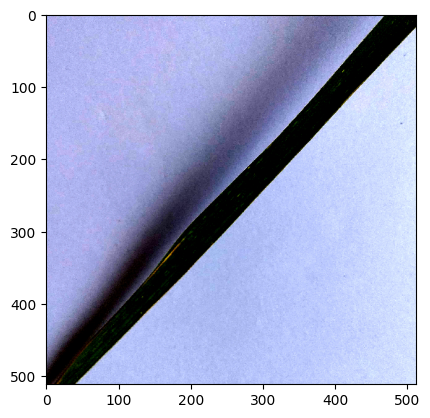

In [12]:
idx =1
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:"Browon Spot",1:"Healthy Leaf",2:"Invalid",3:"Leaf Blast"}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

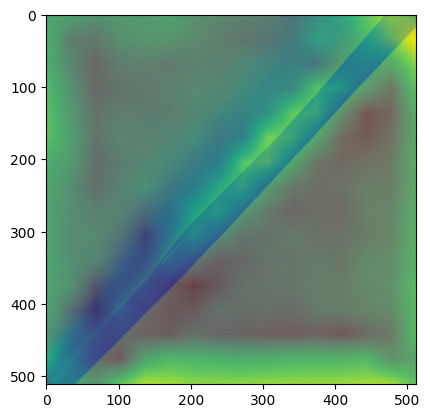

In [13]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

Browon Spot


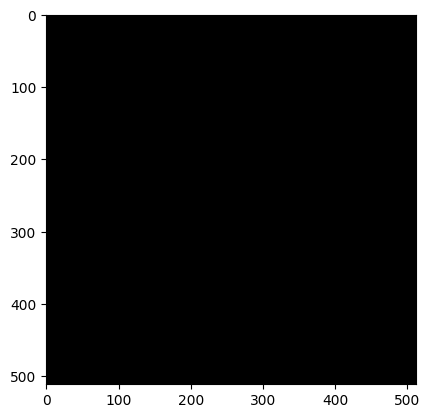

In [14]:
idx =2
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:"Browon Spot",1:"Healthy Leaf",2:"Invalid",3:"Leaf Blast"}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

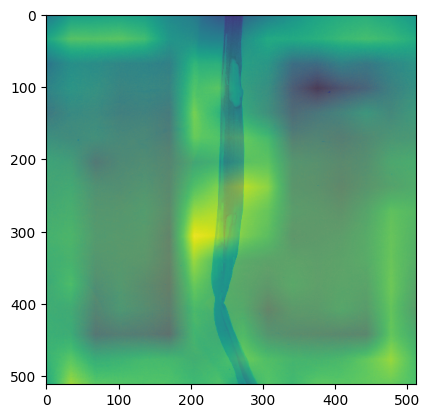

In [15]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

Browon Spot


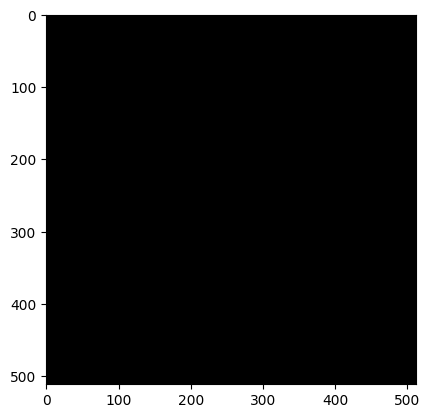

In [16]:
idx =3
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:"Browon Spot",1:"Healthy Leaf",2:"Invalid",3:"Leaf Blast"}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

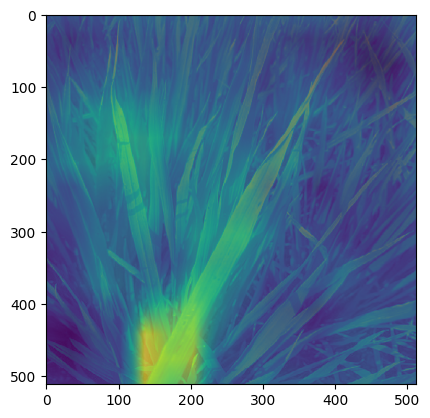

In [17]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

Leaf Blast


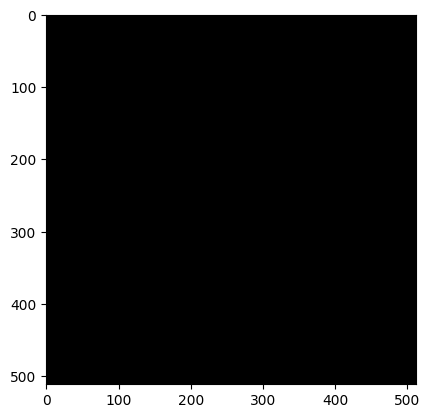

In [18]:
idx =4
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:"Browon Spot",1:"Healthy Leaf",2:"Invalid",3:"Leaf Blast"}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

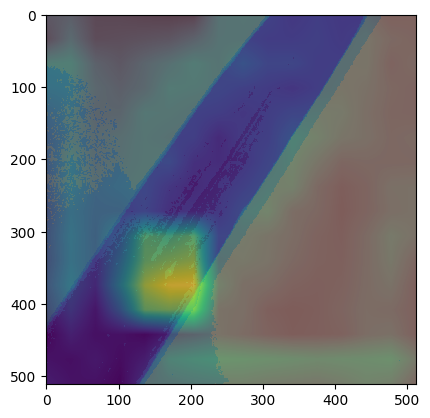

In [19]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

Invalid


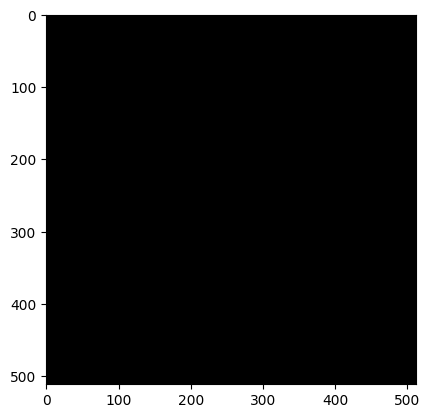

In [20]:
idx =5
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:"Browon Spot",1:"Healthy Leaf",2:"Invalid",3:"Leaf Blast"}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

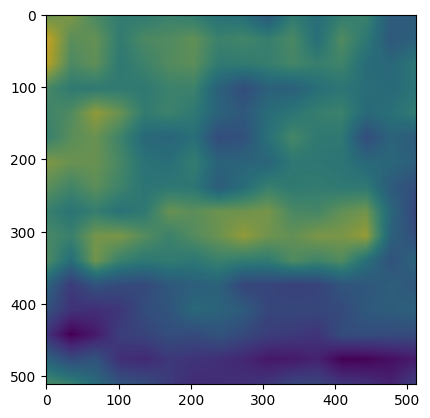

In [21]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

Leaf Blast


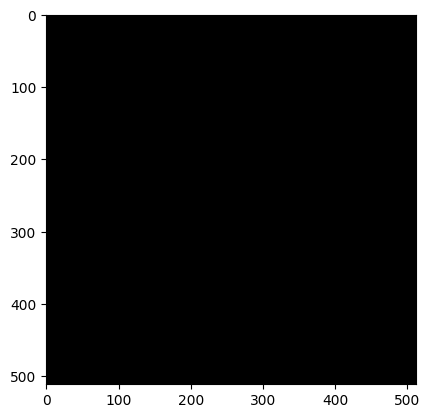

In [22]:
idx =6
features_for_img = o1[idx,:,:,:]
cat = tf.argmax(o2[idx]).numpy()
weights = model.layers[-1].get_weights()[0][:,cat]
image = sp.ndimage.zoom(features_for_img, (32,32,1), order=1)
k=np.dot(image[:,:,:],weights)
p=tf.keras.applications.mobilenet.preprocess_input(images)
dict1={0:"Browon Spot",1:"Healthy Leaf",2:"Invalid",3:"Leaf Blast"}
print(dict1[cat])
plt.imshow(images[idx,:,:,:])
plt.show()

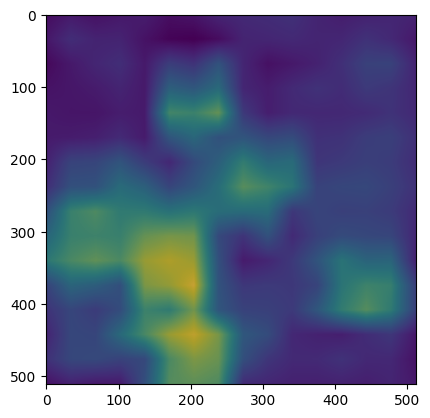

In [23]:
plt.imshow(np.mean(p[idx,:,:],axis=-1))
plt.imshow(k,alpha=0.7)
plt.show()

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(conv_model, to_file='model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
